**Autor**: Adam Szczepaniak


Data: 2025-02-04


**Projekt 4- wykrywanie zagrożeń cyberbezpieczeństwa**

Stworzenie, wytrenowanie oraz ocena modelu sieci neuronowej w postaci głębokiego autoenkodera, służącego do rozróżniania zwykłego ruchu sieciowego od ruchu anomalnego, którego charakter wskazuje na różne formy ataku (skanowanie, DoS/DDoS, próby nieautoryzowanego dostępu lub podniesienia uprawnień) na sieć i komputery w niej się znajdujące.

This project has been made during Polish-Japanese Academy of Information Technology postgraduate studies.

# Importy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#ignore warnings
import warnings
warnings.simplefilter ('ignore')

#trans libs
import pandas as pd
import numpy as np
import tensorflow as tf

#visualisation libs
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#ML libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

#setup pandas
pd.set_option ('display.width',100)
pd.set_option ('display.max_rows',50)
pd.set_option ('display.max_columns',20)

#setup seaborn
sns.set_style ('whitegrid')
sns.set_context ('paper', font_scale = 1.1)

#setup matplotlib
mpl.rcParams['font.family'] ='serif'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'semibold'

# Wczytanie danych

In [3]:
f_path = '/content/drive/MyDrive/Colab Notebooks/Cybersecurity/KDD_Cup_1999.csv'
df = pd.read_csv(f_path)
df.head()

duration protocol_type service flag  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0           tcp    http   SF        181       5450     0               0       0    0   
1         0           tcp    http   SF        239        486     0               0       0    0   
2         0           tcp    http   SF        235       1337     0               0       0    0   
3         0           tcp    http   SF        219       1337     0               0       0    0   
4         0           tcp    http   SF        217       2032     0               0       0    0   

   ...  dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0  ...                   9                     1.0                     0.0   
1  ...                  19                     1.0                     0.0   
2  ...                  29                     1.0                     0.0   
3  ...                  39                     1.0                     0.0   
4  ...                  49                     1.0                     0.0   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  dst_host_serror_rate  \
0                         0.11                          0.0                   0.0   
1                         0.05                          0.0                   0.0   
2                         0.03                          0.0                   0.0   
3                         0.03                          0.0                   0.0   
4                         0.02                          0.0                   0.0   

   dst_host_srv_serror_rate  dst_host_rerror_rate  dst_host_srv_rerror_rate  outcome  
0                       0.0                   0.0                       0.0   normal  
1                       0.0                   0.0                       0.0   normal  
2                       0.0                   0.0                       0.0   normal  
3                       0.0                   0.0                       0.0   normal  
4                       0.0                   0.0                       0.0   normal  

[5 rows x 42 columns]

# Rzut okiem na dane

## Analiza struktury zbioru

In [4]:
dfc = df.copy()

In [5]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

## Sprawdzenie występowania wartości pustych i duplikatów

In [6]:
print(f"Suma wartości pustych w poszczególnych kolumnach:")
dfc.isnull().any()

Suma wartości pustych w poszczególnych kolumnach:


duration                       False
protocol_type                  False
service                        False
flag                           False
src_bytes                      False
dst_bytes                      False
land                           False
wrong_fragment                 False
urgent                         False
hot                            False
num_failed_logins              False
logged_in                      False
num_compromised                False
root_shell                     False
su_attempted                   False
num_root                       False
num_file_creations             False
num_shells                     False
num_access_files               False
num_outbound_cmds              False
is_host_login                  False
is_guest_login                 False
count                          False
srv_count                      False
serror_rate                    False
srv_serror_rate                False
rerror_rate                    False
srv_rerror_rate                False
same_srv_rate                  False
diff_srv_rate                  False
srv_diff_host_rate             False
dst_host_count                 False
dst_host_srv_count             False
dst_host_same_srv_rate         False
dst_host_diff_srv_rate         False
dst_host_same_src_port_rate    False
dst_host_srv_diff_host_rate    False
dst_host_serror_rate           False
dst_host_srv_serror_rate       False
dst_host_rerror_rate           False
dst_host_srv_rerror_rate       False
outcome                        False
dtype: bool

In [7]:
f"Ilość duplikatów: {dfc.duplicated().sum()}"

'Ilość duplikatów: 348435'

## Statystyki danych numerycznych

In [8]:
num_stats = dfc.describe(include = np.number)

for column in num_stats.columns:
  print(f"Kolumna: {column}\n{22 * '-'}\n{dfc[column].describe()}\n")

Kolumna: duration
----------------------
count    494021.000000
mean         47.979302
std         707.746472
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       58329.000000
Name: duration, dtype: float64

Kolumna: src_bytes
----------------------
count    4.940210e+05
mean     3.025610e+03
std      9.882181e+05
min      0.000000e+00
25%      4.500000e+01
50%      5.200000e+02
75%      1.032000e+03
max      6.933756e+08
Name: src_bytes, dtype: float64

Kolumna: dst_bytes
----------------------
count    4.940210e+05
mean     8.685324e+02
std      3.304000e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.155468e+06
Name: dst_bytes, dtype: float64

Kolumna: land
----------------------
count    494021.000000
mean          0.000045
std           0.006673
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: land, dtype: f

## Statystyki danych opisowych

In [9]:
cat_stats = dfc.describe (exclude = np.number)
cat_stats.loc ['top %'] = np.round ((cat_stats.loc['freq'] / cat_stats.loc['count']).astype('float64'),4)
cat_stats

protocol_type service    flag outcome
count         494021  494021  494021  494021
unique             3      66      11      23
top             icmp   ecr_i      SF   smurf
freq          283602  281400  378440  280790
top %         0.5741  0.5696   0.766  0.5684

## Wartości przyjmowane przez dane opisowe

In [10]:
for column in cat_stats.columns:
  print(f"Kolumna: {column}\n{dfc[column].unique()}\n")

Kolumna: protocol_type
['tcp' 'udp' 'icmp']

Kolumna: service
['http' 'smtp' 'finger' 'domain_u' 'auth' 'telnet' 'ftp' 'eco_i' 'ntp_u'
 'ecr_i' 'other' 'private' 'pop_3' 'ftp_data' 'rje' 'time' 'mtp' 'link'
 'remote_job' 'gopher' 'ssh' 'name' 'whois' 'domain' 'login' 'imap4'
 'daytime' 'ctf' 'nntp' 'shell' 'IRC' 'nnsp' 'http_443' 'exec' 'printer'
 'efs' 'courier' 'uucp' 'klogin' 'kshell' 'echo' 'discard' 'systat'
 'supdup' 'iso_tsap' 'hostnames' 'csnet_ns' 'pop_2' 'sunrpc' 'uucp_path'
 'netbios_ns' 'netbios_ssn' 'netbios_dgm' 'sql_net' 'vmnet' 'bgp' 'Z39_50'
 'ldap' 'netstat' 'urh_i' 'X11' 'urp_i' 'pm_dump' 'tftp_u' 'tim_i' 'red_i']

Kolumna: flag
['SF' 'S1' 'REJ' 'S2' 'S0' 'S3' 'RSTO' 'RSTR' 'RSTOS0' 'OTH' 'SH']

Kolumna: outcome
['normal' 'buffer_overflow' 'loadmodule' 'perl' 'neptune' 'smurf'
 'guess_passwd' 'pod' 'teardrop' 'portsweep' 'ipsweep' 'land' 'ftp_write'
 'back' 'imap' 'satan' 'phf' 'nmap' 'multihop' 'warezmaster' 'warezclient'
 'spy' 'rootkit']



# Opis danych

## Opis zbioru

Zbiór składa się z 42 kolumn i 494 021 wierszy. Większość kolumn zawiera wartości numeryczne "int64" lub "float64". Cztery kolumny zawierają dane opisowe typu "object". W zbiorze nie ma wartości pustych. Wiersze zbioru  są w znacznej mierze zduplikowane. Ok. 70% danych to duplikaty. Nie zostaną usunięte, z uwagi na fakt, że pakiety danych mogą mieć powtarzalną charakterystykę.

### Dane ilościowe

**duration**- Czas trwania połączenia w sekundach. Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 58329.

**src_bytes**- ilość bajtów, wysłanych przez źródło. Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 6.933756e+08.

**dst_bytes**- ilość bajtów, odebranych przez cel. Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 5.155468e+06.

**wrong_fragment**- Ilość błędnych fragmentów pakietów. Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 3.

**urgent**- Ilość pakietów oznaczonych jako "pilne". Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 3.

**hot**- Ilość operacji w połączeniu, oznaczonych jako "gorące" (podejrzane). Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 30.

**num_failed_logins**- Ilość nieudanych prób logowania. Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 5.

**num_compromised**- Ilość naruszonych warunków bezpieczeństwa. Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 884.

**num_root**- Ilość operacji wykonywanych jako "root". Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 993.

**num_file_creations**- Ilość operacji tworzenia plików. Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 28.

**num_shells**- Ilość otwartych powłok systemowych. Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 2.

**num_access_files**- Ilość operacji dostępu do plików kontrolnych. Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 8.

**num_outbound_cmds**- Ilość poleceń wychodzących w sesji połączenia ftp. Zmienna ilościowa, dane typu "int64". Kolumna przyjmuje wartości 0 dla wszystkich wierszy.

**count**- Ilość połączeń do tego samego "hosta" (gospodarza) w pojedyńczym połączeniu w ostatnich dwóch sekundach. Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 511.

**srv_count**- Ilość połączeń do tej samej usługi sieciowej (protokołu komunikacyjnego) w pojedyńczym połączeniu w ostatnich dwóch sekundach. Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 511.

**serror_rate**- Procent połączeń z błędem SYN. Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**srv_serror_rate**- Procent połączeń z błędem SYN do tej samej usługi sieciowej. Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**rerror_rate**- Procent połączeń z błędem REJ. Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**srv_rerror_rate**- Procent połączeń z błędem REJ do tej samej usługi sieciowej. Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**same_srv_rate**- Procent połączeń do tej samej usługi sieciowej (protokołu komunikacyjnego). Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**diff_srv_rate**- Procent połączeń do różnych usług sieciowych (protokołów komunikacyjnych). Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**srv_diff_host_rate**- Procent połączeń do różnych "hostów" w ramach tej samej usługi sieciowej. Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**dst_host_count**- Liczba połączeń do tego samego adresu IP "hosta". Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 255.

**dst_host_srv_count**- Liczba połączeń do tej samej usługi sieciowej. Zmienna ilościowa, dane typu "int64". Przyjmuje wartości od 0 do 255.

**dst_host_same_srv_rate**- Procent połączeń do tej samej usługi sieciowej. Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**dst_host_diff_srv_rate**- Procent połączeń do różnych usług sieciowych. Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**dst_host_same_src_port_rate**- Procent połączeń z tego samego portu źródłowego. Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**dst_host_srv_diff_host_rate**- Procent połączeń do różnych hostów w ramach tej samej usługi sieciowej. Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**dst_host_serror_rate**- Procent połączeń zakończonych błędem SYN. Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**dst_host_srv_serror_rate**- Procent połączeń do tej samej usługi sieciowej zakończonych błędem SYN. Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**dst_host_rerror_rate**- Procent połączeń zakończonych błędem RST. Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

**dst_host_srv_rerror_rate**- Procent połączeń do tej samej usługi sieciowej zakończonych błędem RST. Zmienna ilościowa, dane typu "float64". Przyjmuje wartości od 0 do 1.

### Dane kategoryczne

**protocol_type**- Rodzaj protokołu użytego przy połączeniu. Zmienna kategoryczna, dane typu "object". Przyjmuje 3 unikalne wartości: 'tcp', 'udp', 'icmp'.

**service**- Usługa sieciowa celu (protokół komunikacyjny). Zmienna kategoryczna, dane typu "object". Przyjmuje 66 unikalnych wartości: 'http', 'smtp', 'finger', 'domain_u', 'auth', 'telnet', 'ftp', 'eco_i', 'ntp_u', 'ecr_i', 'other', 'private', 'pop_3', 'ftp_data', 'rje', 'time', 'mtp', 'link', 'remote_job', 'gopher', 'ssh', 'name', 'whois', 'domain', 'login', 'imap4', 'daytime', 'ctf', 'nntp', 'shell', 'IRC', 'nnsp', 'http_443', 'exec', 'printer', 'efs', 'courier', 'uucp', 'klogin', 'kshell', 'echo,' 'discard', 'systat', 'supdup', 'iso_tsap', 'hostnames', 'csnet_ns', 'pop_2', 'sunrpc', 'uucp_path', 'netbios_ns','netbios_ssn', 'netbios_dgm', 'sql_net', 'vmnet', 'bgp', 'Z39_50', 'ldap', 'netstat', 'urh_i', 'X11', 'urp_i', 'pm_dump', 'tftp_u', 'tim_i', 'red_i'.

**flag**- Normalny ('SF'), lub błędny (pozostałe) status połączenia. Zmienna kategoryczna, dane typu "object". Przyjmuje 11 unikalnych wartości: 'SF', 'S1', 'REJ', 'S2', 'S0', 'S3', 'RSTO', 'RSTR', 'RSTOS0', 'OTH', 'SH'.

**land**- Żródłowy i docelowy adres IP/port. Zmienna kategoryczna dychotomiczna. Przyjmuje wartość 1, jeśli źródłowy i docelowy adres IP oraz porty są takie same. Jeśli nie są, przyjmuje 0.

**logged_in**- Status logowania. Zmienna kategoryczna dychotomiczna. Przyjmuje wartość 1, jeśli logowanie się powiodło. Jeśli nie, przyjmuje 0.

**root_shell**- Powłoka "root". Zmienna kategoryczna dychotomiczna. Przyjmuje wartość 1, jeśli otwarto powłokę "root". Jeśli nie, przyjmuje 0.

**su_attempted**- Próba użycia komendy "su root". Zmienna kategoryczna dychotomiczna. Przyjmuje wartość 1, jeśli wystąpiła próba użycia "su root". Jeśli nie, przyjmuje 0.

**is_host_login**- Logowanie typu "host" (gospodarz). Zmienna kategoryczna dychotomiczna. Przyjmuje wartość 1, jeśli wystąpiło logowanie typu "host". Jeśli nie, przyjmuje 0. W kolumnie znajdują się tylko 0.

**is_guest_login**- Logowanie typu "guest" (gość). Zmienna kategoryczna dychotomiczna. Przyjmuje wartość 1, jeśli wystąpiło logowanie typu "guest". Jeśli nie, przyjmuje 0.

**outcome**- ZMIENNA CELU. Oznaczenie ruchu. Zmienna kategoryczna, dane typu "object". Przyjmuje 23 unikalne wartości: ruch normalny (normal), lub rodzaj ataku: 'buffer_overflow', 'loadmodule', 'perl', 'neptune', 'smurf', 'guess_passwd', 'pod', 'teardrop', 'portsweep', 'ipsweep', 'land', 'ftp_write',
 'back', 'imap', 'satan', 'phf', 'nmap', 'multihop', 'warezmaster', 'warezclient', 'spy', 'rootkit'.

## Podsumowanie

1. Zbiór zawiera 32 kolumny danych ilościowych oraz 10 kolumn danych kategorycznych. 3 kolumny kategoryczne "protocol_type" i "service" wymagają zakodowania.

2. Kolumna "outcome" zostanie przekształcona do wartości 0- ruch normalny, 1- atak.

3. Ok. 70% danych to duplikaty. Nie zostaną usunięte, z uwagi na fakt, że pakiety danych mogą mieć powtarzalną charakterystykę.

4. Dwie kolumny- "num_outbound_cmds" i "is_host_login" przyjmują wartości 0 dla wszystkich wierszy. Zostaną one usunięte jako dane błędne.

# Analiza eksploracyjna danych

## Przygotowanie zbioru do analizy

### Usunięcie kolumn zawierających nieprawidłowe dane

In [11]:
dfc = dfc.drop (columns = ['num_outbound_cmds', 'is_host_login'])
#dfc.info()

### Zastosowanie palety kolorów

In [12]:
#zastosowanie palety kolorów 'hls'
cols = dfc.columns.to_list()
palette = sns.color_palette("hls", 40).as_hex()

#słownik kolumn oraz przyporządkowanych do nich kolorów
colors = dict(zip (cols, palette))
colors['outcome'] = sns.color_palette("Paired").as_hex()[-1]

### Przygotowanie funkcji tworzących wykresy

In [13]:
#Funkcja kreśląca Coutplot i Boxplot, lub Histogram i Boxplot
def hist_box(x):

    x_desc = x.describe().to_frame().transpose()
    x_desc['unique'] = int(len(x.unique()))
    x_desc['RSD'] = np.round ((x.std() / x.mean()) * 100.0, 2)
    x_desc['skew'] = round (x.skew(), 4)
    x_desc['kurtosis'] = round (x.kurtosis(), 4)

    count = int(len(x))
    unique = int(len(x.unique()))

    values_amount = x.value_counts().to_frame().rename(columns = {'count':'amount'})
    values_percentage = round(((values_amount / count)* 100), 1).rename(columns = {'amount':'%'})

    x_val_desc = pd.concat([values_amount, values_percentage], axis = 1)

    cols = 2
    rows = 1

    fig, axes = plt.subplots (nrows = rows, ncols = cols, figsize = (15, 5))
    axes = axes.flatten()

    if len(x.unique()) >= 2 and len(x.unique()) <= 30:

        #tworzenie countplotu
        sns.countplot(x = x, ax = axes[0],
                  width = 0.5,
                  color = colors.get(x.name),
                  linewidth = 1,
                  alpha = 0.7,
                  edgecolor = 'black')

        #okienko boczne ze statystykami
        plt.suptitle (f"Countplot i Boxplot dla kolumny \"{x.name}\"")
    else:
        skew = round (x.skew(), 4)
        kurtosis = round (x.kurtosis(), 4)

        #tworzenie Histogramu
        if len(x.unique()) > 50:
            discrete = False
        else:
            discrete = True
        sns.histplot(x,
                     ax = axes[0],
                     bins = 30,
                     stat = 'count',
                     kde = True,
                     discrete = discrete,
                     color = colors.get(x.name),
                     linewidth = 1,
                     edgecolor = 'black',
                     line_kws = {'linestyle':'dashed', 'linewidth':2, 'alpha':0.7})
        plt.suptitle(f"Histogram and Boxplot dla kolumny \"{x.name}\"")

    #tworzenie boxplotu
    sns.boxplot(x, ax = axes[1], orient = 'h', color = colors.get(x.name),
                boxprops ={'edgecolor': "black", 'linewidth': 1.5},
                medianprops = {'color': 'lightgreen','linewidth' : 2},
                flierprops = {'markerfacecolor': 'red', 'marker': 'o',
                              'markersize': 4, 'markeredgecolor' : 'red'})

    #okienko boczne ze statystykami
    plt.text(0.92, 0.13, f'{x_val_desc}', bbox = dict(facecolor = f'{colors.get(x.name)}',
                                                          edgecolor = 'black',
                                                      alpha = 0.42),
             transform = plt.gcf().transFigure)

    axes[0].set_xlabel('Wartość')
    axes[1].set_xlabel('Wartość')
    axes[0].set_ylabel('Ilość')

    plt.show()
    return x_desc

In [14]:
def countplot(x):
    #obliczenie statystyk dla zmiennej

    count = int(len(x))
    unique = int(len(x.unique()))

    values_amount = x.value_counts().to_frame().rename(columns = {'count':'amount'})
    values_percentage = round(((values_amount / count)* 100), 1).rename(columns = {'amount':'%'})

    x_desc = pd.Series({'count':count, 'unique':unique}).to_frame(name = x.name).transpose()
    x_val_desc = pd.concat([values_amount, values_percentage], axis = 1)

    fig = plt.figure (figsize = (15,5))

    #tworzenie countplotu
    sns.countplot(x = x, width = 0.5, color = colors.get(x.name), linewidth = 1,
                  alpha = 0.7, edgecolor = 'black')

    plt.suptitle (f"Countplot dla kolumny \"{x.name}\"")
    plt.xlabel ('Wartość')
    plt.ylabel ('Ilość')
    if len(x.unique()) >= 20:
        plt.xticks (rotation = 90)

    #okienko boczne ze statystykami
    plt.text(0.92, 0.13, f'{x_val_desc}', bbox = dict(facecolor = f'{colors.get(x.name)}',
                                                      edgecolor = 'black',
                                                      alpha = 0.42),
             transform = plt.gcf().transFigure)
    plt.show()
    return x_desc

## Analiza univariate

### Dane ilościowe

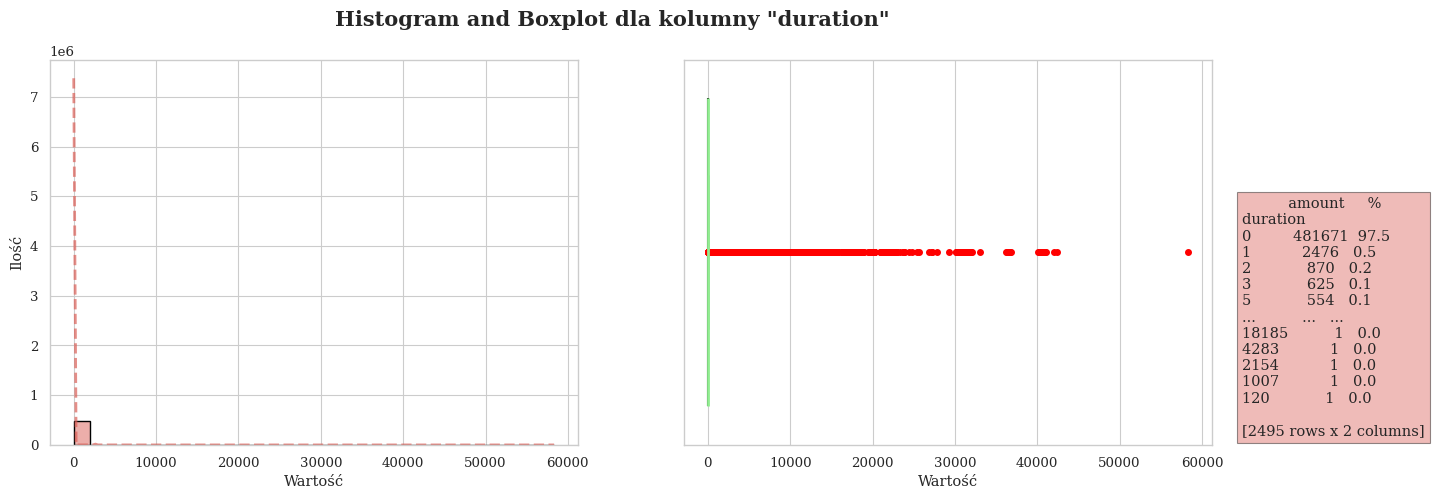

count       mean         std  min  25%  50%  75%      max  unique      RSD     skew  \
duration  494021.0  47.979302  707.746472  0.0  0.0  0.0  0.0  58329.0    2495  1475.11  25.8649   

          kurtosis  
duration  942.5302

In [15]:
hist_box(dfc['duration'])

**duration**- Rozkład zmiennej jest niesymetryczny, prawoskośny z długim ogonem (skew = 25.8649, kurtosis = 942.5302). 97.5% danych ma wartość równą 0. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

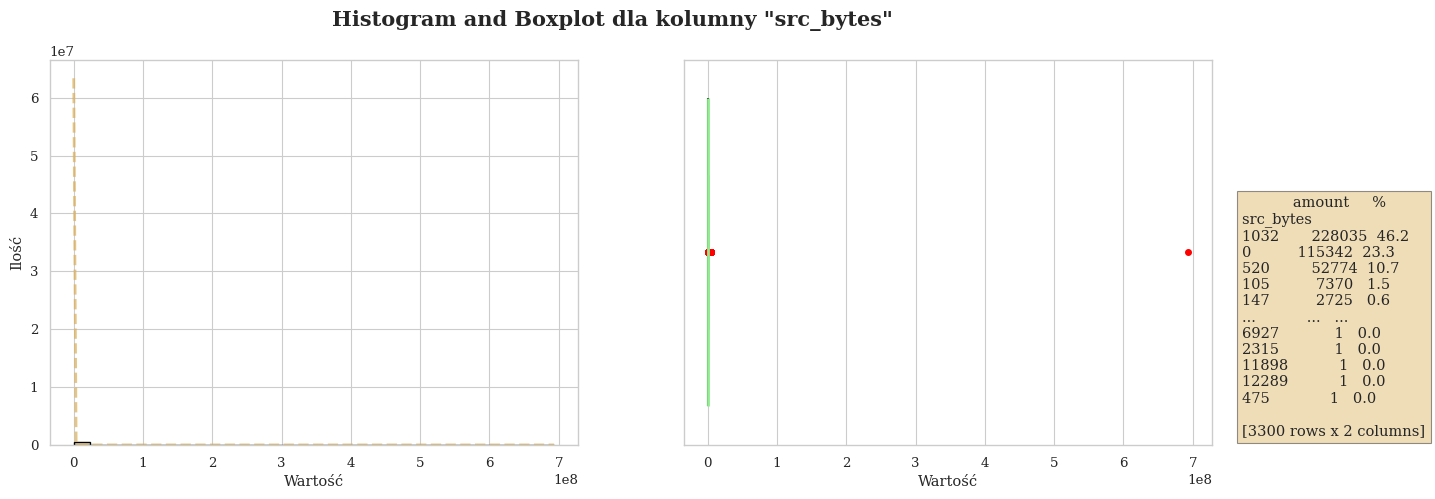

count         mean            std  min   25%    50%     75%          max  unique  \
src_bytes  494021.0  3025.610296  988218.101045  0.0  45.0  520.0  1032.0  693375640.0    3300   

                RSD      skew     kurtosis  
src_bytes  32661.78  699.2132  490584.3456

In [16]:
hist_box(dfc['src_bytes'])

**src_bytes**- Rozkład zmiennej jest niesymetryczny, prawoskośny z długim ogonem (skew = 699.2132, kurtosis = 490584.3456). Większość danych znajduje się okolicy 0. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

In [17]:
hist_box(dfc['dst_bytes'])

count        mean           std  min  25%  50%  75%        max  unique      RSD  \
dst_bytes  494021.0  868.532425  33040.001252  0.0  0.0  0.0  0.0  5155468.0   10725  3804.12   

               skew    kurtosis  
dst_bytes  136.7593  20338.1434

**dst_bytes**- Rozkład zmiennej jest niesymetryczny, prawoskośny z długim ogonem (skew = 136.7593, kurtosis = 20338.1434). 82.6 % danych ma wartość równą 0. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

In [18]:
hist_box(dfc['wrong_fragment'])

count      mean       std  min  25%  50%  75%  max  unique      RSD     skew  \
wrong_fragment  494021.0  0.006433  0.134805  0.0  0.0  0.0  0.0  3.0       3  2095.55  21.7189   

                kurtosis  
wrong_fragment  476.0875

**wrong_fragment**- Zmienna przybiera 3 unikalne wartości, przy czym 99.7 % danych ma wartość równą 0. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

In [19]:
hist_box(dfc['urgent'])

count      mean      std  min  25%  50%  75%  max  unique       RSD     skew  \
urgent  494021.0  0.000014  0.00551  0.0  0.0  0.0  0.0  3.0       4  38888.33  447.647   

           kurtosis  
urgent  217366.7102

**urgent**- Zmienna przybiera 4 unikalne wartości, przy czym niemal 100 % danych ma wartość równą 0. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

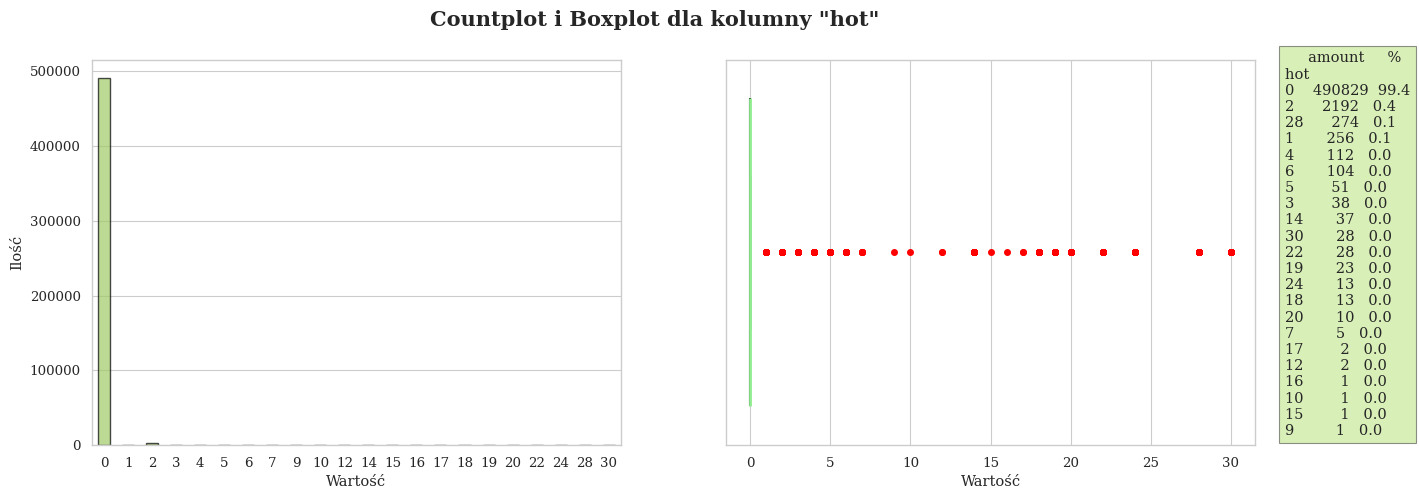

count      mean       std  min  25%  50%  75%   max  unique      RSD     skew   kurtosis
hot  494021.0  0.034519  0.782103  0.0  0.0  0.0  0.0  30.0      22  2265.73  32.6291  1127.0172

In [20]:
hist_box(dfc['hot'])

**hot**- Zmienna przybiera 22 unikalne wartości, przy czym 99.4 % danych ma wartość równą 0. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

In [21]:
hist_box(dfc['num_failed_logins'])

count      mean      std  min  25%  50%  75%  max  unique       RSD  \
num_failed_logins  494021.0  0.000152  0.01552  0.0  0.0  0.0  0.0  5.0       6  10222.68   

                       skew    kurtosis  
num_failed_logins  160.8026  37221.5971

**num_failed_logins**- Zmienna przybiera 6 unikalnych wartości, przy czym niemal 100 % danych ma wartość równą 0. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

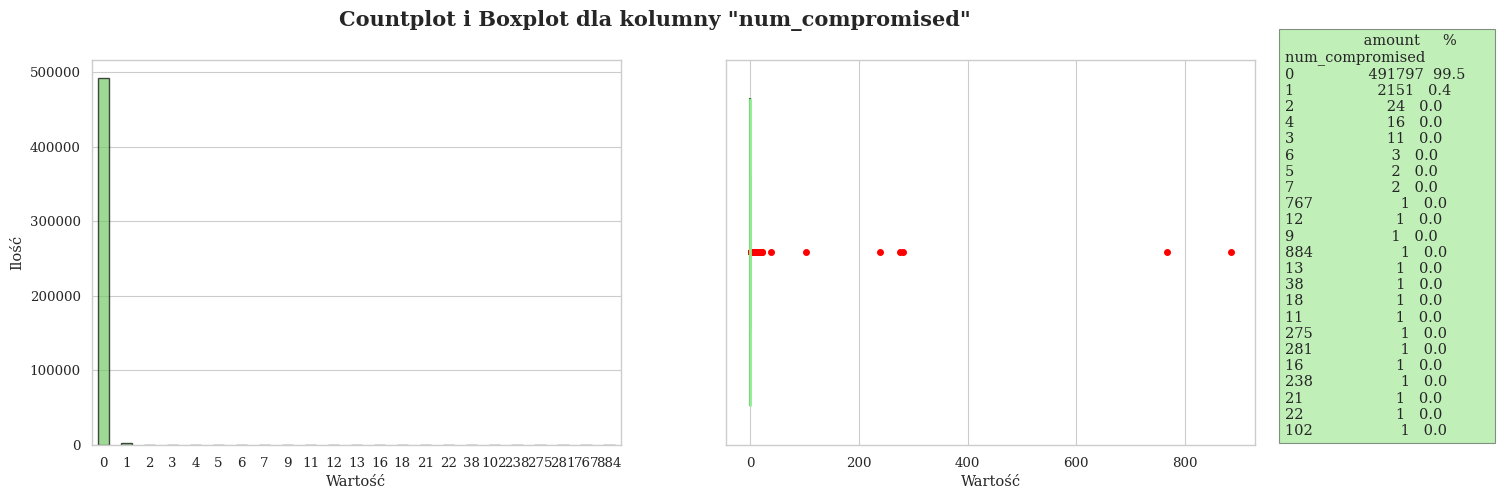

count      mean       std  min  25%  50%  75%    max  unique       RSD  \
num_compromised  494021.0  0.010212  1.798326  0.0  0.0  0.0  0.0  884.0      23  17609.73   

                     skew     kurtosis  
num_compromised  417.5302  188121.3477

In [22]:
hist_box(dfc['num_compromised'])

**num_compromised**- Zmienna przybiera 23 unikalnych wartości, przy czym 99.5 % danych ma wartość równą 0. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

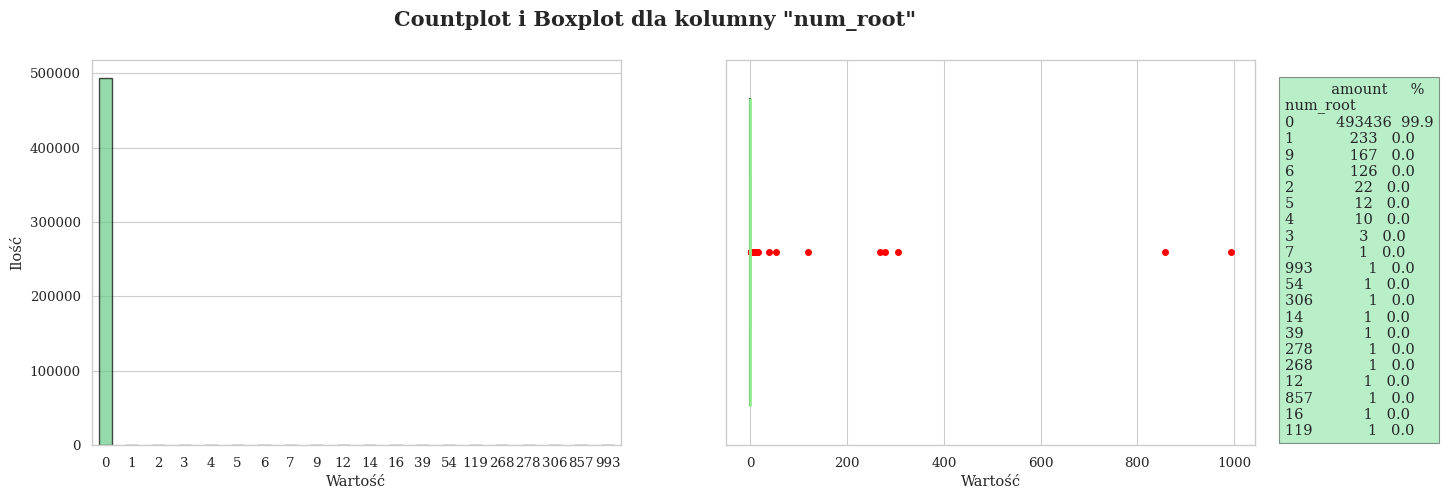

count      mean       std  min  25%  50%  75%    max  unique       RSD      skew  \
num_root  494021.0  0.011352  2.012718  0.0  0.0  0.0  0.0  993.0      20  17730.48  417.0658   

             kurtosis  
num_root  188933.0466

In [23]:
hist_box(dfc['num_root'])

**num_root**- Zmienna przybiera 20 unikalnych wartości, przy czym 99.9 % danych ma wartość równą 0. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

In [24]:
hist_box(dfc['num_file_creations'])

count      mean       std  min  25%  50%  75%   max  unique      RSD  \
num_file_creations  494021.0  0.001083  0.096416  0.0  0.0  0.0  0.0  28.0      18  8903.08   

                        skew    kurtosis  
num_file_creations  192.3348  43583.8949

**num_file_creations**- Zmienna przybiera 18 unikalnych wartości, przy czym 99.9 % danych ma wartość równą 0. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

In [25]:
hist_box(dfc['num_shells'])

count      mean      std  min  25%  50%  75%  max  unique      RSD      skew  \
num_shells  494021.0  0.000109  0.01102  0.0  0.0  0.0  0.0  2.0       3  10081.7  108.8742   

              kurtosis  
num_shells  13169.2988

**num_shells**- Zmienna przybiera 3 unikalnych wartości, przy czym niemal 100 % danych ma wartość równą 0. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

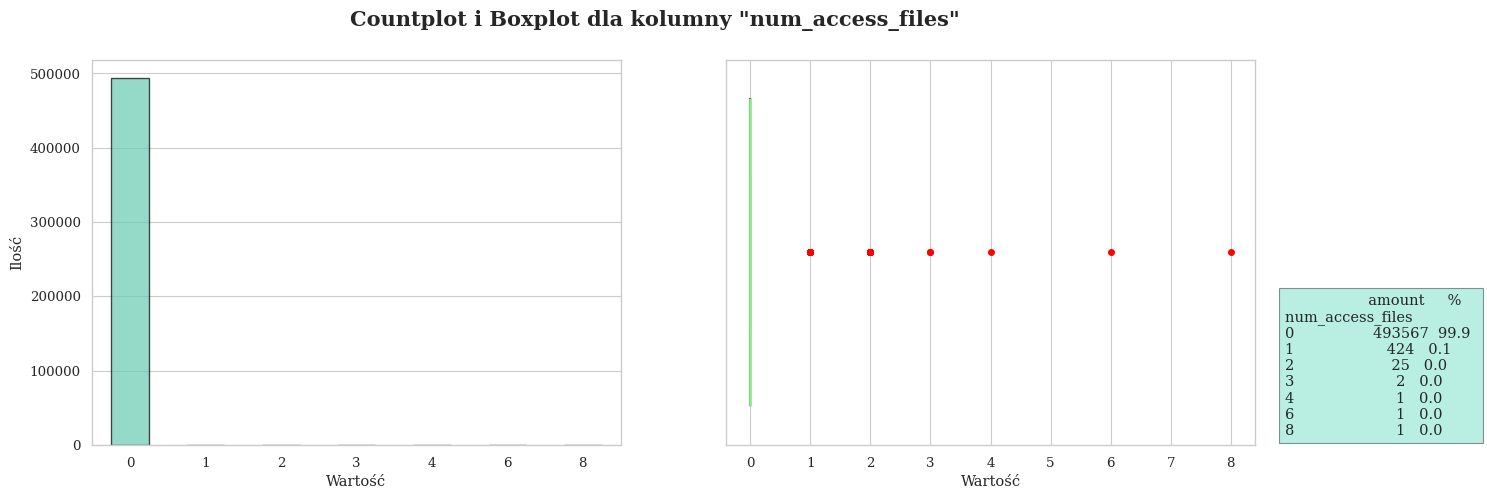

count      mean       std  min  25%  50%  75%  max  unique      RSD     skew  \
num_access_files  494021.0  0.001008  0.036482  0.0  0.0  0.0  0.0  8.0       7  3619.02  61.2015   

                   kurtosis  
num_access_files  7571.4041

In [26]:
hist_box(dfc['num_access_files'])

**num_access_files**- Zmienna przybiera 7 unikalnych wartości, przy czym 99.9 % danych ma wartość równą 0. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

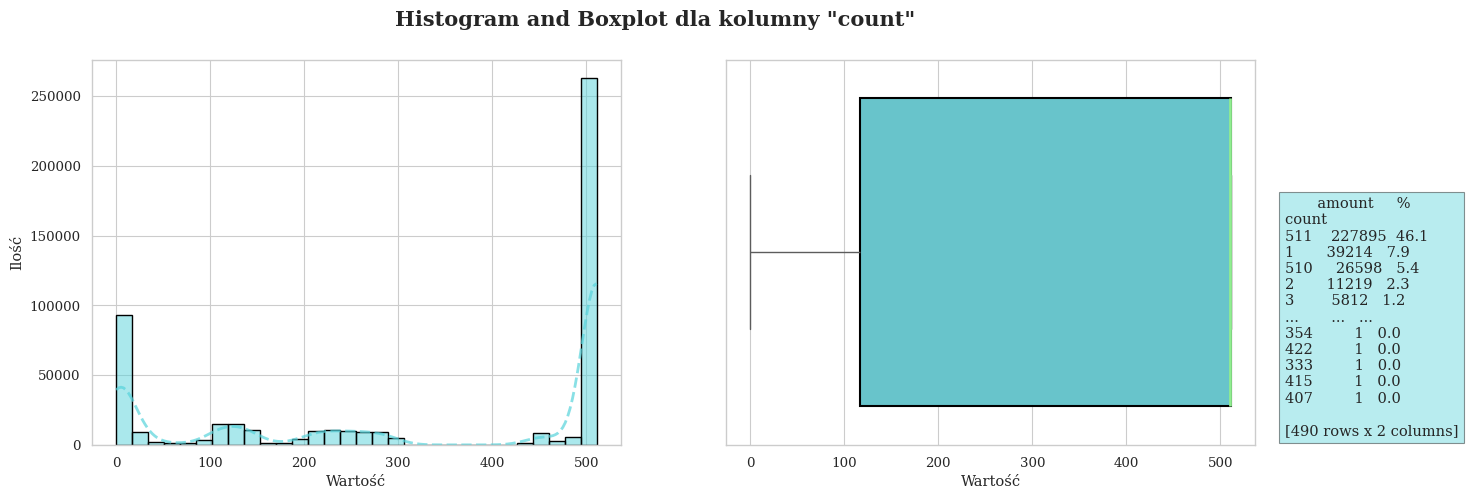

count       mean         std  min    25%    50%    75%    max  unique    RSD   skew  \
count  494021.0  332.28569  213.147412  0.0  117.0  510.0  511.0  511.0     490  64.15 -0.542   

       kurtosis  
count   -1.4722

In [27]:
hist_box(dfc['count'])

**count**- Rozkład zmiennej jest niesymetryczny, lewoskośny, stosunkowo płaski (skew = -0.542, kurtosis = -1.4722). Większość danych znajduje się okolicach skrajów rozkładu. W kolumnie brak wartości skrajnych, znajdujących się poza zakresem 1.5 IQR.

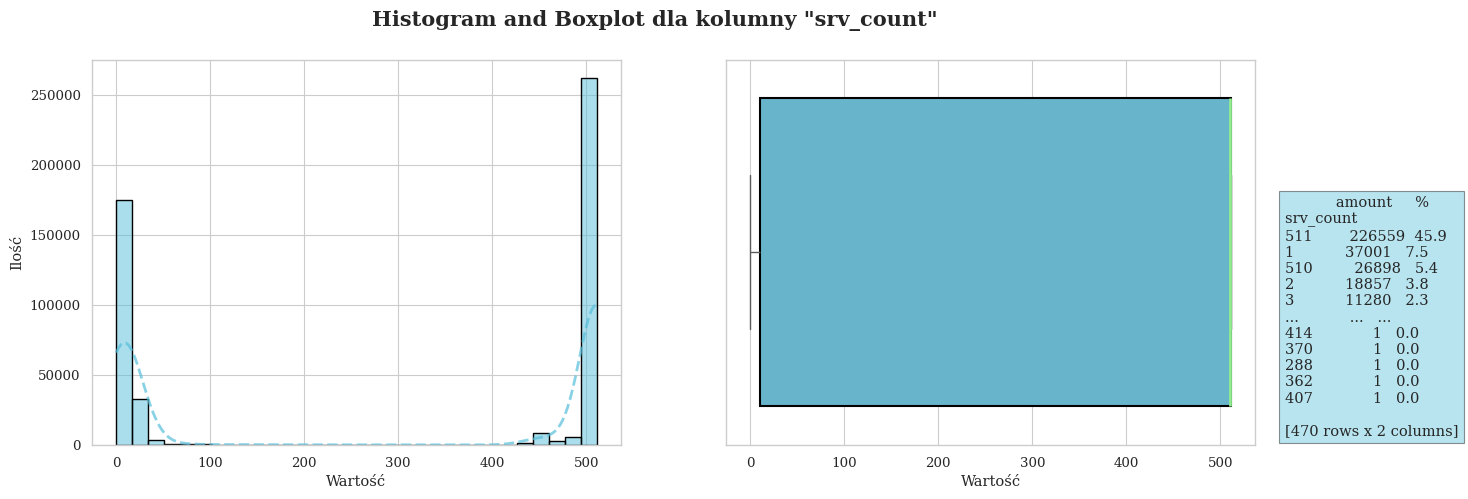

count        mean         std  min   25%    50%    75%    max  unique   RSD    skew  \
srv_count  494021.0  292.906557  246.322817  0.0  10.0  510.0  511.0  511.0     470  84.1 -0.2738   

           kurtosis  
srv_count   -1.9151

In [28]:
hist_box(dfc['srv_count'])

**srv_count**- Rozkład zmiennej jest niesymetryczny, lewoskośny, stosunkowo płaski (skew = -0.2738, kurtosis = -1.9151). Większość danych znajduje się okolicach skrajów rozkładu. W kolumnie brak wartości skrajnych, znajdujących się poza zakresem 1.5 IQR.

In [29]:
hist_box(dfc['serror_rate'])

count      mean       std  min  25%  50%  75%  max  unique     RSD    skew  \
serror_rate  494021.0  0.176687  0.380717  0.0  0.0  0.0  0.0  1.0      92  215.48  1.6976   

             kurtosis  
serror_rate    0.8855

**serror_rate**- Rozkład zmiennej jest niesymetryczny, prawoskośny, płaski. (skew = 1.6976, kurtosis = 0.8855). Większość danych znajduje się okolicach skrajów rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

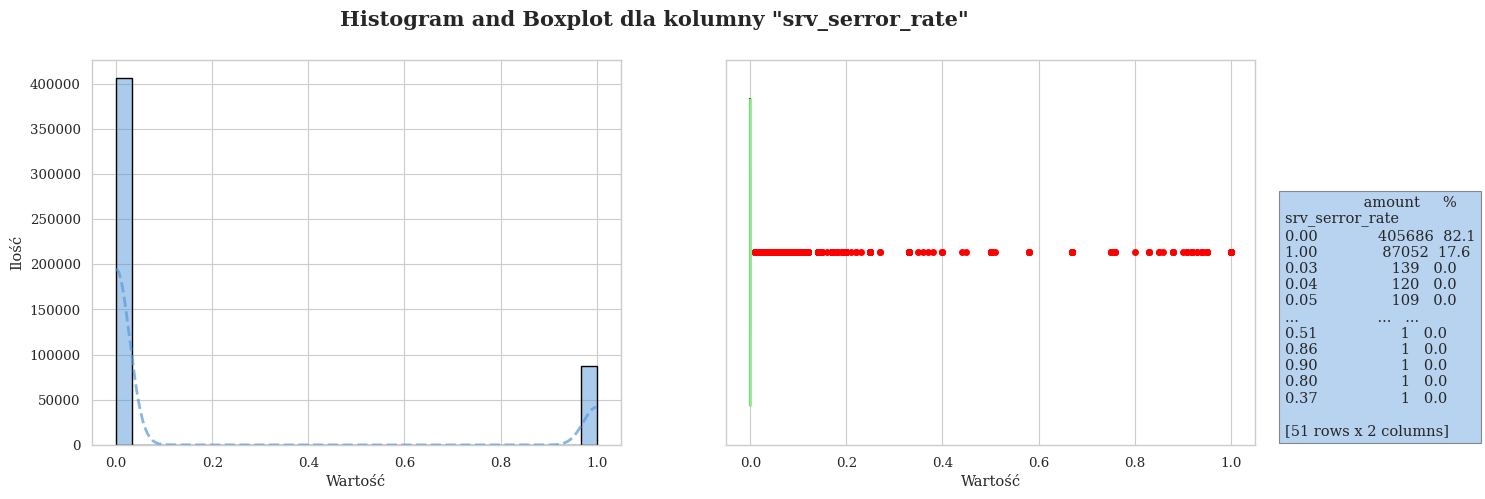

count      mean       std  min  25%  50%  75%  max  unique     RSD    skew  \
srv_serror_rate  494021.0  0.176609  0.381017  0.0  0.0  0.0  0.0  1.0      51  215.74  1.6972   

                 kurtosis  
srv_serror_rate    0.8822

In [30]:
hist_box(dfc['srv_serror_rate'])

**srv_serror_rate**- Rozkład zmiennej jest niesymetryczny, prawoskośny, płaski. (skew = 1.6972, kurtosis = 0.8822). Większość danych znajduje się okolicach skrajów rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

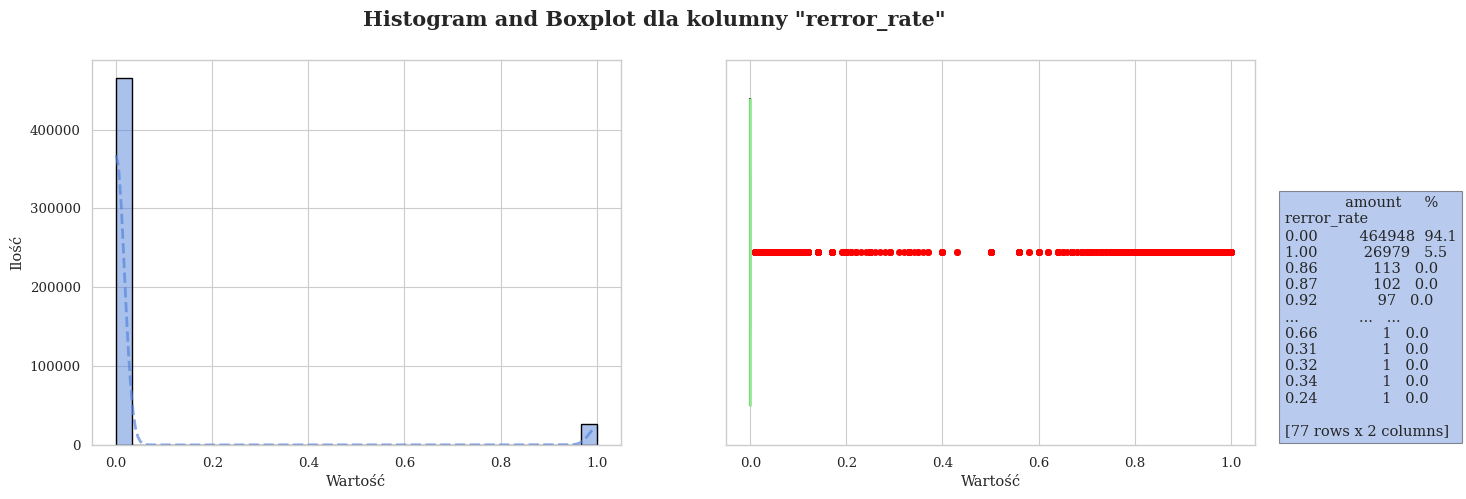

count      mean       std  min  25%  50%  75%  max  unique     RSD   skew  \
rerror_rate  494021.0  0.057433  0.231623  0.0  0.0  0.0  0.0  1.0      77  403.29  3.799   

             kurtosis  
rerror_rate   12.4575

In [31]:
hist_box(dfc['rerror_rate'])

**rerror_rate**- Rozkład zmiennej jest niesymetryczny, prawoskośny, płaski. (skew = 3.799, kurtosis = 12.4575). Większość danych znajduje się okolicach skrajów rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

In [32]:
hist_box(dfc['srv_rerror_rate'])

count      mean       std  min  25%  50%  75%  max  unique    RSD  skew  \
srv_rerror_rate  494021.0  0.057719  0.232147  0.0  0.0  0.0  0.0  1.0      51  402.2   3.8   

                 kurtosis  
srv_rerror_rate   12.4721

**srv_rerror_rate**- Rozkład zmiennej jest niesymetryczny, prawoskośny, płaski. (skew = 3.8, kurtosis = 12.4721). Większość danych znajduje się okolicach skrajów rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

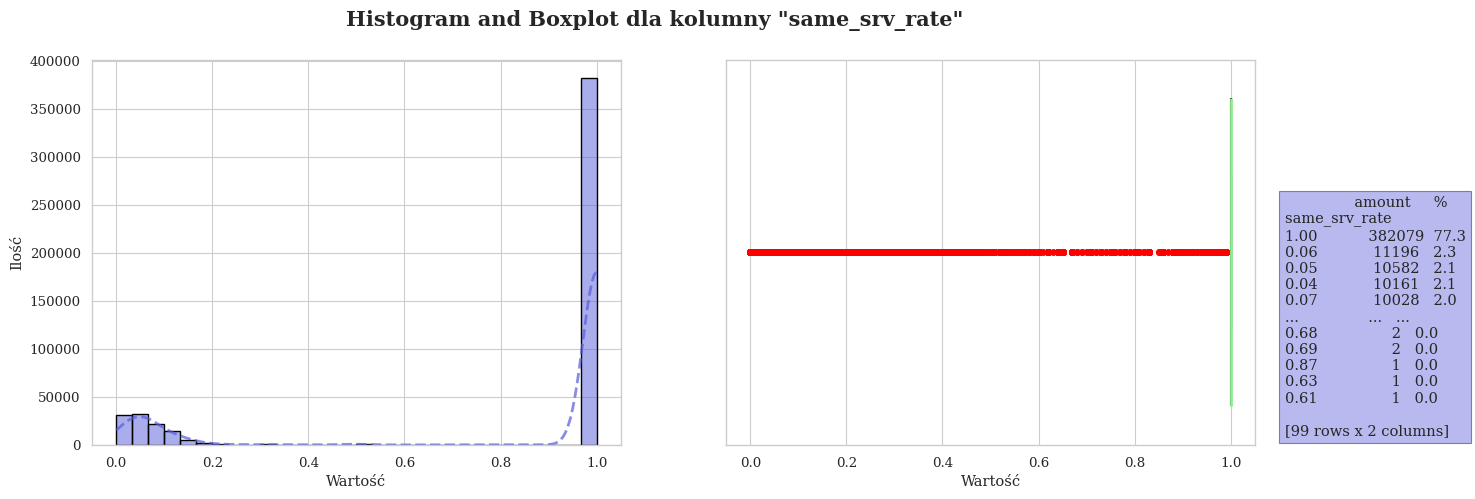

count      mean       std  min  25%  50%  75%  max  unique    RSD    skew  \
same_srv_rate  494021.0  0.791547  0.388189  0.0  1.0  1.0  1.0  1.0      99  49.04 -1.3421   

               kurtosis  
same_srv_rate    -0.171

In [33]:
hist_box(dfc['same_srv_rate'])

**same_srv_rate**- Rozkład zmiennej jest niesymetryczny, lewoskośny, płaski. (skew = -1.3421, kurtosis = -0.171). Większość danych znajduje się okolicach prawego skraju rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

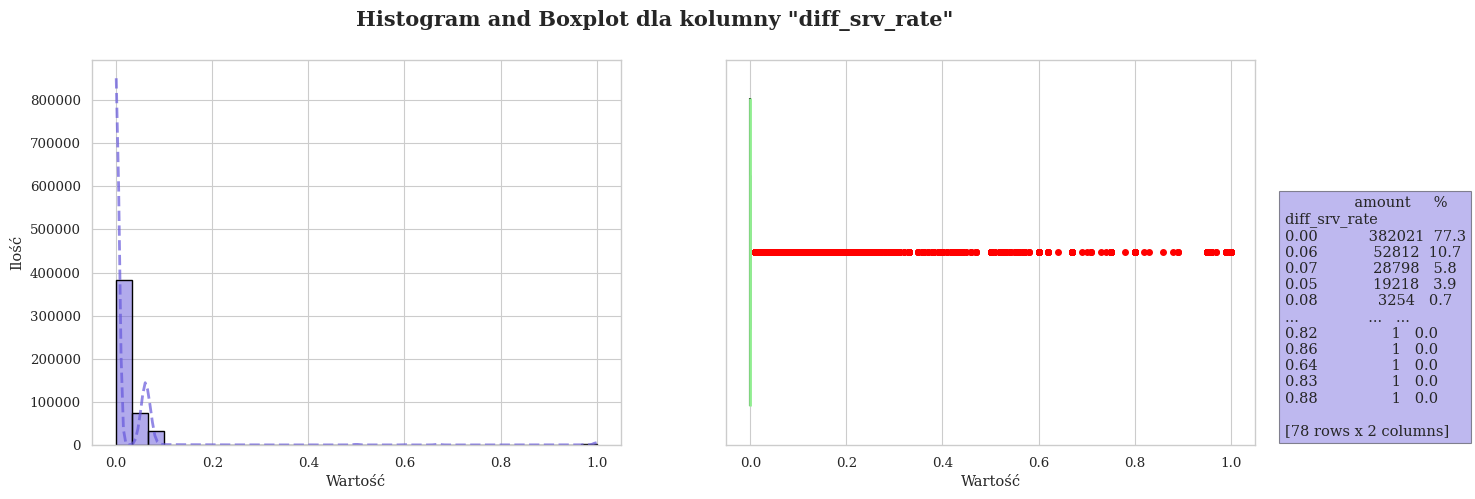

count      mean       std  min  25%  50%  75%  max  unique     RSD    skew  \
diff_srv_rate  494021.0  0.020982  0.082205  0.0  0.0  0.0  0.0  1.0      78  391.78  9.6424   

               kurtosis  
diff_srv_rate  105.1129

In [34]:
hist_box(dfc['diff_srv_rate'])

**diff_srv_rate**- Rozkład zmiennej jest niesymetryczny, prawoskośny, stosunkowo płaski (skew = 9.6424, kurtosis = 105.1129). Większość danych znajduje się okolicach lewego skraju rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

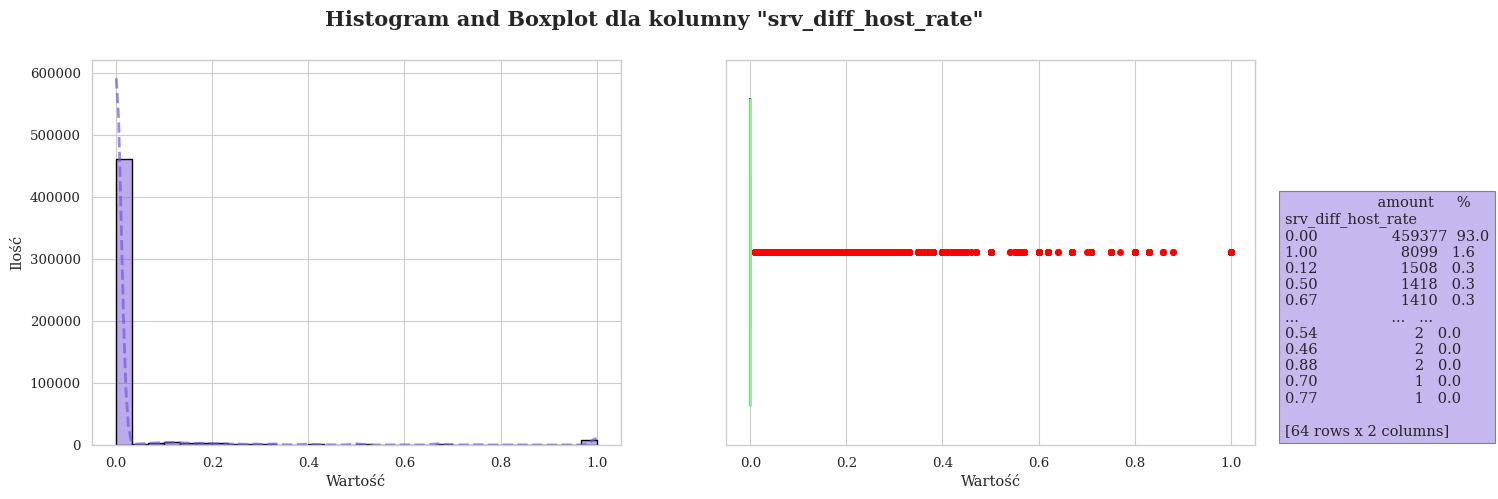

count      mean       std  min  25%  50%  75%  max  unique     RSD   skew  \
srv_diff_host_rate  494021.0  0.028997  0.142397  0.0  0.0  0.0  0.0  1.0      64  491.08  5.869   

                    kurtosis  
srv_diff_host_rate   35.1149

In [35]:
hist_box(dfc['srv_diff_host_rate'])

**srv_diff_host_rate**- Rozkład zmiennej jest niesymetryczny, prawoskośny, stosunkowo płaski (skew = 5.869, kurtosis = 35.1149). Większość danych znajduje się okolicach lewego skraju rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

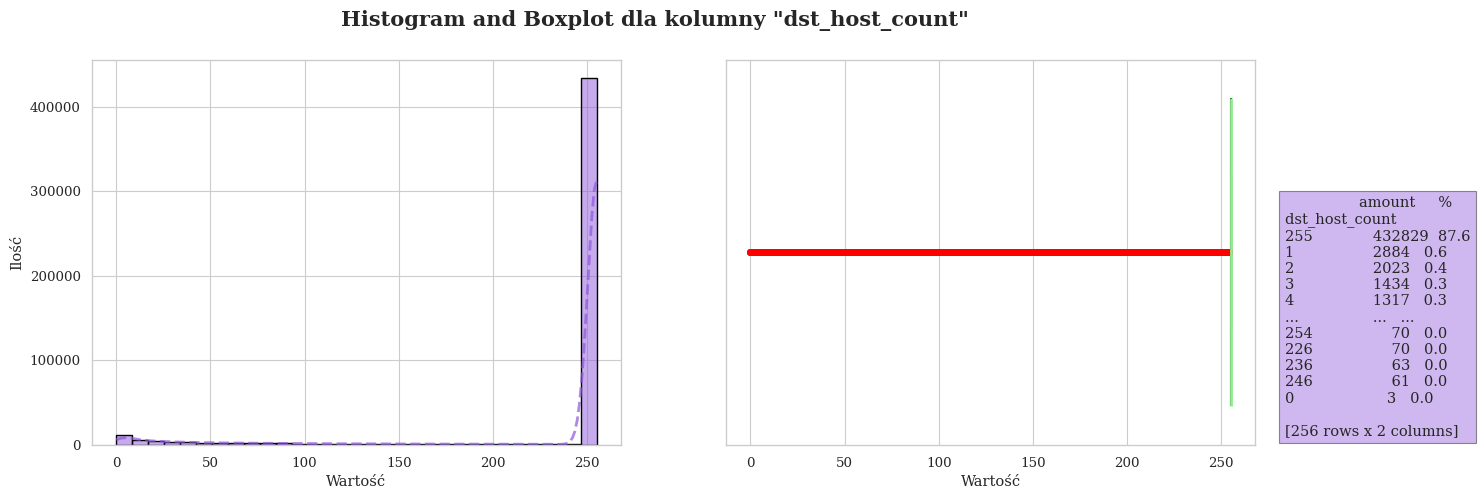

count        mean       std  min    25%    50%    75%    max  unique    RSD  \
dst_host_count  494021.0  232.470778  64.74538  0.0  255.0  255.0  255.0  255.0     256  27.85   

                  skew  kurtosis  
dst_host_count -2.7307    5.8529

In [36]:
hist_box(dfc['dst_host_count'])

**dst_host_count**- Rozkład zmiennej jest niesymetryczny, lewoskośny, stosunkowo płaski (skew = -2.7307, kurtosis = 5.8529). Większość danych znajduje się okolicach prawego skraju rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

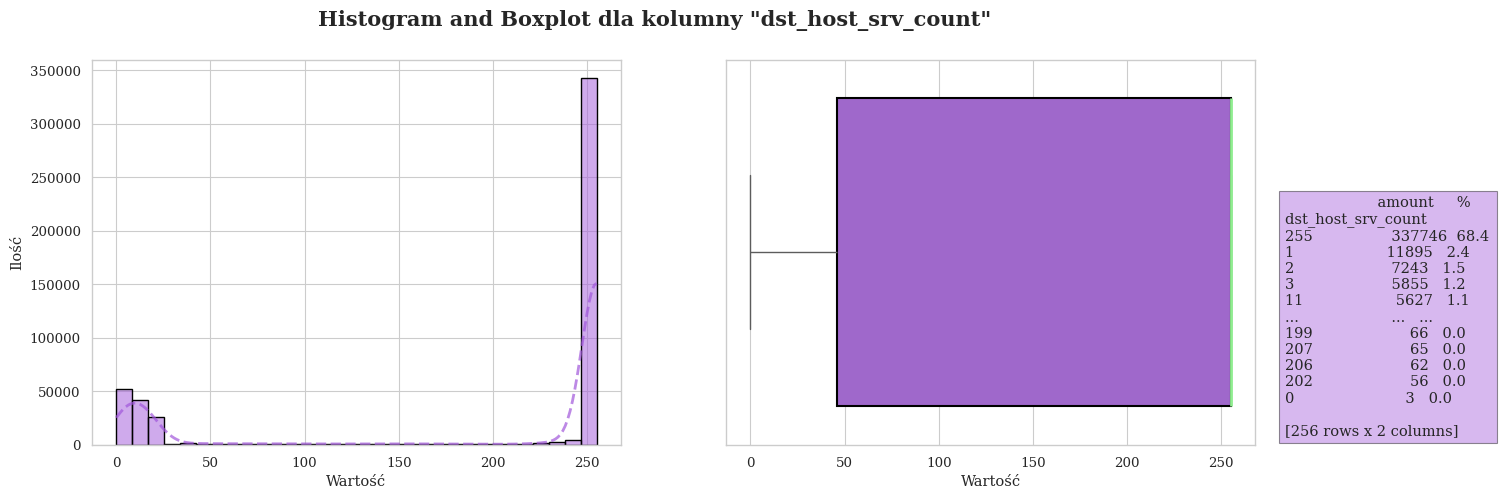

count       mean         std  min   25%    50%    75%    max  unique  \
dst_host_srv_count  494021.0  188.66567  106.040437  0.0  46.0  255.0  255.0  255.0     256   

                      RSD    skew  kurtosis  
dst_host_srv_count  56.21 -1.0349   -0.8741

In [37]:
hist_box(dfc['dst_host_srv_count'])

**dst_host_srv_count**- Rozkład zmiennej jest niesymetryczny, lewoskośny, stosunkowo płaski (skew = -1.0349, kurtosis = -0.8741). Większość danych znajduje się okolicach prawego skraju rozkładu. W kolumnie brak wartości odstających, znajdujące się poza zakresem 1.5 IQR.

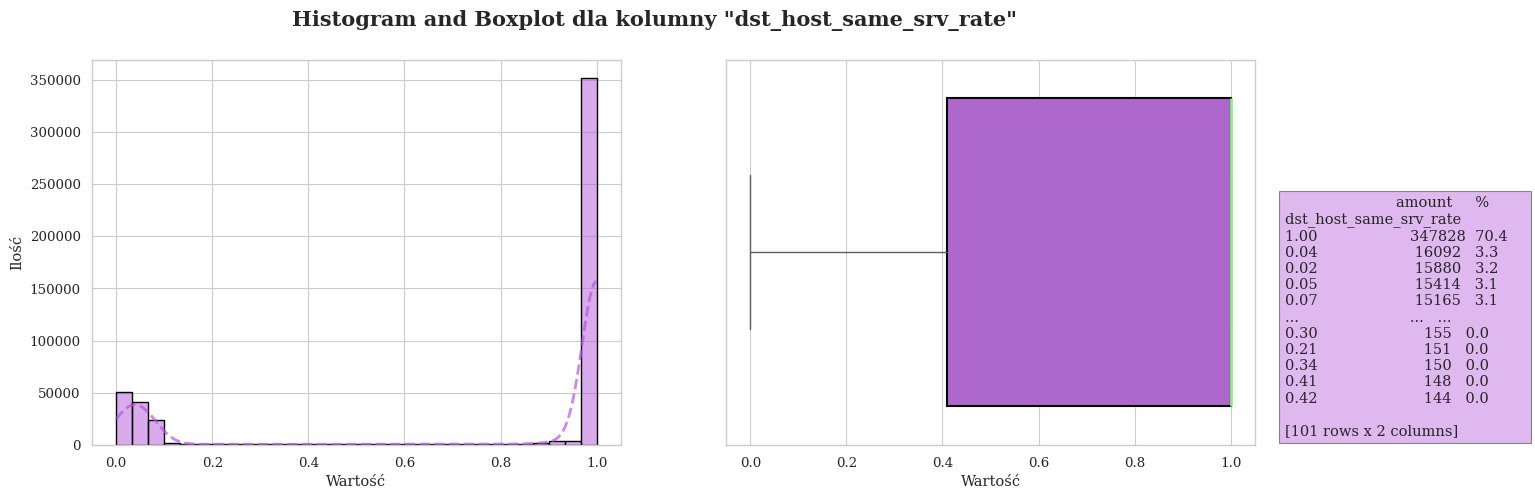

count     mean       std  min   25%  50%  75%  max  unique   RSD  \
dst_host_same_srv_rate  494021.0  0.75378  0.410781  0.0  0.41  1.0  1.0  1.0     101  54.5   

                          skew  kurtosis  
dst_host_same_srv_rate -1.1255   -0.6872

In [38]:
hist_box(dfc['dst_host_same_srv_rate'])

**dst_host_same_srv_rate**- Rozkład zmiennej jest niesymetryczny, lewoskośny, stosunkowo płaski (skew = -1.1255, kurtosis = -0.6872). Większość danych znajduje się okolicach prawego skraju rozkładu. W kolumnie brak wartości odstających, znajdujące się poza zakresem 1.5 IQR.

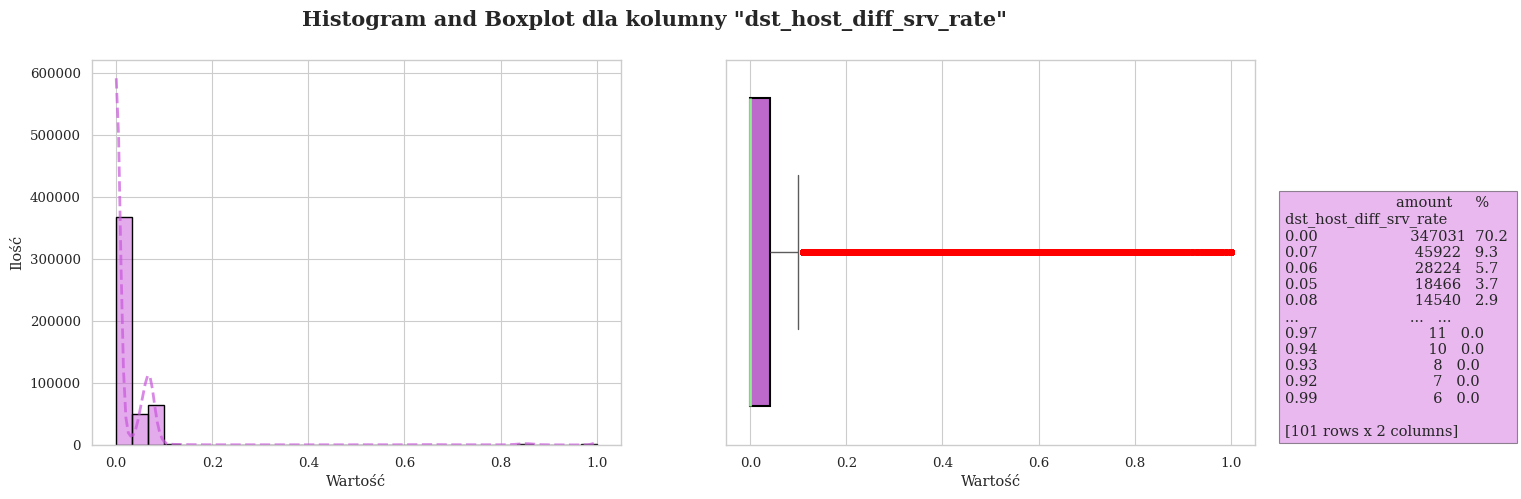

count      mean       std  min  25%  50%   75%  max  unique     RSD  \
dst_host_diff_srv_rate  494021.0  0.030906  0.109259  0.0  0.0  0.0  0.04  1.0     101  353.52   

                          skew  kurtosis  
dst_host_diff_srv_rate  6.8572   50.2903

In [39]:
hist_box(dfc['dst_host_diff_srv_rate'])

**dst_host_diff_srv_rate**- Rozkład zmiennej jest niesymetryczny, prawoskośny, stosunkowo płaski (skew = -6.8572, kurtosis = 60.2903). Większość danych znajduje się okolicach lewego skraju rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

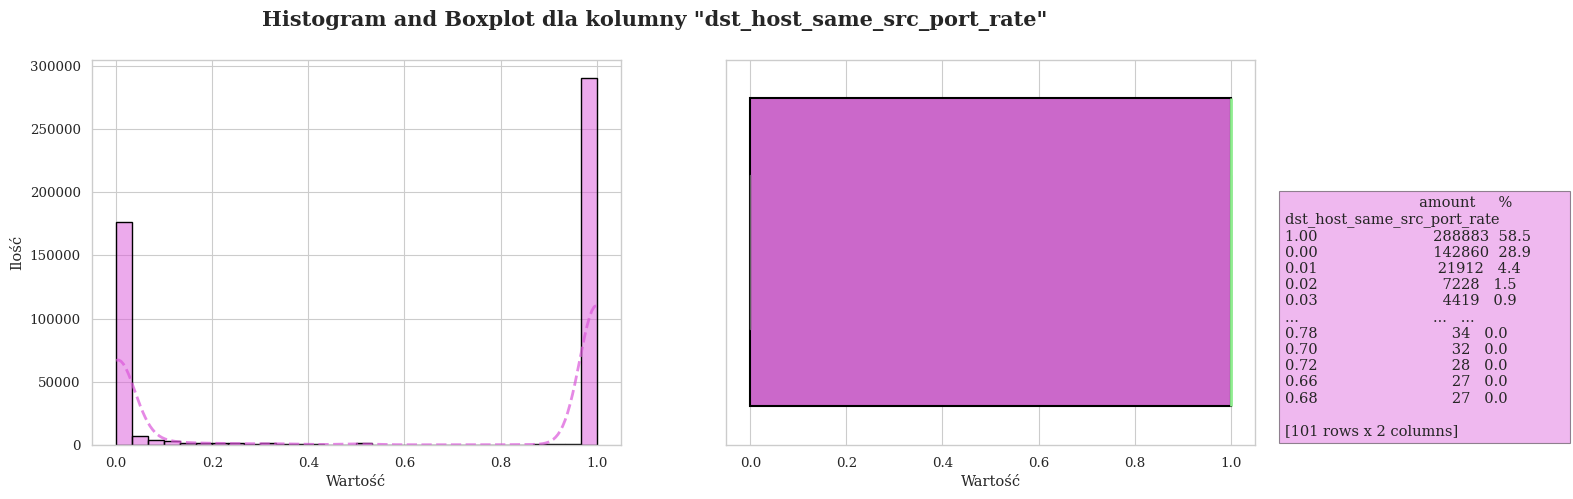

count      mean       std  min  25%  50%  75%  max  unique    RSD  \
dst_host_same_src_port_rate  494021.0  0.601935  0.481309  0.0  0.0  1.0  1.0  1.0     101  79.96   

                               skew  kurtosis  
dst_host_same_src_port_rate -0.4006   -1.8194

In [40]:
hist_box(dfc['dst_host_same_src_port_rate'])

**dst_host_same_src_port_rate**- Rozkład zmiennej jest niesymetryczny, lewoskośny, stosunkowo płaski (skew = -0.4006, kurtosis = -1.8194). Większość danych znajduje się okolicach prawego skraju rozkładu. W kolumnie brak wartości odstających, znajdujące się poza zakresem 1.5 IQR.

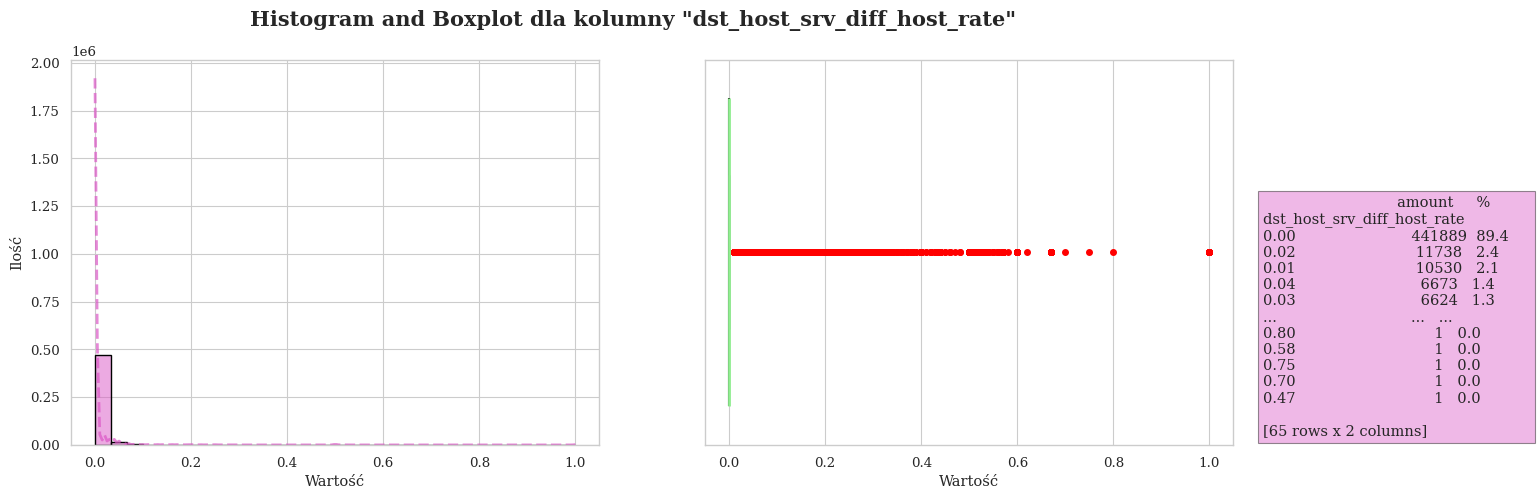

count      mean       std  min  25%  50%  75%  max  unique    RSD  \
dst_host_srv_diff_host_rate  494021.0  0.006684  0.042133  0.0  0.0  0.0  0.0  1.0      65  630.4   

                                skew  kurtosis  
dst_host_srv_diff_host_rate  14.3526  271.0179

In [41]:
hist_box(dfc['dst_host_srv_diff_host_rate'])

**dst_host_srv_diff_host_rate**- Rozkład zmiennej jest niesymetryczny, prawoskośny, stosunkowo płaski (skew = 14.3526, kurtosis = 271.0179). Większość danych znajduje się okolicach lewego skraju rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

In [42]:
hist_box(dfc['dst_host_serror_rate'])

count      mean       std  min  25%  50%  75%  max  unique     RSD  \
dst_host_serror_rate  494021.0  0.176754  0.380593  0.0  0.0  0.0  0.0  1.0     100  215.32   

                        skew  kurtosis  
dst_host_serror_rate  1.6984    0.8881

**dst_host_serror_rate**- Rozkład zmiennej jest niesymetryczny, prawoskośny, stosunkowo płaski (skew = 1.6984, kurtosis = 0.8881). Większość danych znajduje się okolicach lewego skraju rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem 1.5 IQR.

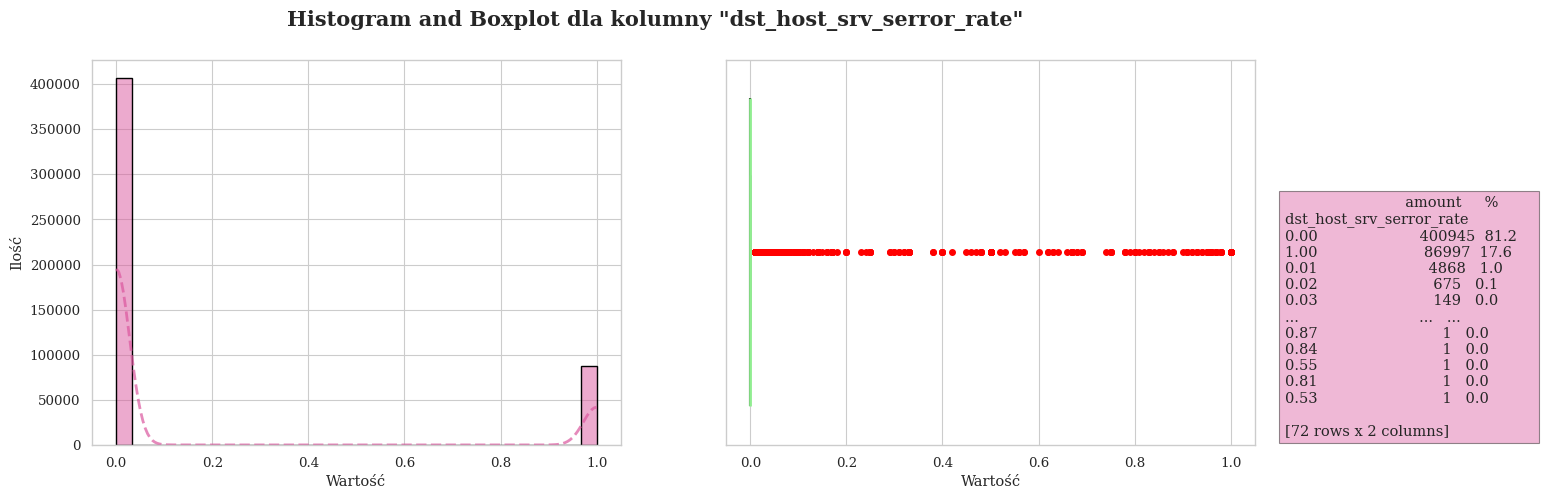

count      mean       std  min  25%  50%  75%  max  unique     RSD  \
dst_host_srv_serror_rate  494021.0  0.176443  0.380919  0.0  0.0  0.0  0.0  1.0      72  215.89   

                           skew  kurtosis  
dst_host_srv_serror_rate  1.699    0.8871

In [43]:
hist_box(dfc['dst_host_srv_serror_rate'])

**dst_host_srv_serror_rate**- Rozkład zmiennej jest niesymetryczny,
prawoskośny, stosunkowo płaski (skew = 1.699, kurtosis = 0.8871). Większość danych znajduje się okolicach lewego skraju rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem
 1.5 IQR.

In [44]:
hist_box(dfc['dst_host_rerror_rate'])

count      mean      std  min  25%  50%  75%  max  unique     RSD  \
dst_host_rerror_rate  494021.0  0.058118  0.23059  0.0  0.0  0.0  0.0  1.0     101  396.76   

                        skew  kurtosis  
dst_host_rerror_rate  3.7813   12.3827

**dst_host_rerror_rate**- Rozkład zmiennej jest niesymetryczny,
prawoskośny, stosunkowo płaski (skew = 3.7813, kurtosis = 12.3827). Większość danych znajduje się okolicach lewego skraju rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem
 1.5 IQR.

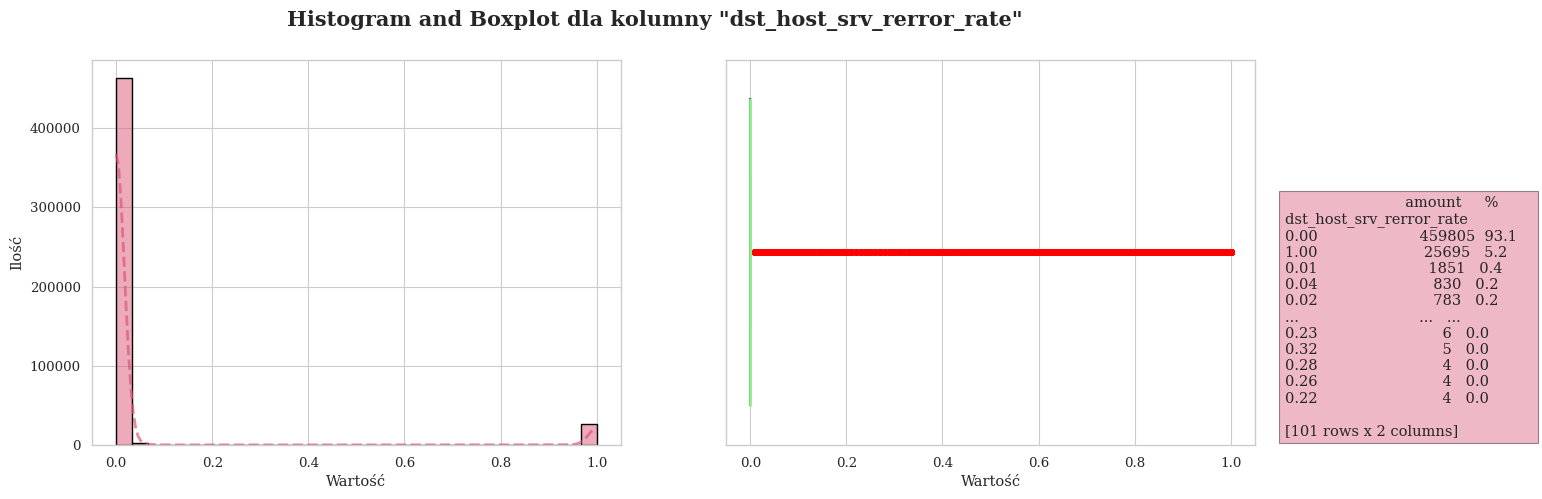

count      mean      std  min  25%  50%  75%  max  unique     RSD  \
dst_host_srv_rerror_rate  494021.0  0.057412  0.23014  0.0  0.0  0.0  0.0  1.0     101  400.86   

                            skew  kurtosis  
dst_host_srv_rerror_rate  3.8058   12.5426

In [45]:
hist_box(dfc['dst_host_srv_rerror_rate'])

**dst_host_srv_rerror_rate**- Rozkład zmiennej jest niesymetryczny,
prawoskośny, stosunkowo płaski (skew = 3.8058, kurtosis = 12.5426). Większość danych znajduje się okolicach lewego skraju rozkładu. W kolumnie zidentyfikowano wartości odstające, znajdujące się poza zakresem
 1.5 IQR.

### Dane kategoryczne

In [46]:
countplot(dfc['protocol_type'])

count  unique
protocol_type  494021       3

**protocol_type**- Zmienna przybiera 3 unikalne wartości. Wartością najczęściej wystepującą jest 'icmp' (57.4 % przypadków). Najrzadziej występuje wartość 'udp' (4.1 % przypadków). Kolumna wymaga zakodowania.

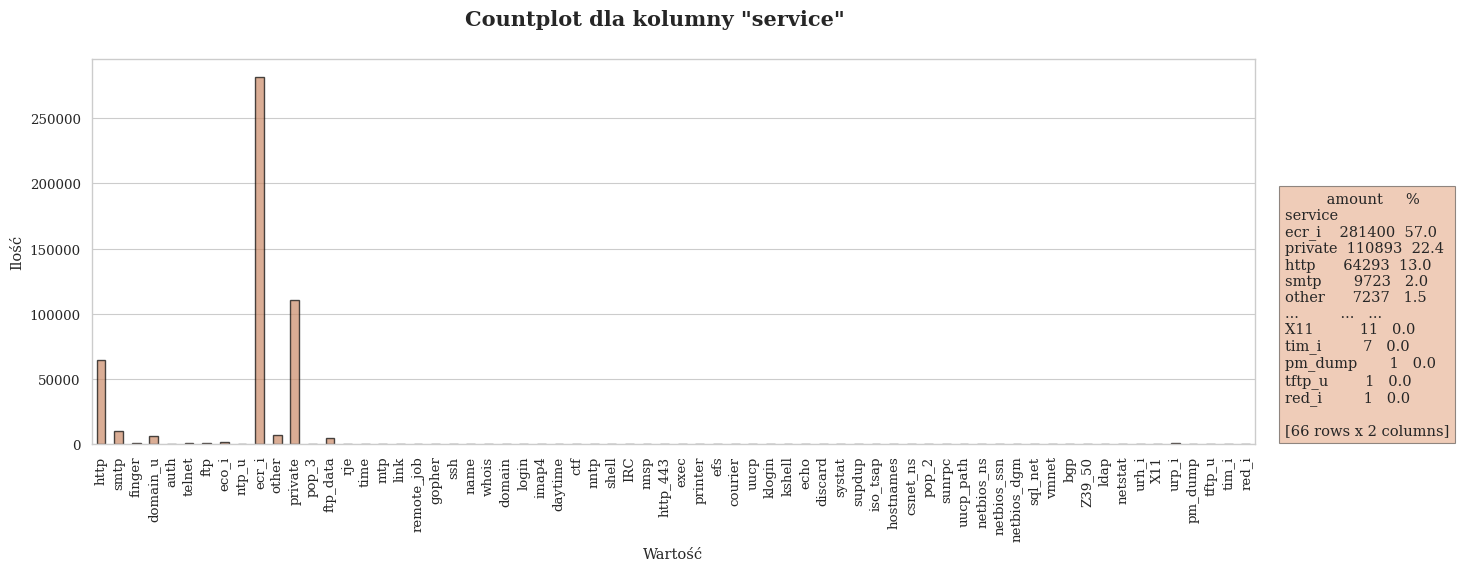

count  unique
service  494021      66

In [47]:
countplot(dfc['service'])

**service**- Zmienna przybiera 66 unikalnych wartości. Wartością najczęściej wystepującą jest 'ecr_i' (57.0 % przypadków). Kolumna wymaga zakodowania.

In [48]:
countplot(dfc['flag'])

count  unique
flag  494021      11

**flag**- Zmienna przybiera 11 unikalnych wartości. Wartością najczęściej wystepującą jest 'SF' (76.6 % przypadków). Najrzadziej występuje wartość 'OTH' (8 przypadków). Kolumna wymaga zakodowania.

In [49]:
countplot(dfc['land'])

count  unique
land  494021       2

**land**- Zmienna przybiera 2 unikalne wartości- 0 i 1. Wartością najczęściej wystepującą jest '0' (niemal 100 % przypadków). Wartość '1' występuje jedynie w 22 przypadkach. Kolumna nie wymaga kodowania.

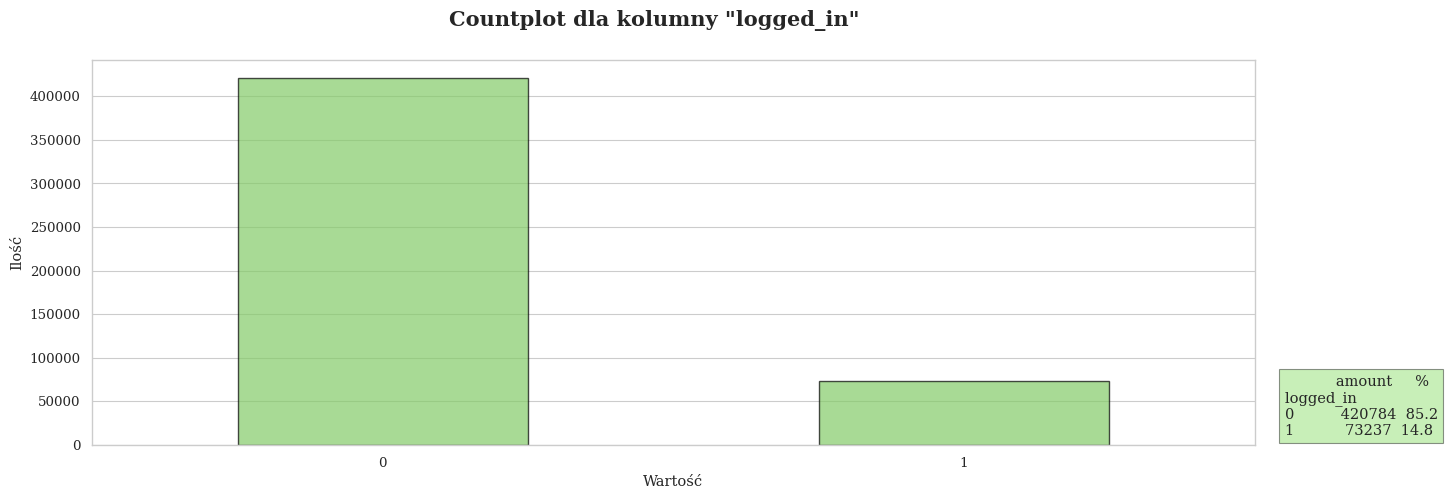

count  unique
logged_in  494021       2

In [50]:
countplot(dfc['logged_in'])

**logged_in**- Zmienna przybiera 2 unikalne wartości- 0 i 1. Wartością najczęściej wystepującą jest '0' (85.2 % przypadków). Kolumna nie wymaga kodowania.

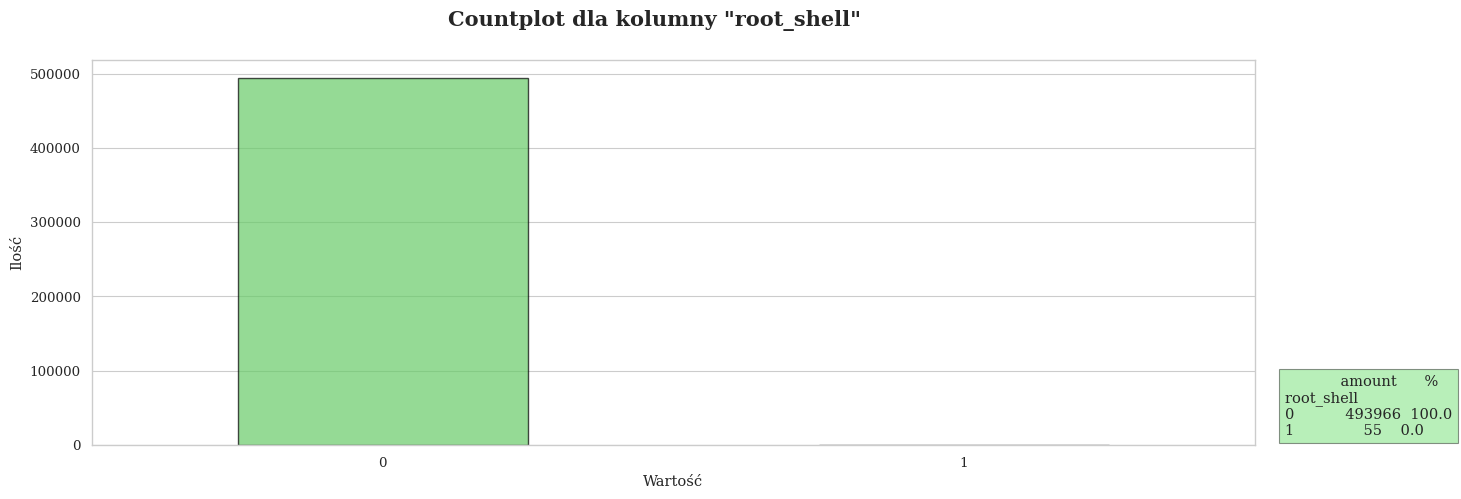

count  unique
root_shell  494021       2

In [51]:
countplot(dfc['root_shell'])

**root_shell**- Zmienna przybiera 2 unikalne wartości- 0 i 1. Wartością najczęściej wystepującą jest '0' (niemal 100 % przypadków). Wartość '1' występuje jedynie w 55 przypadkach. Kolumna nie wymaga kodowania.

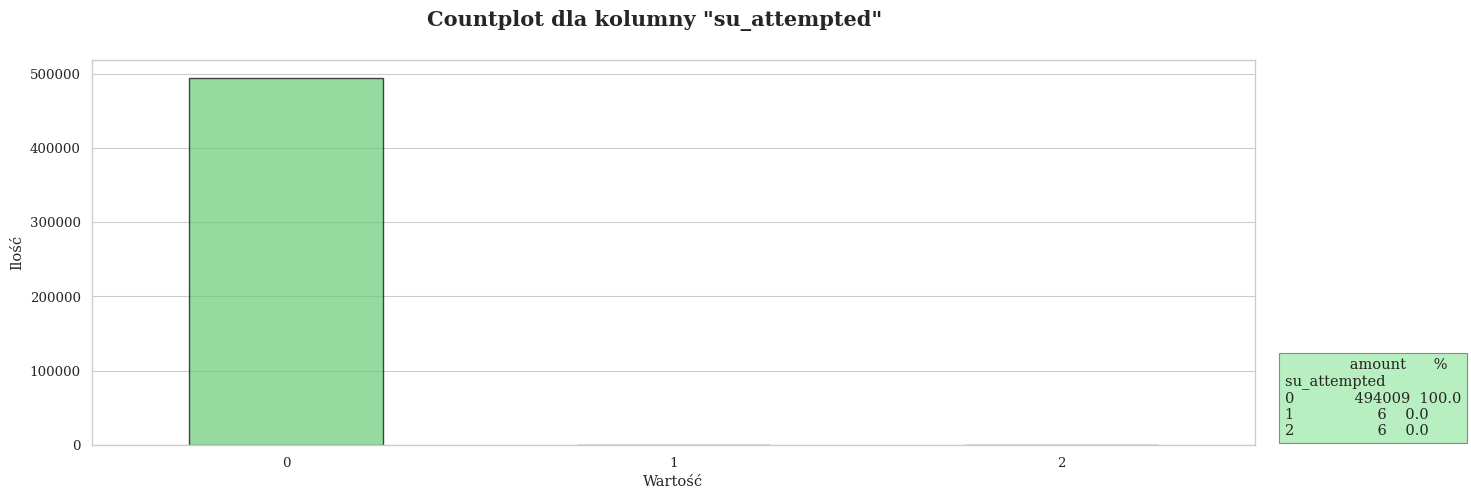

count  unique
su_attempted  494021       3

In [52]:
countplot(dfc['su_attempted'])

**su_attempted**- Zmienna przybiera 3 unikalne wartości- 0, 1 i 2. Wartością najczęściej wystepującą jest '0' (niemal 100 % przypadków). Wartości '1' i '2' występuje jedynie w 12 przypadkach. Kolumna nie wymaga kodowania, ale zostanie przekształcona z uwagi na fakt, że dopuszczalne są tylko 2 wartości- 0 i 1. Dane, które przybierają wartość 2 zostaną przekształcone do wartości równej 1.

In [53]:
countplot(dfc['is_guest_login'])

count  unique
is_guest_login  494021       2

**is_guest_login**- Zmienna przybiera 2 unikalne wartości- 0 i 1. Wartością najczęściej wystepującą jest '0' (99.9 % przypadków). Wartość '1' występuje jedynie w 685 przypadkach. Kolumna nie wymaga kodowania.

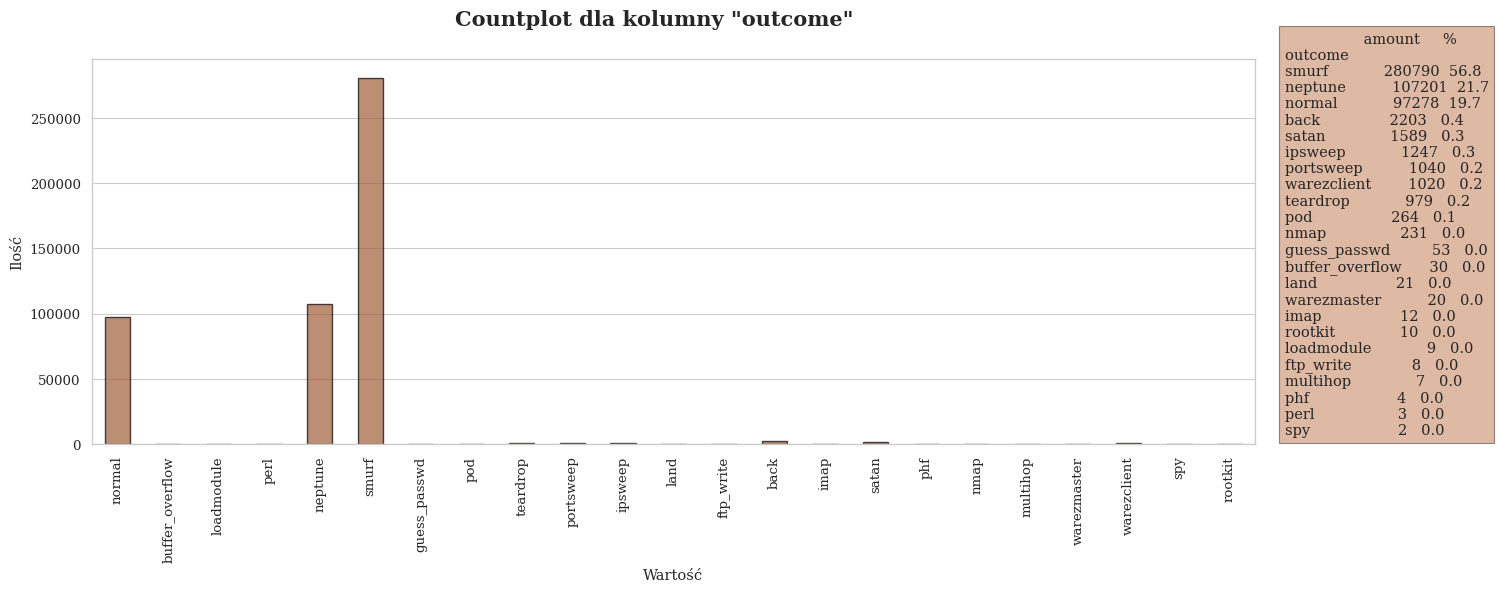

count  unique
outcome  494021      23

In [54]:
countplot(dfc['outcome'])

**outcome**- Zmienna celu. Zmienna przybiera 23 unikalne wartości. Wartością najczęściej wystepującą jest 'smurf' (56.8 % przypadków). Wartość 'normal' (ruch normalny) występuje w 19.7 % przypadkach. Kolumna wymaga zakodowania do postaci 0- ruch normalny i 1- atak.

## Podsumowanie

1. W celu poprawienia rozkładów, dane numeryczne zostaną przekształcone za pomocą PowerTransformer metodą "yeo-johnson".
2. Outlierów nie zawierają jedynie kolumny "count", "srv_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_same_src_port_rate". Dane w poszczególnych kolumnach są skoncentrowane w wartości skrajnej (0 lub 1) w ok. 90 % lub więcej, przez co wszystkie inne wartości są traktowane jako outliery. Z tego powodu dane zidentyfikowane jako outliery nie zostaną potraktowane jako wartości odstające.
3. Kolumny kategoryczne "protocol_type", "service" i "flag" wymagają zakodowania, z użyciem LabelEncoder.
4. Kolumna "su_attempted" przybiera 3 wartości (0, 1, 2), zamiast oczekiwanych dwóch (0, 1) i wymaga przekształcenia.
5. Kolumna "outcome" zostanie przekształcona do wartości 0- ruch normalny, 1- atak.

# Analiza bivariate

## Przygotowanie zbioru do analizy

### Przekształcenie kolumny "outcome" do postaci binarnej

In [55]:
dfc['outcome'] = dfc['outcome'].apply (lambda x: 0 if x == 'normal' else 1)
dfc['outcome'].unique()

array([0, 1])

### Przygotowanie funkcji tworzących wykresy

In [56]:
# funkcja tworząca barplot i wykres kde
def bar_kde(x):
    cols = 2
    rows = 1

    fig, axes = plt.subplots (nrows = rows,
                              ncols = cols,
                              figsize = (15, 5),
                              gridspec_kw = {'width_ratios': [1,2]}) #proporcje subplotów
    ax_bar = axes [0]
    ax_kde = axes [1]
    bar = sns.barplot (data = dfc, x = dfc['outcome'], y = x.name,
                       ax = ax_bar,
                       palette = [colors[x.name],
                                  colors['outcome']],
                       saturation = 0.5)

    bar.set_xticks ([0,1], labels = ['Normal', 'Anomaly'])

    # dodanie wartości średniej do barplotu
    for cont in bar.containers:
        bar.bar_label(cont, fmt='                %.3g', fontsize = 9)

    kde = sns.kdeplot(data = dfc, x = x.name,
                        hue = dfc['outcome'],
                        palette = [colors[x.name],
                                    colors['outcome']],
                        ax = ax_kde, fill = True,
                         alpha = 0.4)

    leg_kde = kde.get_legend()
    leg_kde.get_texts()[0].set_text("Normal")
    leg_kde.get_texts()[1].set_text("Anomaly")

    plt.suptitle (f"Kolumna \"{x.name}\" w odniesieniu do zmiennej celu \"outcome\"")
    plt.tight_layout()

plt.show()

In [57]:
def count(x):

    fig = plt.figure (figsize = (15, 6))

    count = sns.countplot(x = x,
                          palette = [colors[x.name], colors['outcome']],
                          hue = dfc['outcome'],
                          width = 0.5,
                          linewidth = 1,
                          alpha = 0.6,
                          edgecolor = 'black')

    leg_count = count.get_legend()
    leg_count.get_texts()[0].set_text("Normal")
    leg_count.get_texts()[1].set_text("Anomaly")

    for cont in count.containers:
        count.bar_label(cont, fontsize = 7.5) #dodanie wartości na słupkach

    plt.title (f"Kolumna \"{x.name}\" w odniesieniu do zmiennej celu",
              fontsize = 16,
               fontweight = "bold",
               fontname = 'serif', pad = 25)

    if len(x.unique()) >= 20:
        plt.xticks (rotation = 90)

    plt.tight_layout()

    plt.show()

## Dane ilościowe

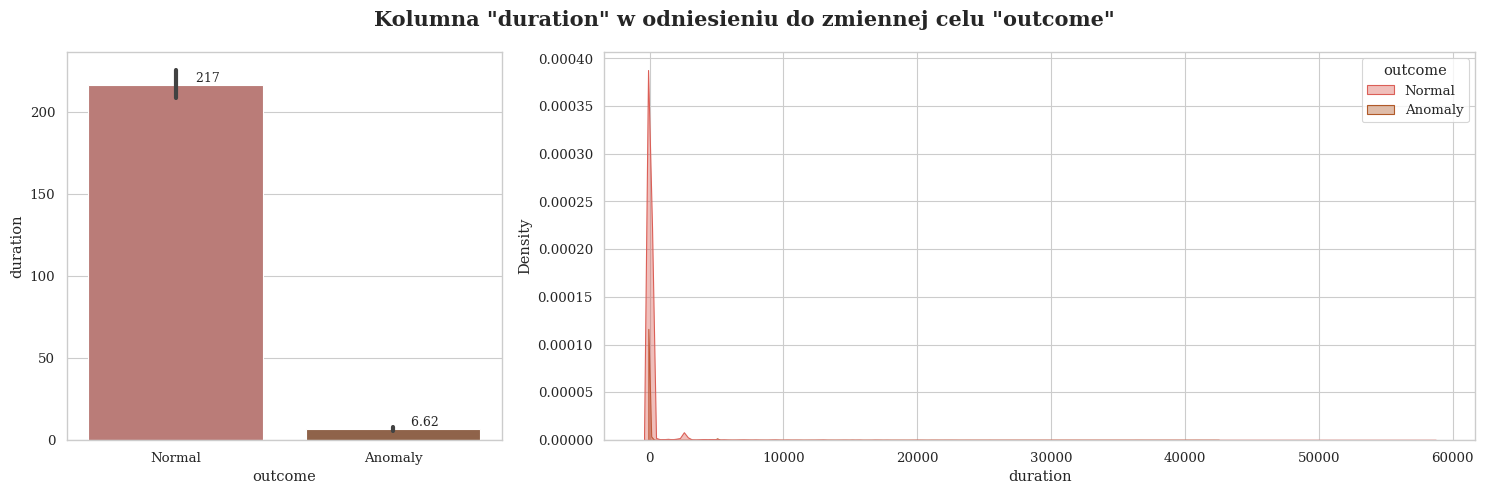

In [58]:
bar_kde(dfc['duration'])

**duration**- Przypadki "Normal" mają znacznie wyższą średnią wartość "duration" niż "Anomaly". Wartości "duration" są silnie skupione w okolicy zera. Różnica między klasami jest bardzo duża- "duration" może być istotną zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

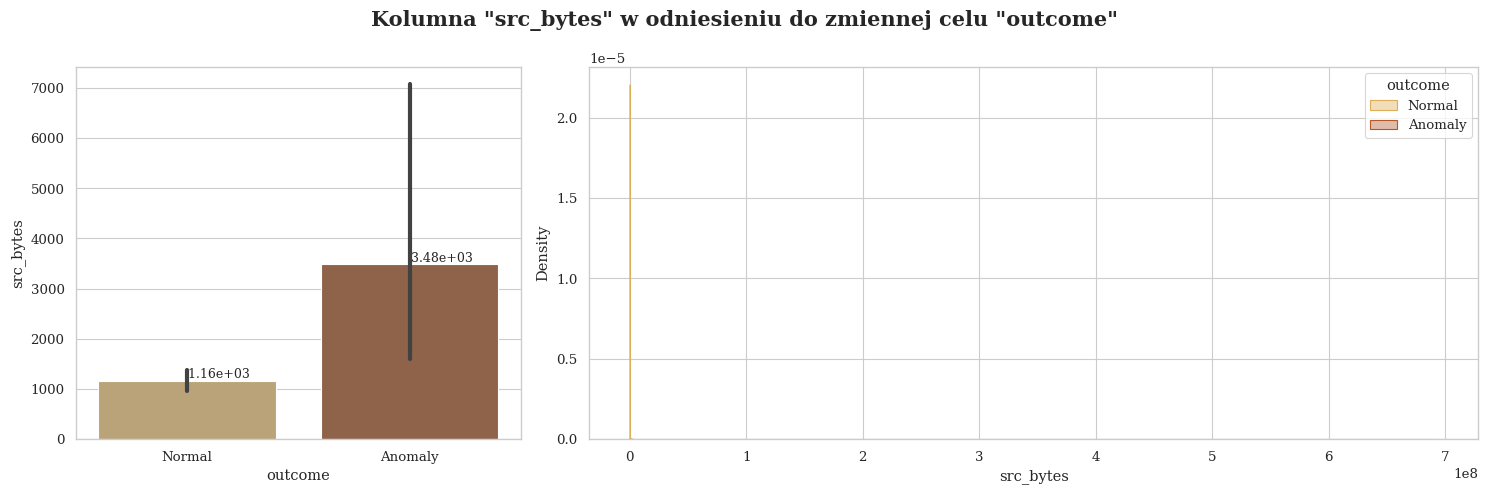

In [59]:
bar_kde(dfc['src_bytes'])

**src_bytes**- Średnia liczba bajtów wysyłanych przez źródło jest wyższa w przypadku anomalii, niż w przypadku ruchu normalnego. Długi słupek błędu sugeruje, że anomalie mogą mieć zarówno bardzo małe, jak i bardzo duże wartości. Większość wartości "src_bytes" jest zbliżona do zera. "src_bytes może być dobrym wskaźnikiem anomalii, gdyż przypadki anomalne mają znacznie wyższą średnią liczbę bajtów.

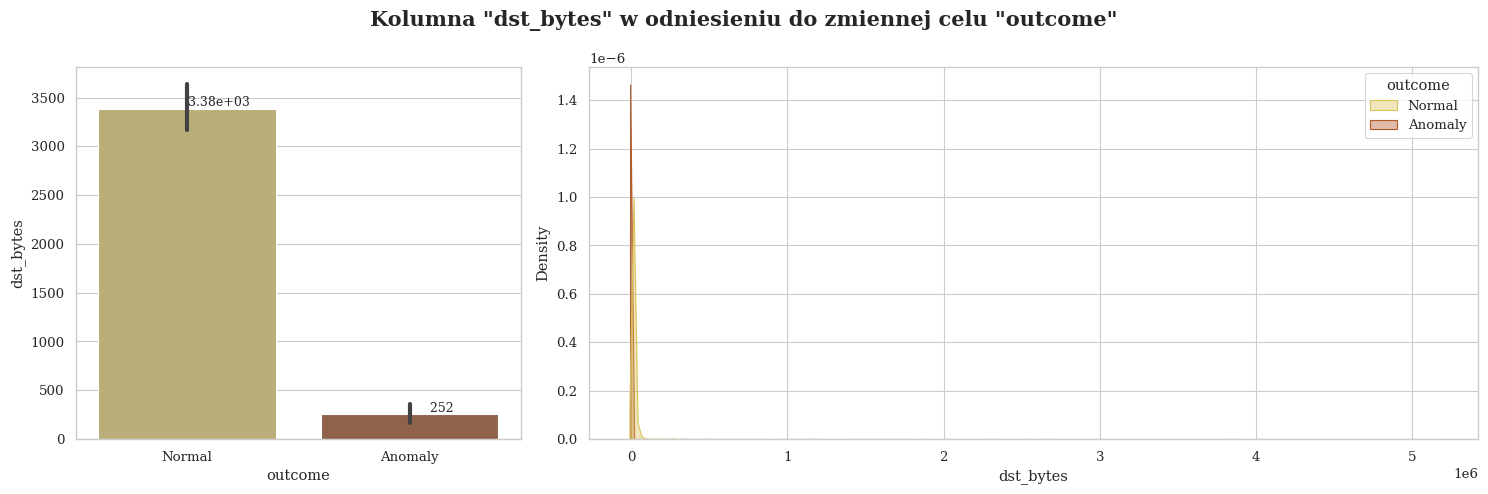

In [60]:
bar_kde(dfc['dst_bytes'])

**dst_bytes**- Średnia liczba bajtów odebranych przez cel jest wyższa w przypadku ruchu normalnego, niż w przypadku ruchu anomalii. Wartości dla anomalii są ograniczone i raczej niskie. Większość wartości "dst_bytes" jest zbliżona do zera. Kształt wykresu dla przypadków normalnych i anomalii jest dość podobny, przy czym anomalie mają mniejszy rozrzut. Wartośc"dst_bytes" może być istotnym wskaźnikiem anomalii, jeśli jest niska w porównaniu do wartości dla normalnych przypadków.

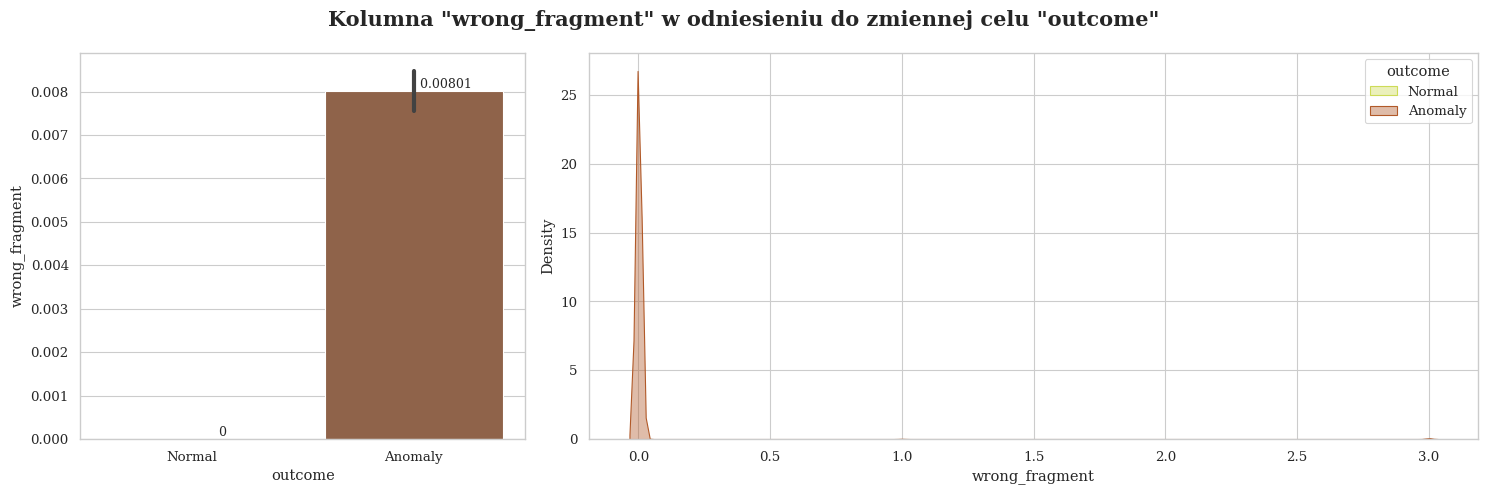

In [61]:
bar_kde(dfc['wrong_fragment'])

**wrong_fragment**- Błędne fragmenty pojawiają się tylko w anomalnych przypadkach. W normalnym ruchu nie występują w ogóle. Kolumna "wrong_fragment" jest istotnym predyktorem anomali.

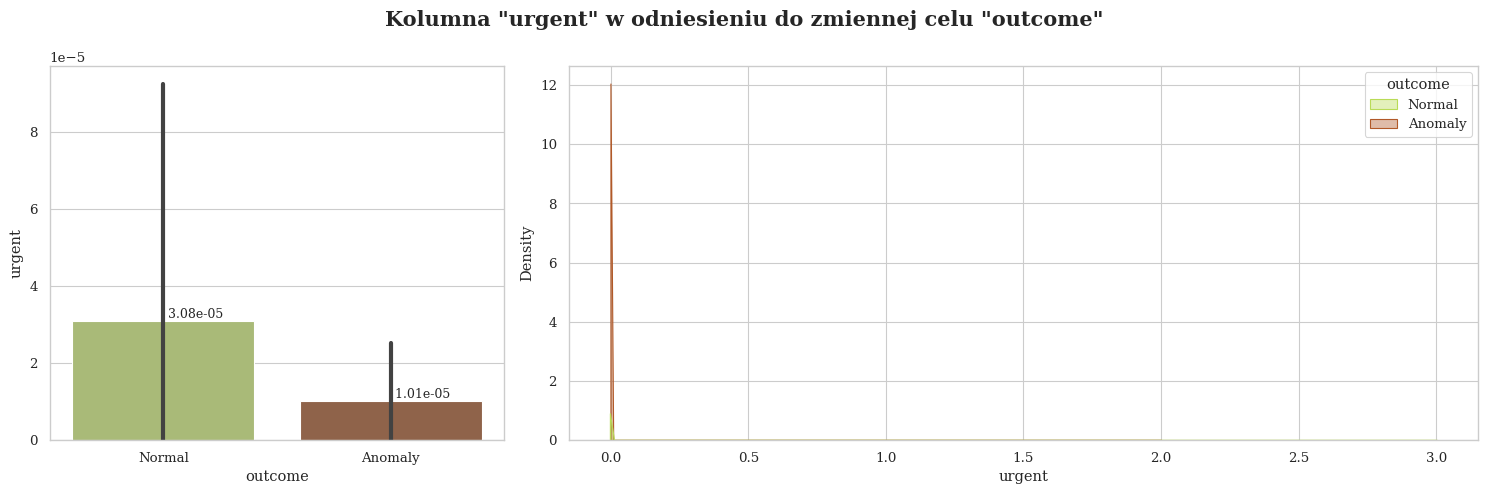

In [62]:
bar_kde(dfc['urgent'])

**urgent**- Przypadki "Normal" mają  wyższą średnią wartość "urgent" niż "Anomaly". Długie słupki błędów sugerują, że zarówno przypadki ruchu normalnego, jak i anomalie mogą mieć bardzo małe, jak i bardzo duże wartości. Wartości "urgent" są silnie skupione w okolicy zera. Różnice wartości między klasami może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

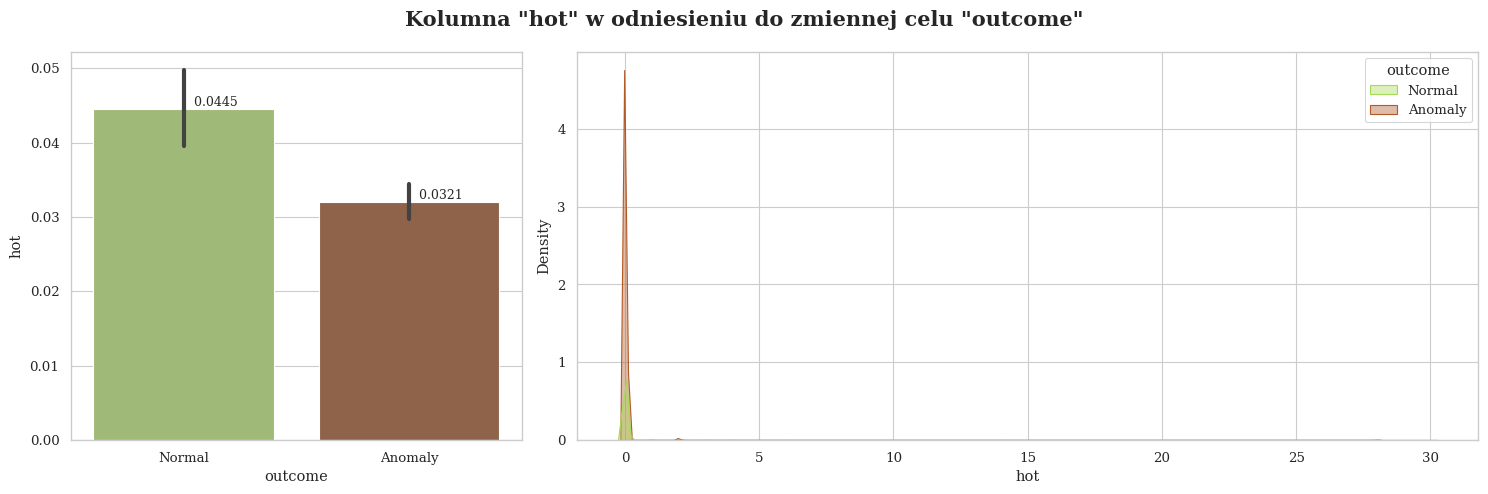

In [63]:
bar_kde(dfc['hot'])

**hot**- Przypadki "Normal" mają nieco wyższą średnią wartość niż "Anomaly". Wartości są silnie skupione w okolicy zera. Różnice wartości między klasami może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

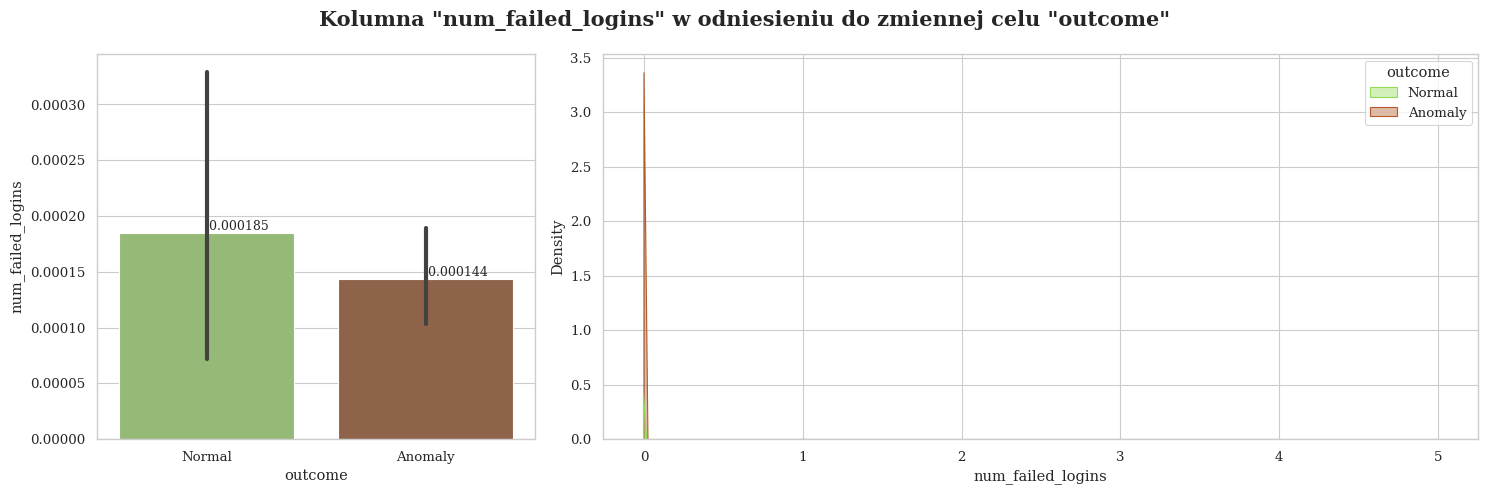

In [64]:
bar_kde(dfc['num_failed_logins'])

**num_failed_logins**- Przypadki "Normal" mają nieco wyższą średnią wartość niż "Anomaly". Długie słupki błędów sugerują, że zarówno przypadku ruchu normalnego, jak i anomalie mogą mieć bardzo małe, jak i bardzo duże wartości. Wartości są silnie skupione w okolicy zera. Różnice wartości między klasami może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

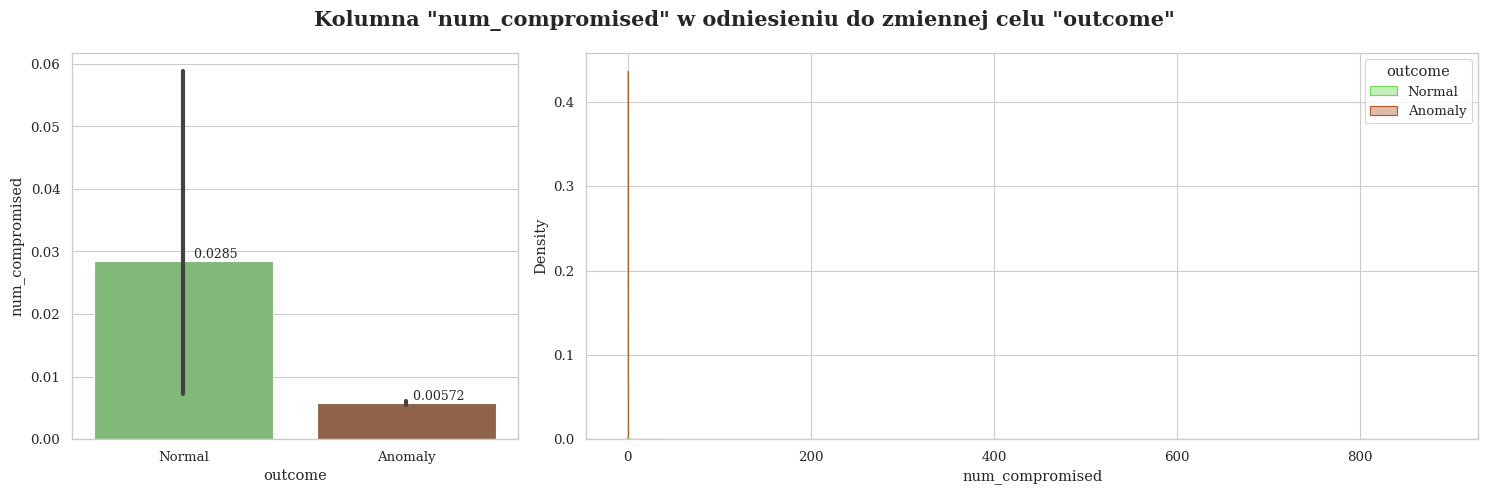

In [65]:
bar_kde(dfc['num_compromised'])

**num_compromised**- Przypadki "Normal" mają znacznie wyższą średnią wartość niż "Anomaly". Długi słupek błędu sugeruje, że w przypadku ruchu normalnego mogą mieć bardzo małe, jak i bardzo duże wartości. Wartości są silnie skupione w okolicy zera. Różnice wartości między klasami może być istotną zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

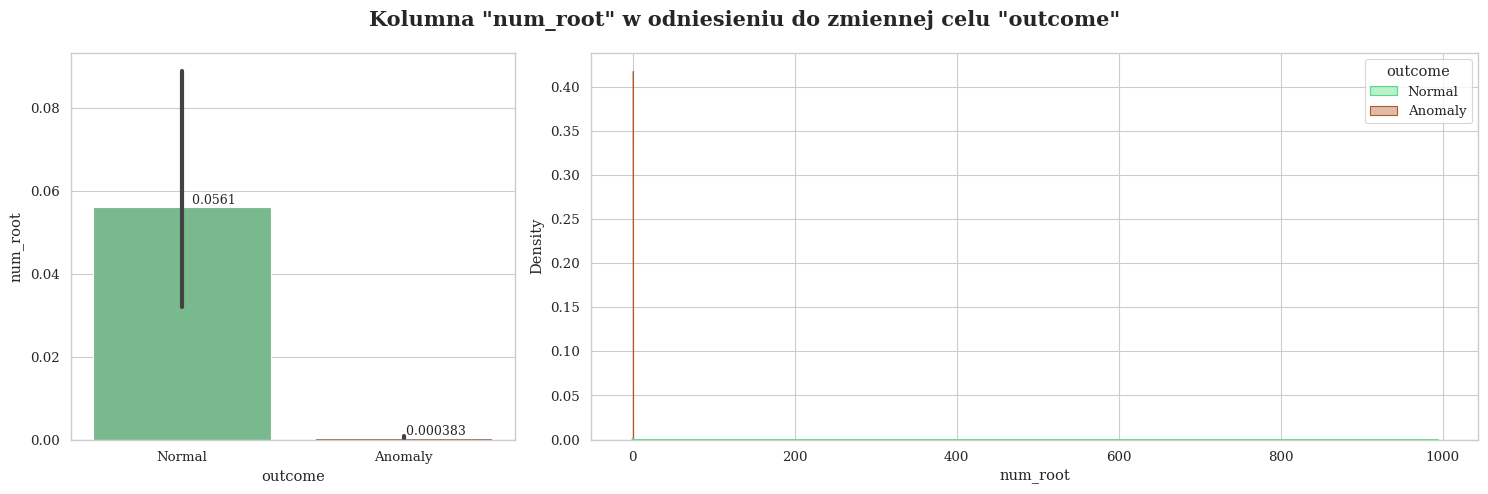

In [66]:
bar_kde(dfc['num_root'])

**num_root**- Przypadki "Normal" mają znacznie wyższą średnią wartość niż "Anomaly". Wartości anomalii są silnie skupione w okolicy zera. Różnica między klasami jest bardzo duża- "num_root" może być istotną zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

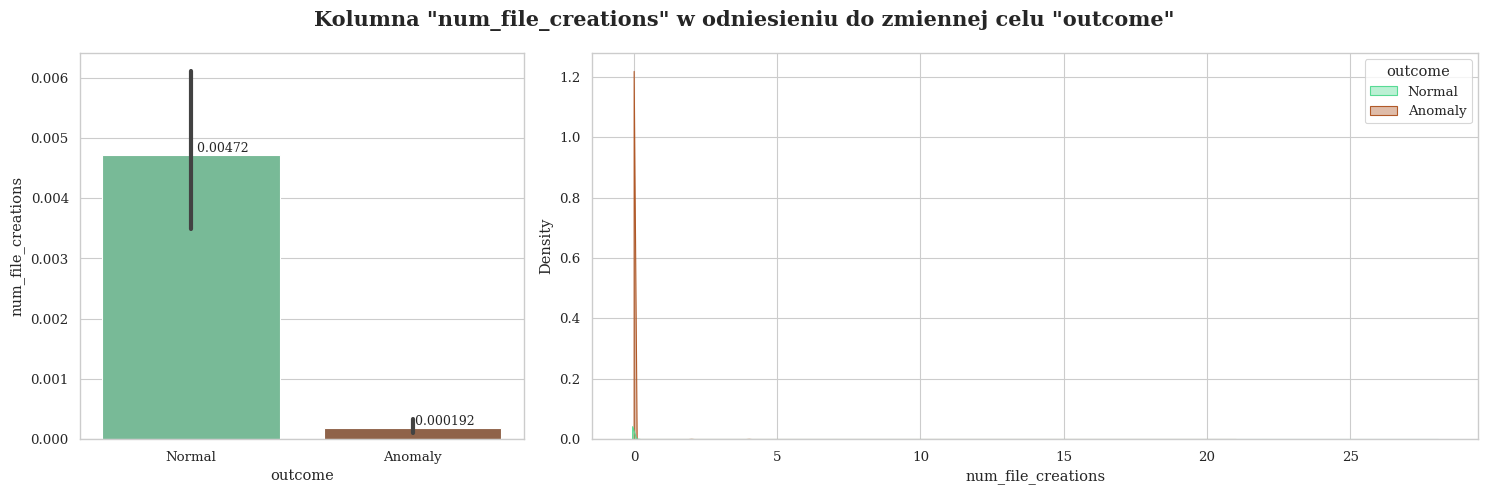

In [67]:
bar_kde(dfc['num_file_creations'])

**num_file_creations**- Przypadki "Normal" mają znacznie wyższą średnią wartość niż "Anomaly". Wartości są silnie skupione w okolicy zera. Różnica między klasami jest bardzo duża- "num_file_creation" może być istotną zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

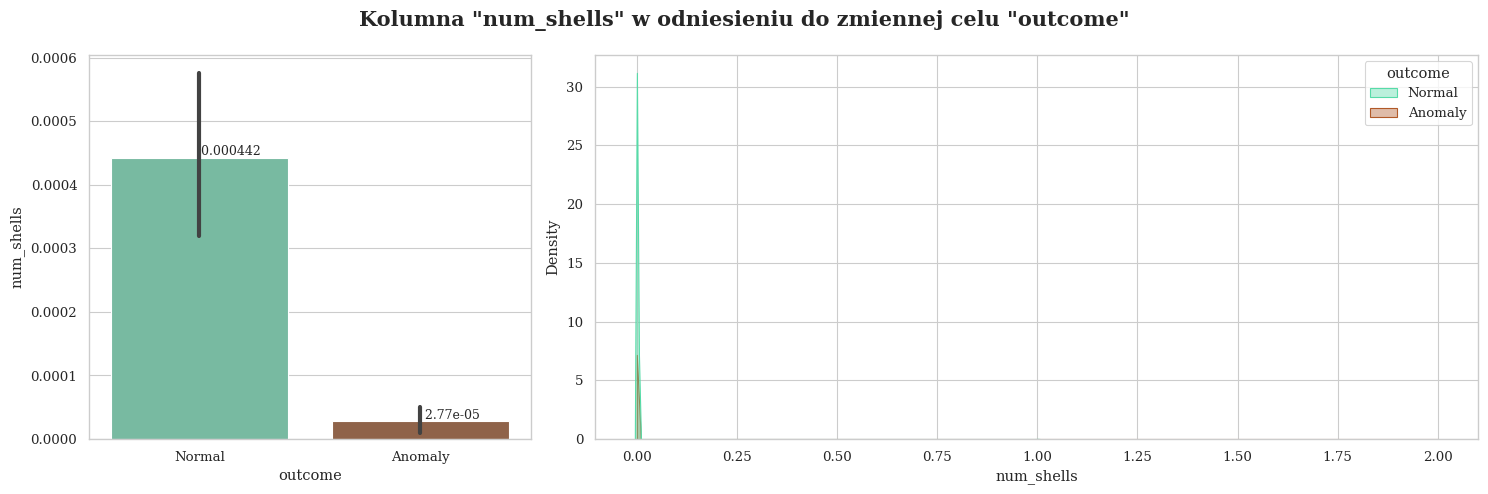

In [68]:
bar_kde(dfc['num_shells'])

**num_shells**- Przypadki "Normal" mają znacznie wyższą średnią wartość niż "Anomaly". Wartości są silnie skupione w okolicy zera. Różnica między klasami jest bardzo duża- "num_shells" może być istotną zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

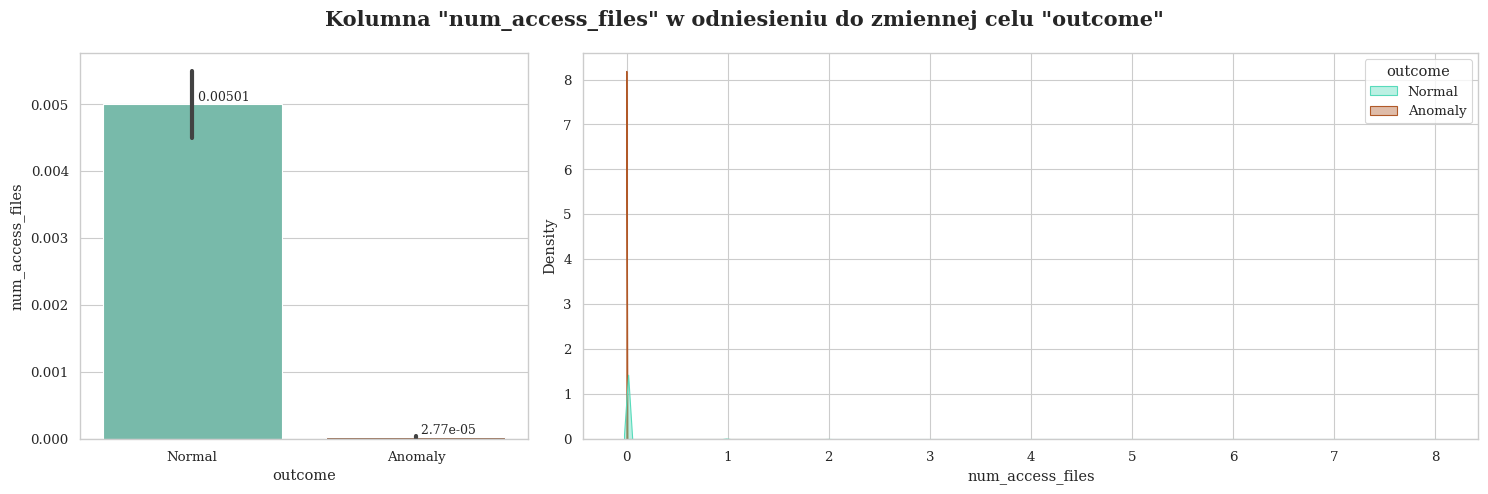

In [69]:
bar_kde(dfc['num_access_files'])

**num_access_files**- Przypadki "Normal" mają znacznie wyższą średnią wartość niż "Anomaly". Wartości są silnie skupione w okolicy zera. Różnica między klasami jest bardzo duża- "num_access_files" może być istotną zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

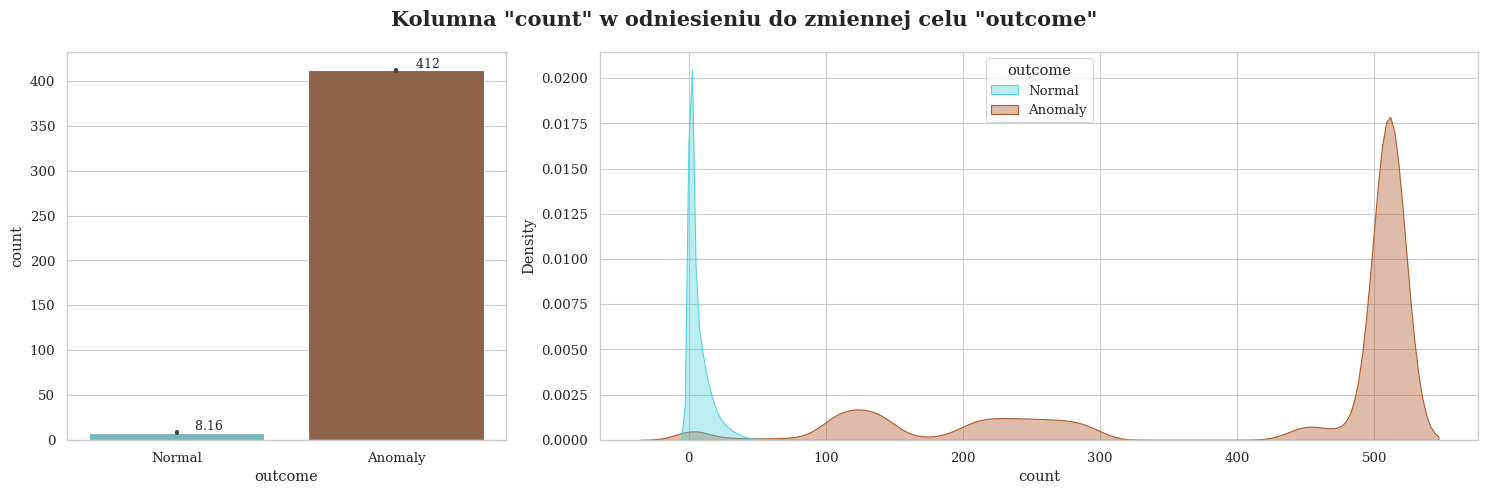

In [70]:
bar_kde(dfc['count'])

**count**- Przypadki "Anomaly" mają znacznie wyższą średnią wartość niż "Normal". Różnica między klasami jest bardzo duża. Z wykresu wynika, że wartości "Normal" są skupione w zakresie 0- 50, natomiast większość wartości "Anomaly" jest powyżej. "count" może być istotną zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

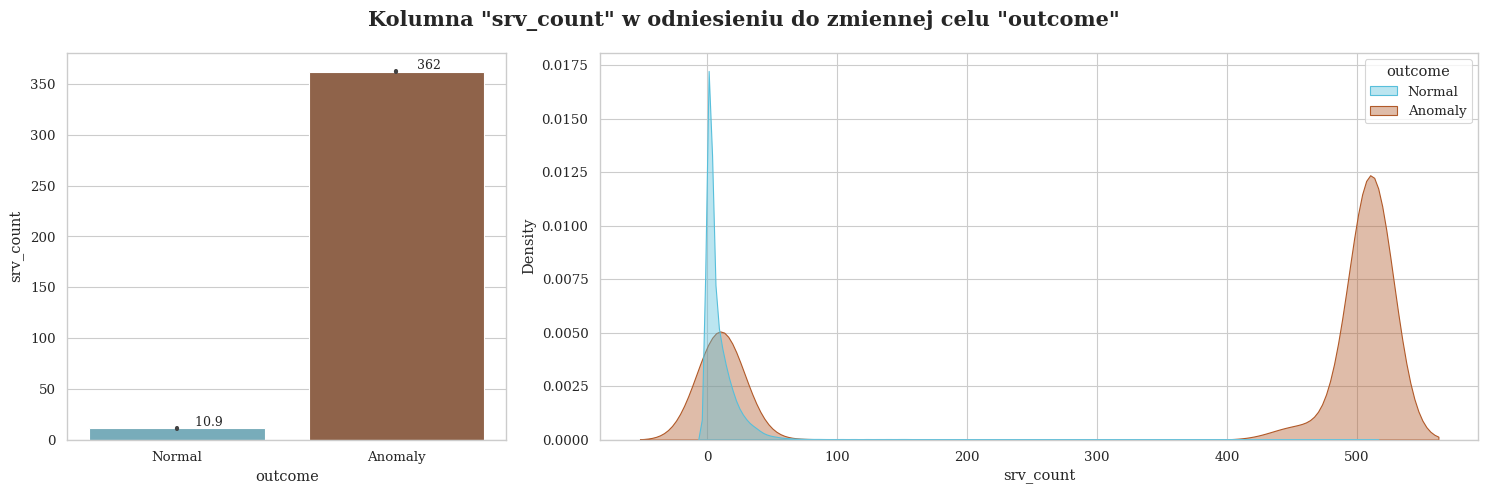

In [71]:
bar_kde(dfc['srv_count'])

**srv_count**- Przypadki "Anomaly" mają znacznie wyższą średnią wartość niż "Normal". Różnica między klasami jest bardzo duża. Z wykresu wynika, że wartości "Normal" są skupione w zakresie 0- 50, natomiast większość wartości "Anomaly" jest powyżej. "srv_count" może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

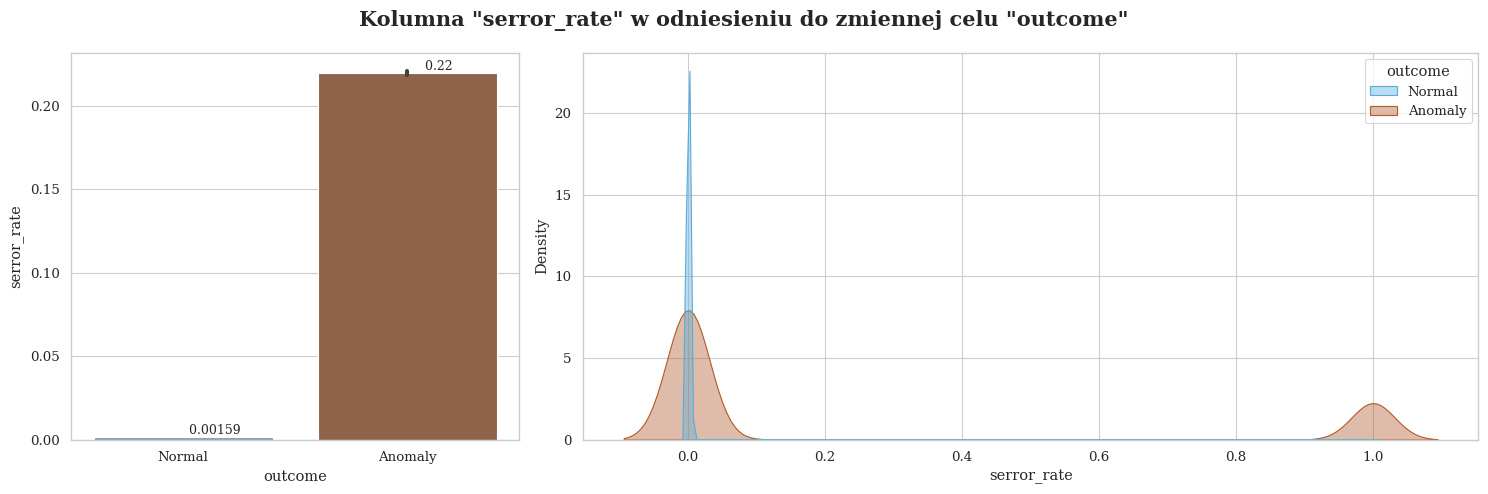

In [72]:
bar_kde(dfc['serror_rate'])

**serror_rate**- Przypadki "Anomaly" mają znacznie wyższą średnią wartość niż "Normal". Różnica między klasami jest bardzo duża. Z wykresu wynika, że wartości "Normal" są skupione w zakresie ściśle około 0, natomiast większość wartości "Anomaly" jest powyżej. "serror_rate" może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

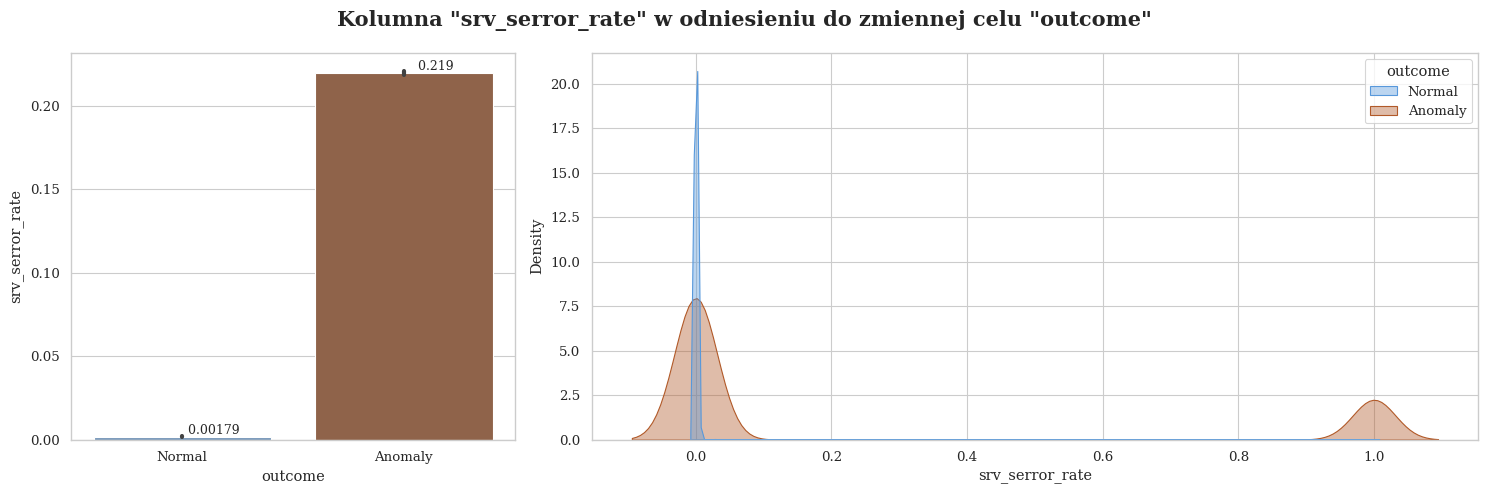

In [73]:
bar_kde(dfc['srv_serror_rate'])

**srv_serror_rate**- Rozkłady są bardzo zbliżone do rozkładów zmiennej **serror_rate**. Przypadki "Anomaly" mają znacznie wyższą średnią wartość niż "Normal". Różnica między klasami jest bardzo duża. Z wykresu wynika, że wartości "Normal" są skupione w zakresie ściśle około 0, natomiast większość wartości "Anomaly" jest powyżej. "srv_serror_rate" może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

In [74]:
bar_kde(dfc['rerror_rate'])

**rerror_rate**- Przypadki "Anomaly" mają bardzo podobną średnią wartość jak "Normal". Różnica między klasami jest bardzo mała. Z wykresu wynika, że wartości "Normal" i "Anomaly" są skupione w podobnych zakresach. "rerror_rate" niewiele wnosi jako zmienna pozwalającą odróżnić anomalie od ruchu normalnego, jednak może być przydatna w połączeniu z innymi zmiennymi.

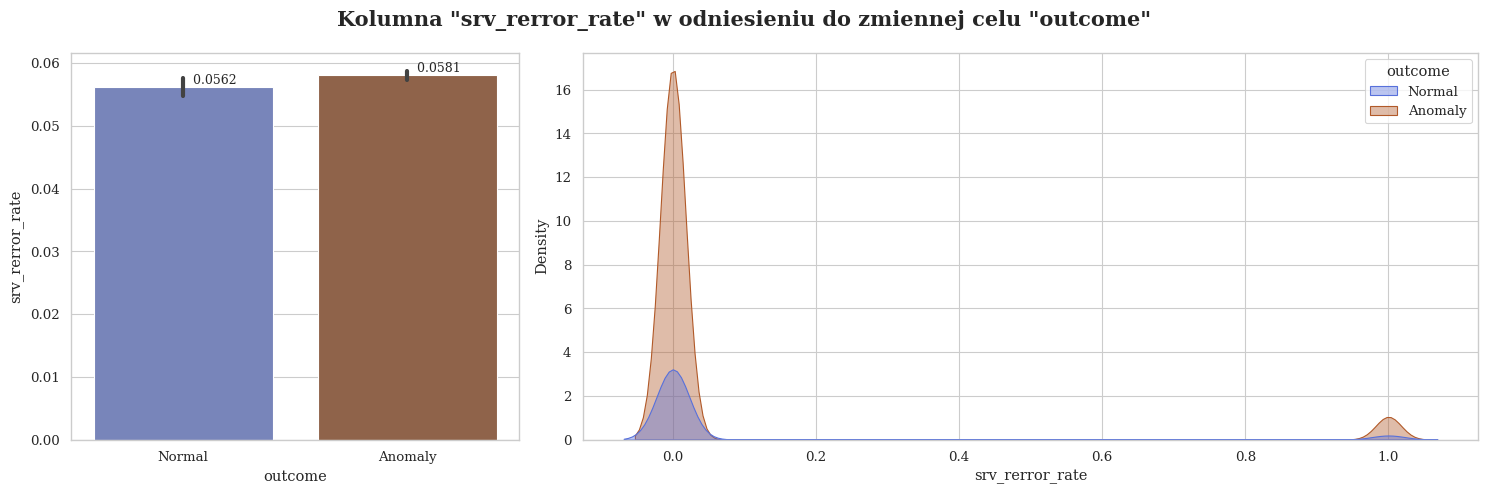

In [75]:
bar_kde(dfc['srv_rerror_rate'])

**srv_rerror_rate**- Przypadki "Anomaly" mają bardzo podobną średnią wartość jak "Normal". Różnica między klasami jest bardzo mała. Z wykresu wynika, że wartości "Normal" i "Anomaly są skupione w podobnych zakresach. "srv_rerror_rate" niewiele wnosi jako zmienna pozwalającą odróżnić anomalie od ruchu normalnego, jednak może być przydatna w połączeniu z innymi zmiennymi.

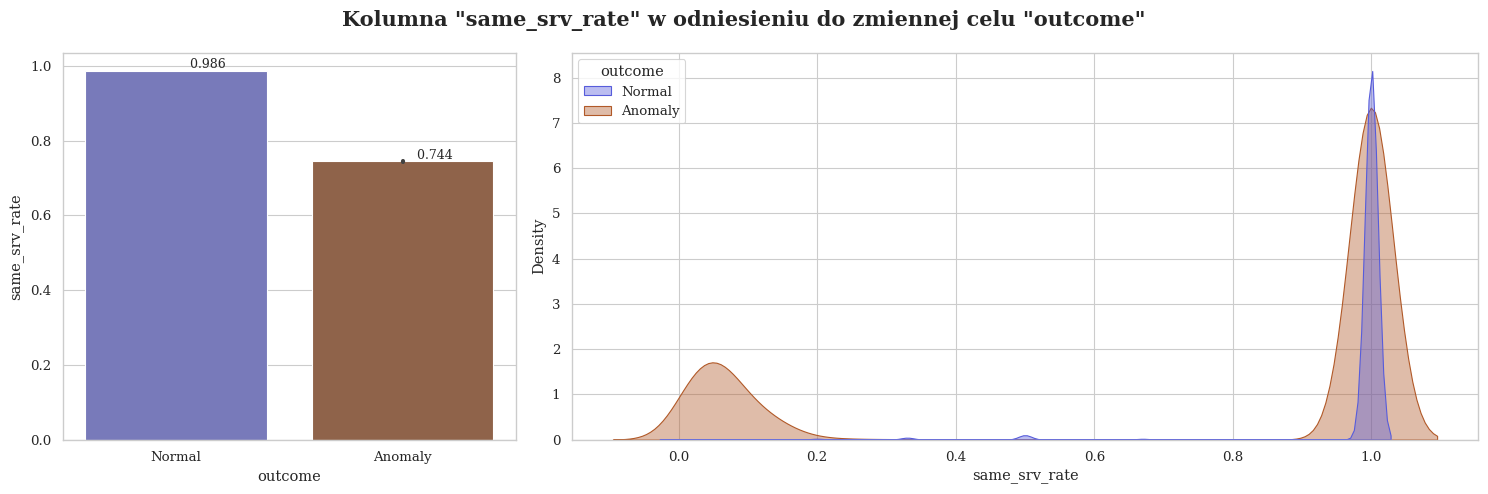

In [76]:
bar_kde(dfc['same_srv_rate'])

**same_srv_rate**- Przypadki "Normal" mają wyższą średnią wartość niż "Anomaly". Różnica między klasami jest niezbyt duża. Z wykresu wynika, że wartości "Normal" są skupione w zakresie około 1, natomiast część wartości "Anomaly" jest skupiona w okolicach 0.05. "same_srv_rate" może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

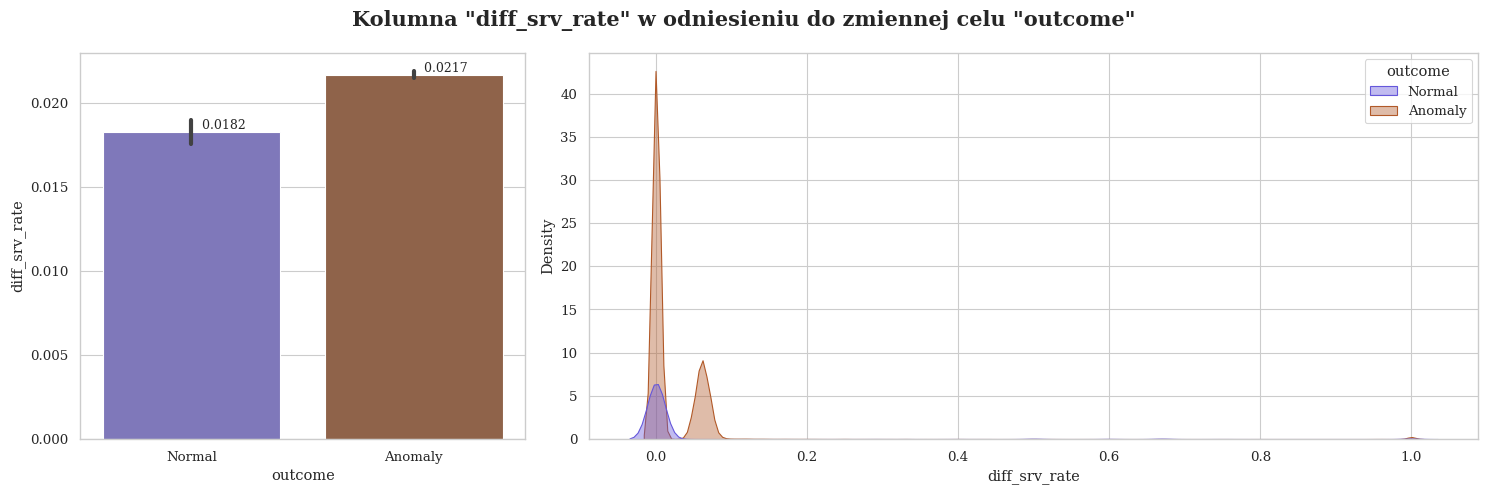

In [77]:
bar_kde(dfc['diff_srv_rate'])

**diff_srv_rate**- Przypadki "Normal" mają niższą średnią wartość niż "Anomaly". Różnica między klasami jest niezbyt duża. Z wykresu wynika, że wartości "Normal" są skupione w zakresie około 0, natomiast część wartości "Anomaly" znajduje się powyżej . "diff_srv_rate" może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

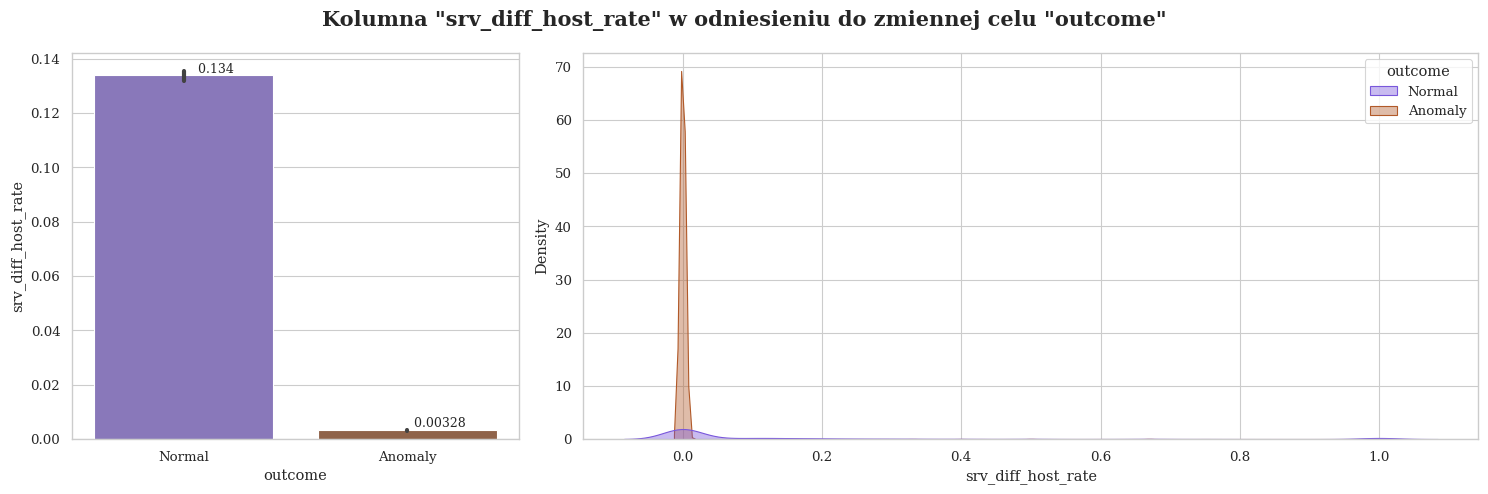

In [78]:
bar_kde(dfc['srv_diff_host_rate'])

**srv_diff_host_rate**- Przypadki "Normal" mają znacznie wyższą średnią wartość niż "Anomaly". Różnica między klasami jest bardzo duża. Z wykresu wynika, że wartości "Anomaly" są skupione w zakresie ściśle około 0, natomiast część wartości "Normal" znajduje się w okolicy 1. "srv_diff_host_rate" może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

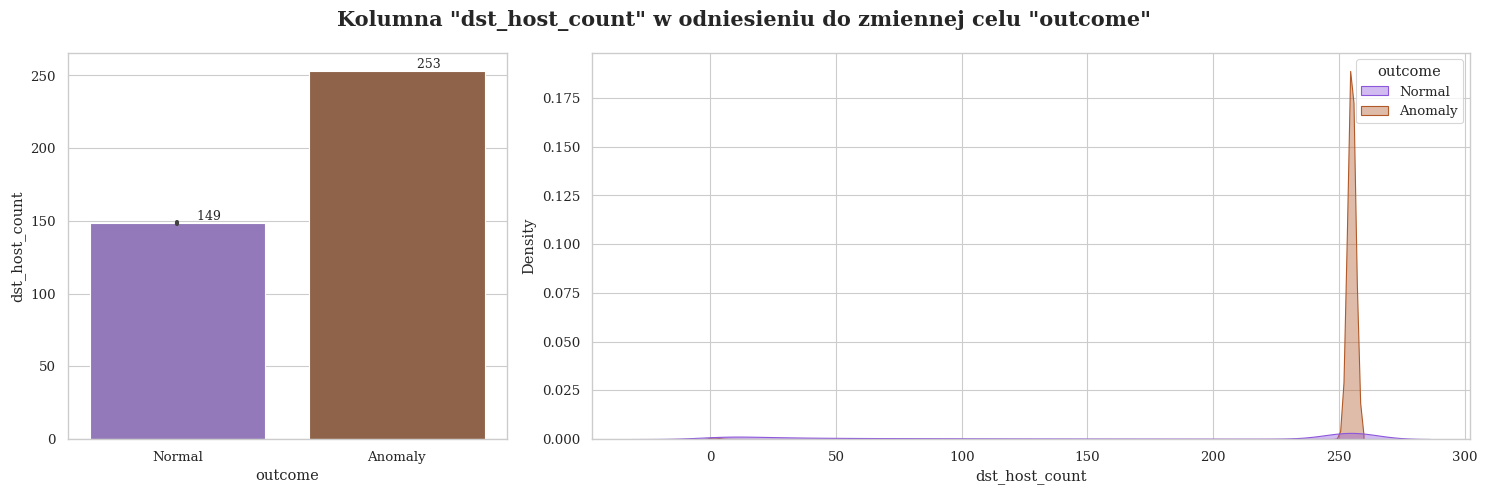

In [79]:
bar_kde(dfc['dst_host_count'])

**dst_host_count**- Przypadki "Anomaly" mają znacznie wyższą średnią wartość niż "Normal". Różnica między klasami jest dość duża. Z wykresu wynika, że wartości gęstości "Anomaly" są skupione w zakresie ściśle około 1, natomiast część rozkładu gęstości "Normal" znajduje się w okolicy lewego skraju rozkładu. "dst_host_count" może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

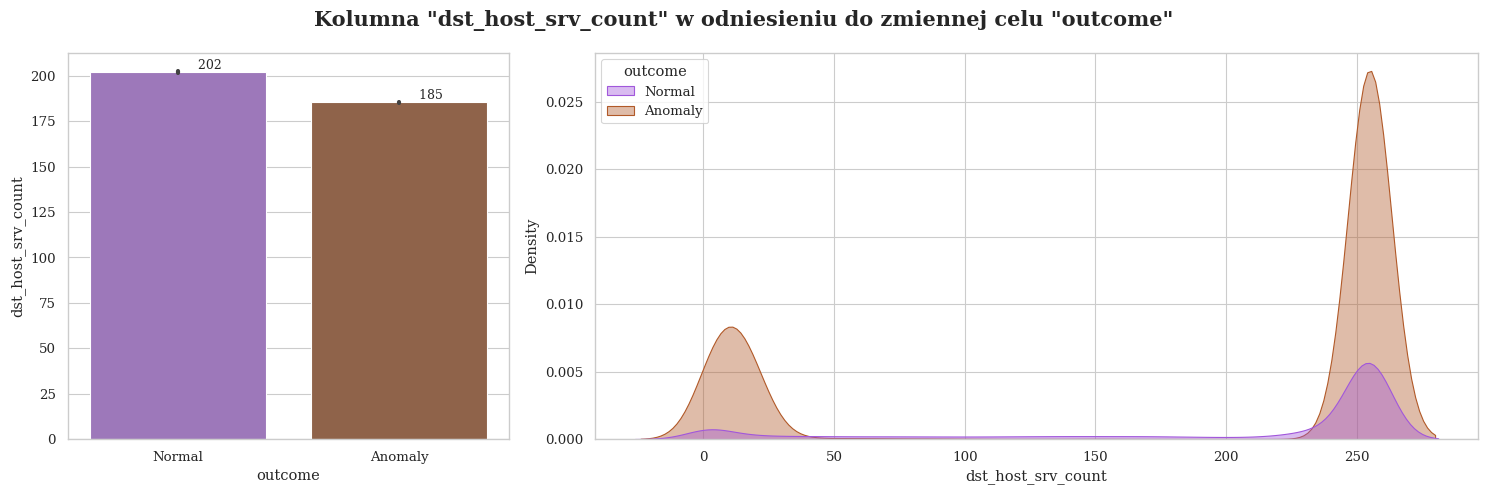

In [80]:
bar_kde(dfc['dst_host_srv_count'])

**dst_host_srv_count**- Przypadki "Normal" mają niewiele wyższą średnią wartość niż "Anomaly". Różnica między klasami jest dość mała. Z wykresu wynika, że wartości "Anomaly" i "Normal" są skupione w zakresie  około 0 i 1, przy czym część wartości "Anomaly" w okolicy lewego skraju rozkładu przybiera nieco wyższe wartości gęstości. "dst_host_srv_count" może być zmienną pozwalającą częściowo odróżnić anomalie od ruchu normalnego.

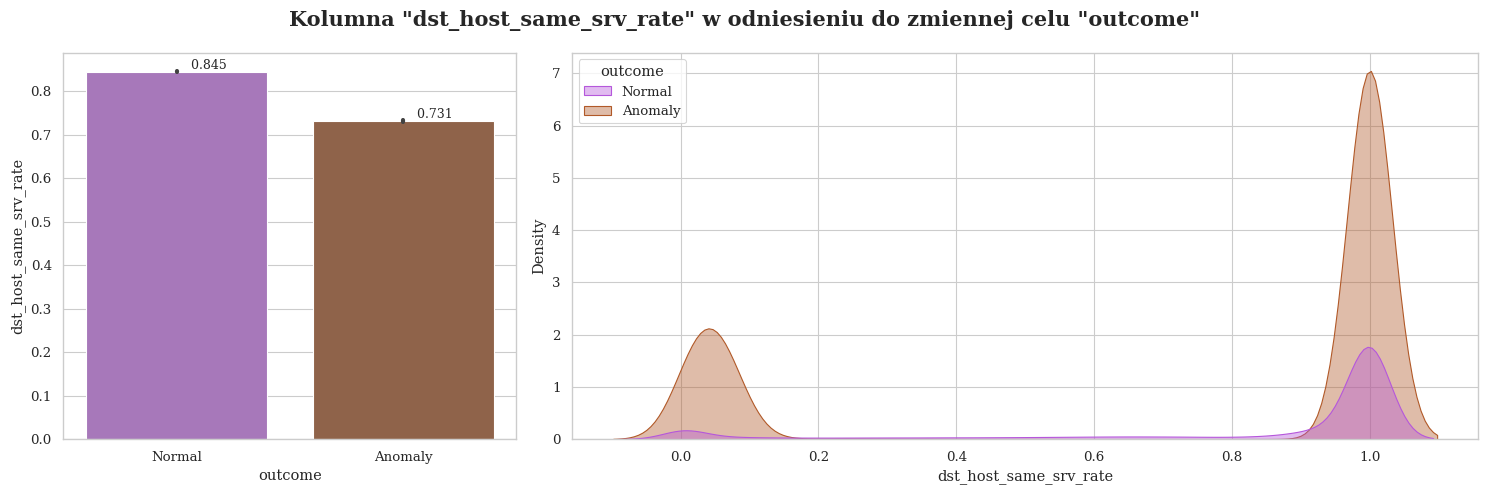

In [81]:
bar_kde(dfc['dst_host_same_srv_rate'])

**dst_host_same_srv_rate**- Przypadki "Normal" mają nieco wyższą średnią wartość niż "Anomaly". Różnica między klasami jest dość mała. Z wykresu wynika, że wartości "Anomaly" i "Normal" są skupione w zakresie  około wartości 0 i 1, przy czym "Anomaly" w okolicy lewego skraju rozkładu przybiera nieco wyższe wartości gęstości. "dst_host_same_srv_rate" może być zmienną pozwalającą częściowo odróżnić anomalie od ruchu normalnego.

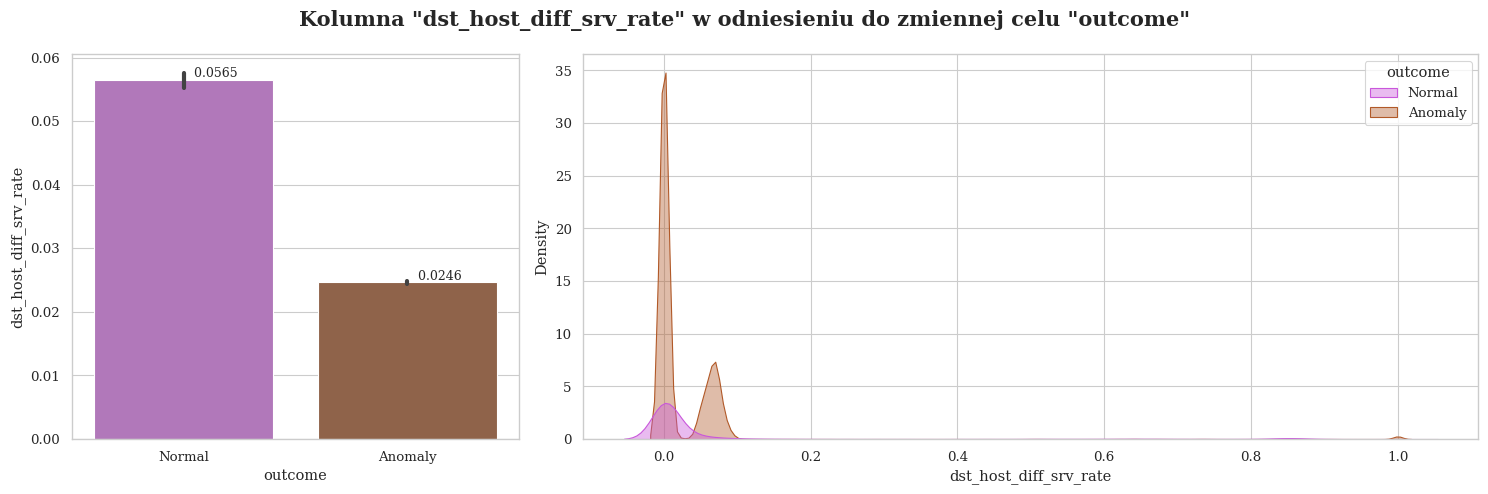

In [82]:
bar_kde(dfc['dst_host_diff_srv_rate'])

**dst_host_diff_srv_rate**- Przypadki "Normal" mają wyższą średnią wartość niż "Anomaly". Różnica między klasami jest dość duża. Z wykresu wynika, że wartości "Normal" są skupione w zakresie  około wartości 0 z dość dużym rozrzutem. Część wartości "Anomaly" w okolicy lewego skraju rozkładu przybiera nieco wyższe wartości gęstości. "dst_host_diff_srv_rate" może być zmienną pozwalającą częściowo odróżnić anomalie od ruchu normalnego.

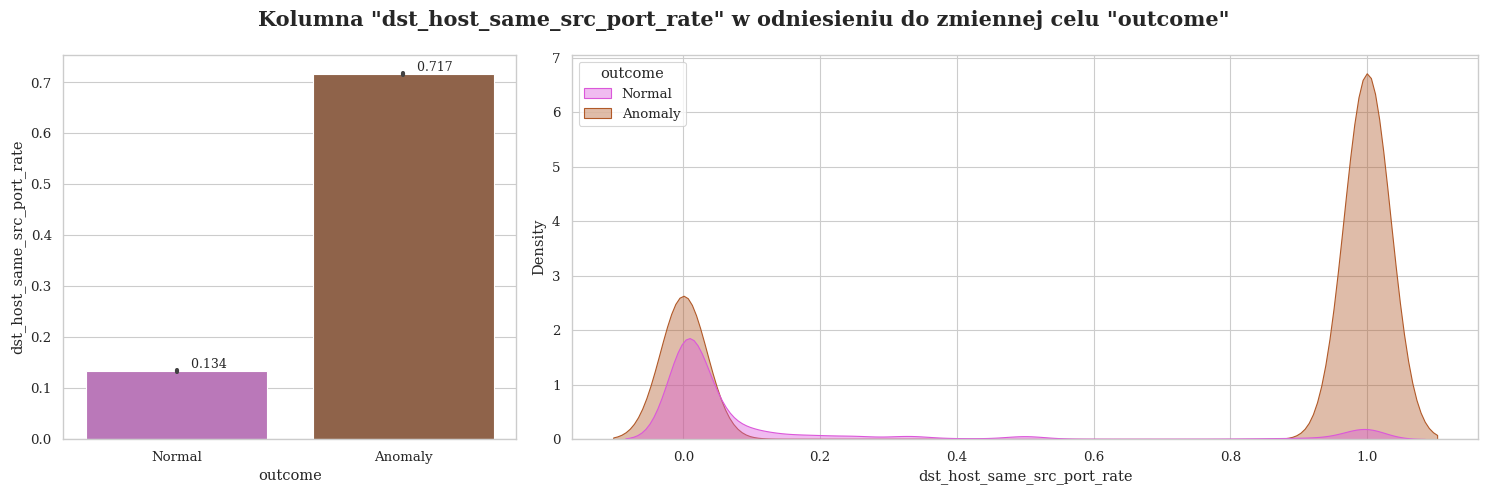

In [83]:
bar_kde(dfc['dst_host_same_src_port_rate'])

**dst_host_same_src_port_rate**- Przypadki "Normal" mają znacznie niższą średnią wartość niż "Anomaly". Różnica między klasami jest dość duża. Z wykresu wynika, że wartości "Normal" i "Anomaly" są częściowo skupione w zakresie  około wartości 0 z dość dużym rozrzutem. Część wartości "Anomaly" w okolicy prawego skraju rozkładu przybiera nieco wyższe wartości gęstości. "dst_host_same_src_port_rate" może być zmienną pozwalającą częściowo odróżnić anomalie od ruchu normalnego.

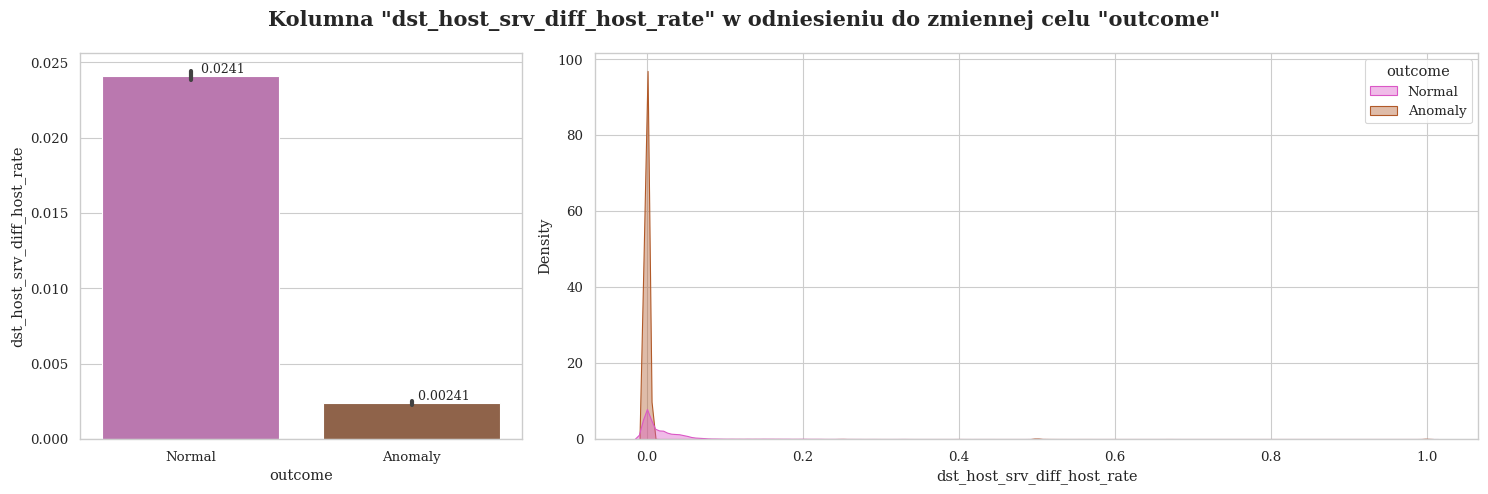

In [84]:
bar_kde(dfc['dst_host_srv_diff_host_rate'])

**dst_host_srv_diff_host_rate**- Przypadki "Normal" mają znacznie wyższą średnią wartość niż "Anomaly". Różnica między klasami jest dość duża. Z wykresu wynika, że wartości "Normal" i "Anomaly" są skupione w zakresie  około wartości 0, przy czym "Normal" z dość dużym rozrzutem. "dst_host_srv_diff_host_rate" może być zmienną pozwalającą częściowo odróżnić anomalie od ruchu normalnego.

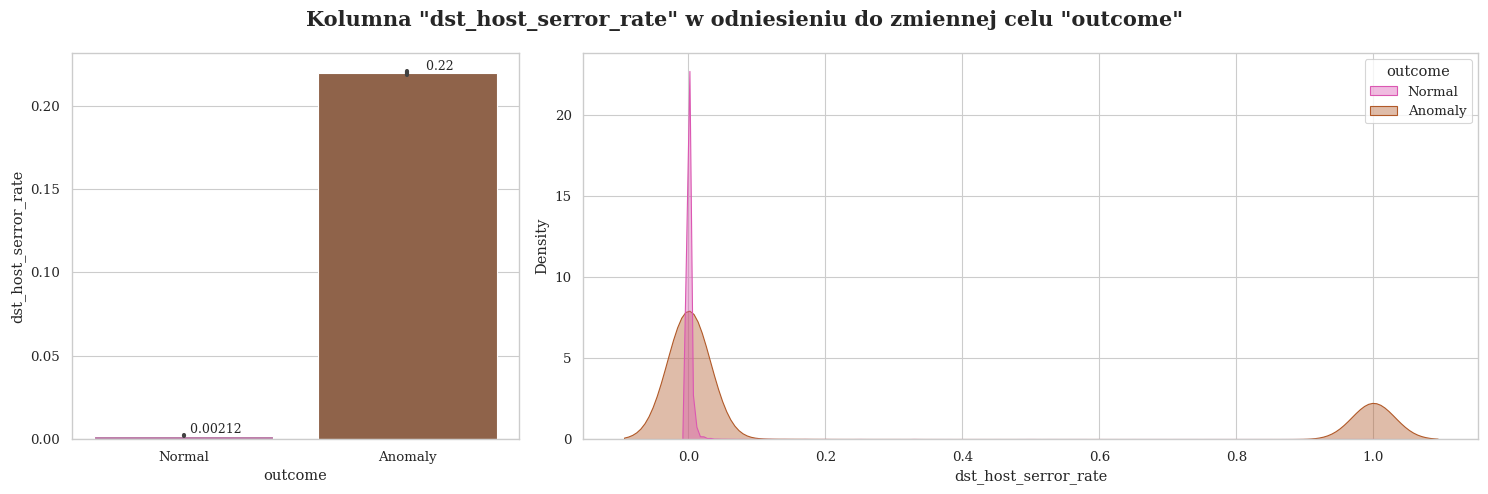

In [85]:
bar_kde(dfc['dst_host_serror_rate'])

**dst_host_serror_rate**- Przypadki "Normal" mają znacznie niższą średnią wartość niż "Anomaly". Różnica między klasami jest dość duża. Z wykresu wynika, że wartości "Normal" i "Anomaly" są skupione w zakresie  około wartości 0, przy czym "Anomaly" z dość dużym rozrzutem. Ponadto "Anomaly" wykazuje skupienie wokół wartości 1. "dst_host_serror_rate" może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

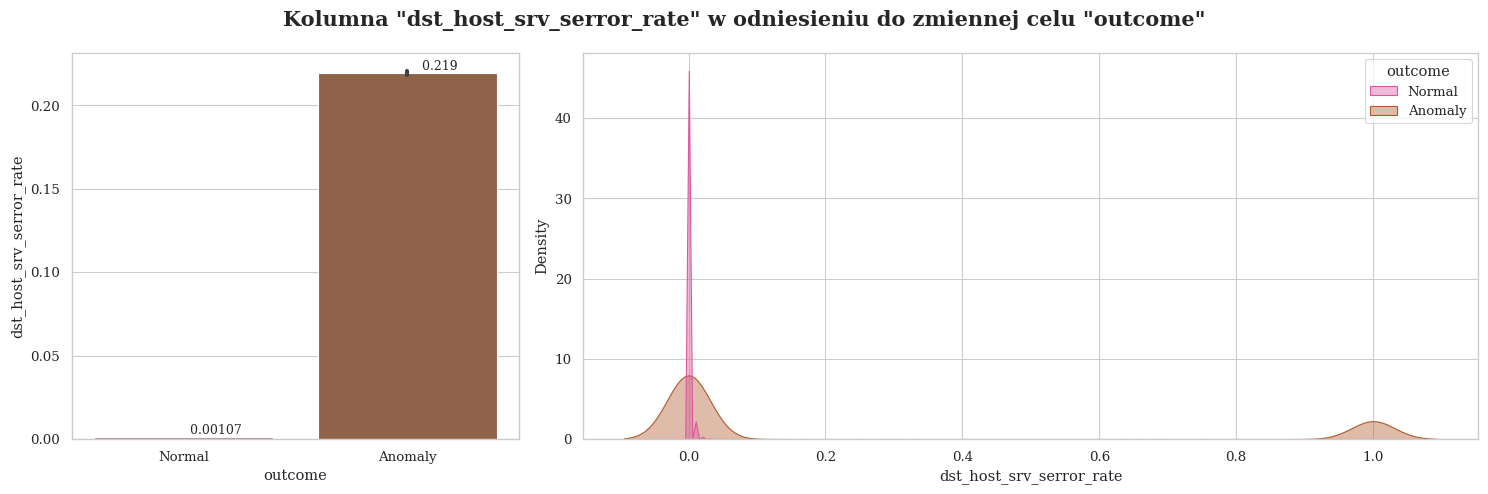

In [86]:
bar_kde(dfc['dst_host_srv_serror_rate'])

**dst_host_srv_serror_rate**- Przypadki "Normal" mają znacznie niższą średnią wartość niż "Anomaly". Różnica między klasami jest dość duża. Z wykresu wynika, że wartości "Normal" i "Anomaly" są skupione w zakresie  około wartości 0, przy czym "Anomaly" z dość dużym rozrzutem. Ponadto "Anomaly" wykazuje skupienie wokół wartości 1. "dst_host_srv_serror_rate" może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

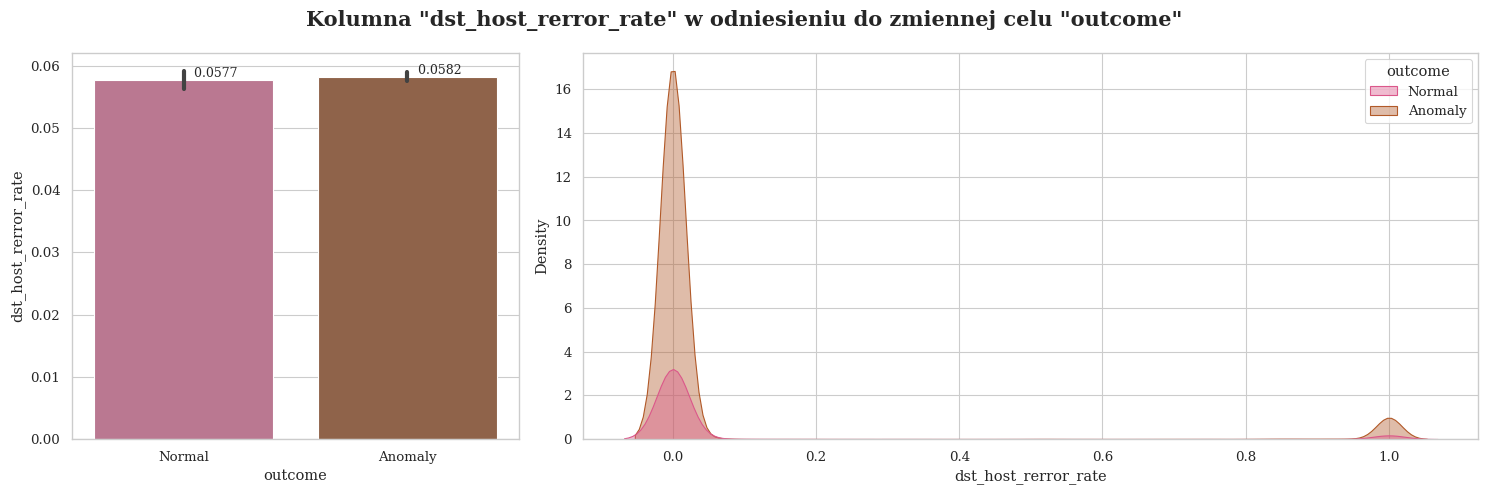

In [87]:
bar_kde(dfc['dst_host_rerror_rate'])

**dst_host_rerror_rate**- Przypadki "Anomaly" mają bardzo podobną średnią wartość jak "Normal". Różnica między klasami jest bardzo mała. Z wykresu wynika, że wartości "Normal" i "Anomaly są skupione w podobnych zakresach. "dst_host_rerror_rate" niewiele wnosi jako zmienna pozwalającą odróżnić anomalie od ruchu normalnego, jednak może być przydatna w połączeniu z innymi zmiennymi.

In [88]:
bar_kde(dfc['dst_host_srv_rerror_rate'])

**dst_host_srv_rerror_rate**- Przypadki "Anomaly" mają bardzo podobną średnią wartość jak "Normal". Różnica między klasami jest bardzo mała. Z wykresu wynika, że wartości "Normal" i "Anomaly są skupione w podobnych zakresach. "dst_host_srv_rerror_rate" niewiele wnosi jako zmienna pozwalającą odróżnić anomalie od ruchu normalnego, jednak może być przydatna w połączeniu z innymi zmiennymi.

## Dane kategoryczne

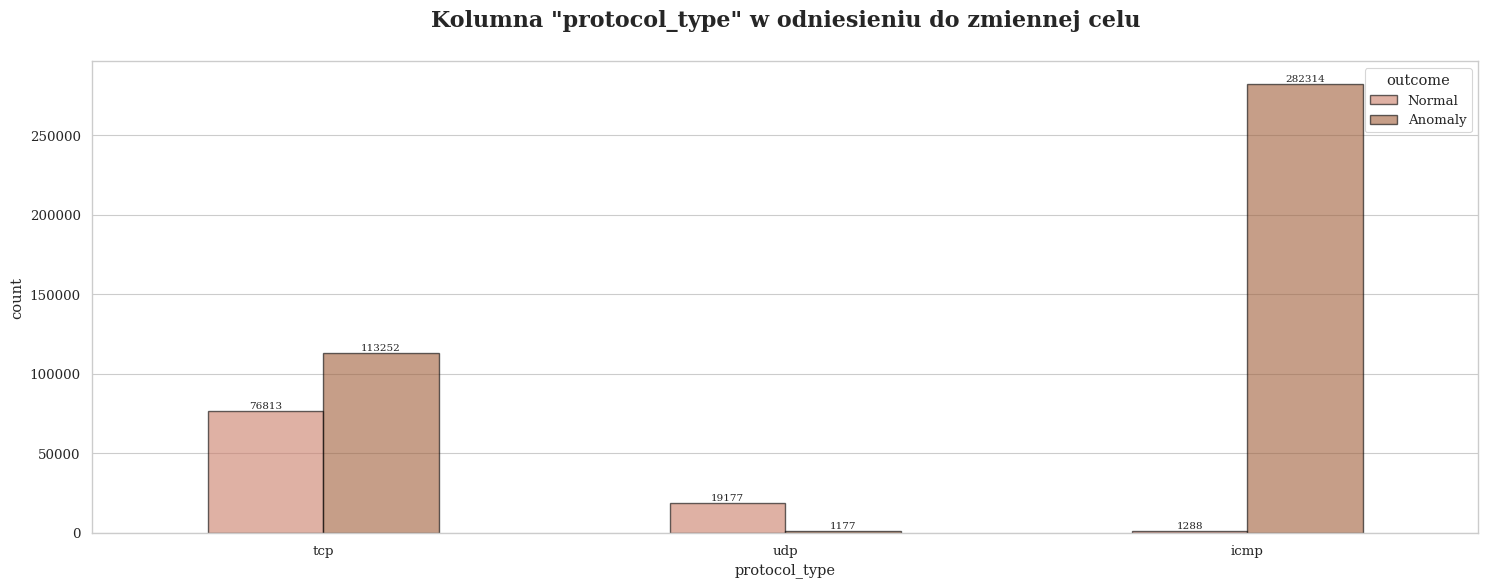

In [89]:
count(dfc['protocol_type'])

**protocol_type**- Połączenia z użyciem protokołu "udp" są charakterystyczne dla ruchu normalnego, natomiast "icmp"- dla anomalii. "protocol_type" może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

In [90]:
count(dfc['service'])

**service**- Usługi sieciowe jak "http', "smtp" czy "domain_u" są charakterystyczne dla ruchu normalnego. Z kolei "ecr_i", czy "private" są specyficzne dla ruchu anomalnego. "service" może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

In [91]:
count(dfc['flag'])

**flag**- Teoretycznie wartość "SF" odpowiada ruchowi normalnemu, jednak jak wynika z wykresu, większość flag "SF" wskazuje anomalie. Pozostałe wartości, w tym najczęściej reprezentowane "REJ", "S0" są wskaźnikami anomalii. "flag"  może być zmienną pomagającą odróżnić anomalie od ruchu normalnego.

In [92]:
count(dfc['land'])

**land**- Przyjmuje wartości 0, 1. Większość w obu kolumnach stanowią anomalie. "land" w połączeniu z innymi zmiennymi, potencjalnie może być zmienną pomagającą odróżnić anomalie od ruchu normalnego.

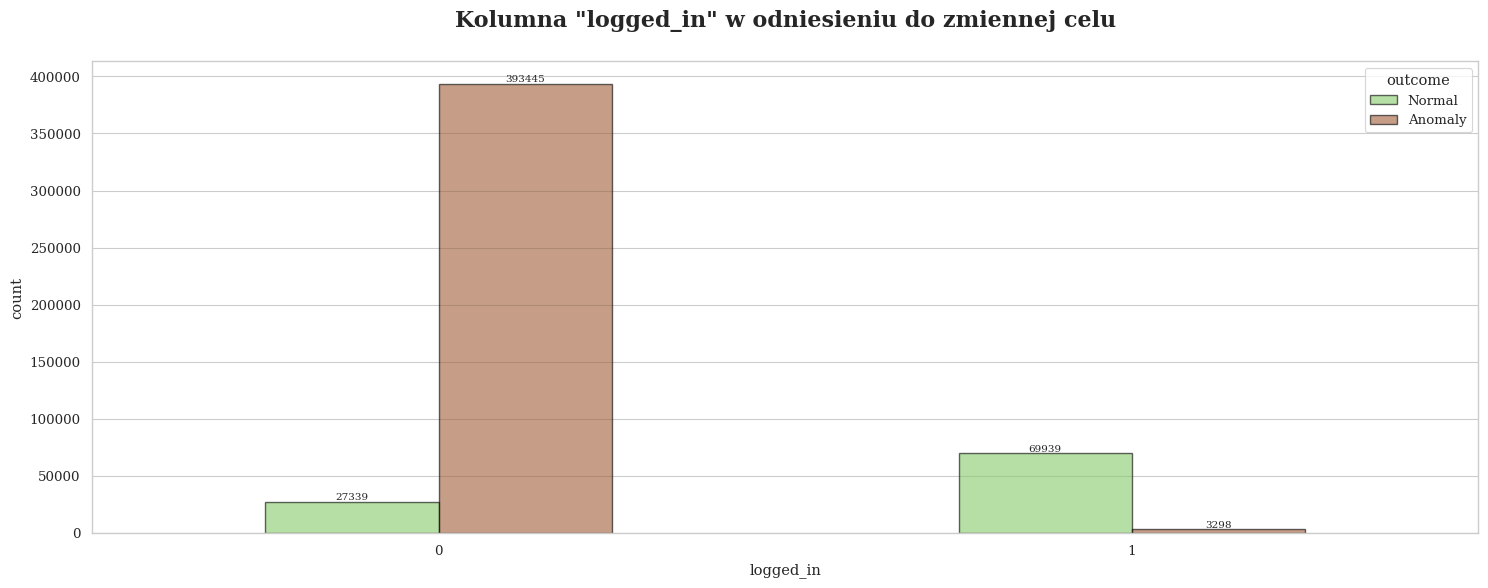

In [93]:
count(dfc['logged_in'])

**logged_in**- Przyjmuje wartości 0, 1. Wartość 1 jest charakterystyczna dla ruchu normalnego, natomiast 0- w większości to anomalie. "logged_in" może być zmienną pozwalającą odróżnić anomalie od ruchu normalnego.

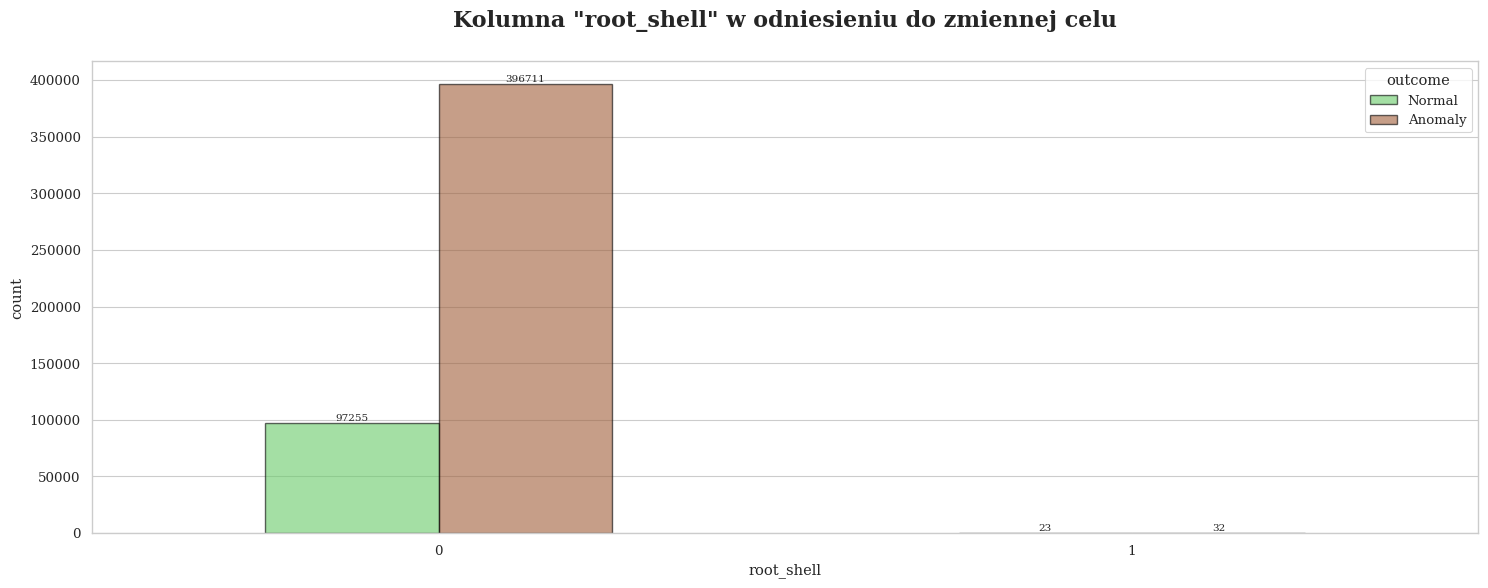

In [94]:
count(dfc['root_shell'])

**root_shell**- Przyjmuje wartości 0, 1. wartość 0 to w większości anomalie. Dla 1 rozkład klas jest podobny. "root_shell" potencjalnie może być zmienną pomagającą odróżnić anomalie od ruchu normalnego.

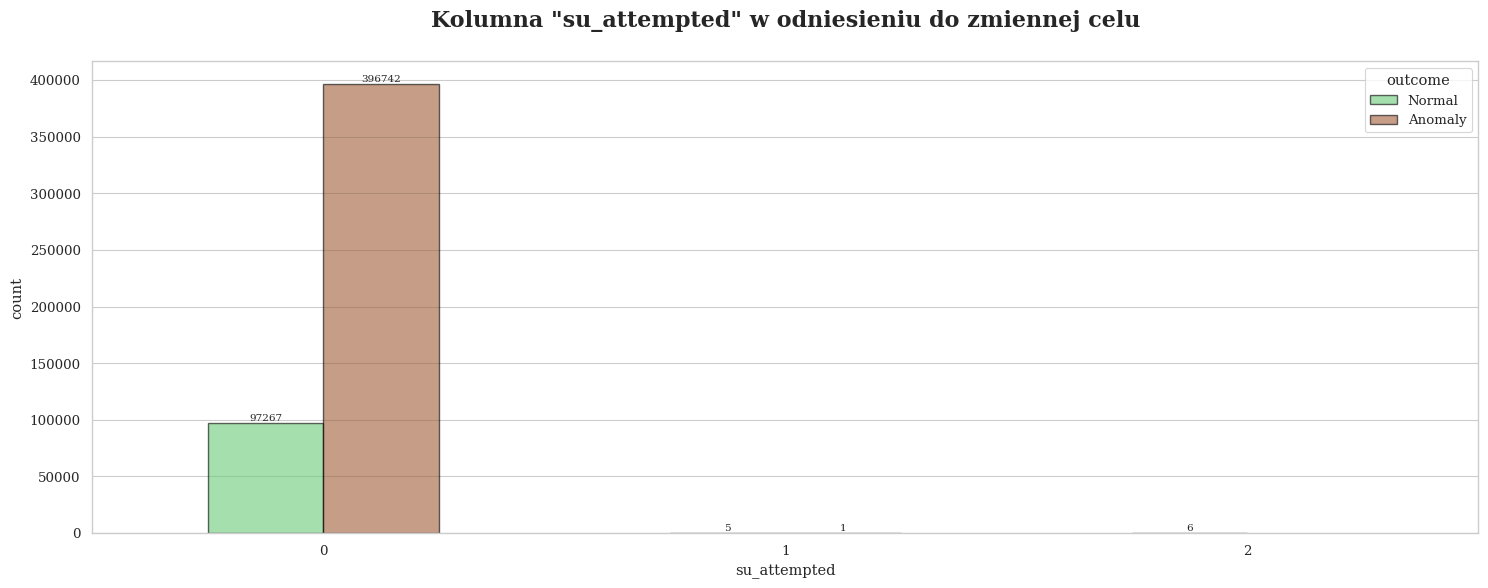

In [95]:
count(dfc['su_attempted'])

**su_attempted**- Przyjmuje wartości 0, 1, 2 (będzie przekształcona do 0, 1). wartość 0 to w większości anomalie. Natomiast wartość 1 dotyczy w znakomitej większości ruchu normalnego. "su_attempted" potencjalnie może być zmienną pomagającą odróżnić anomalie od ruchu normalnego.

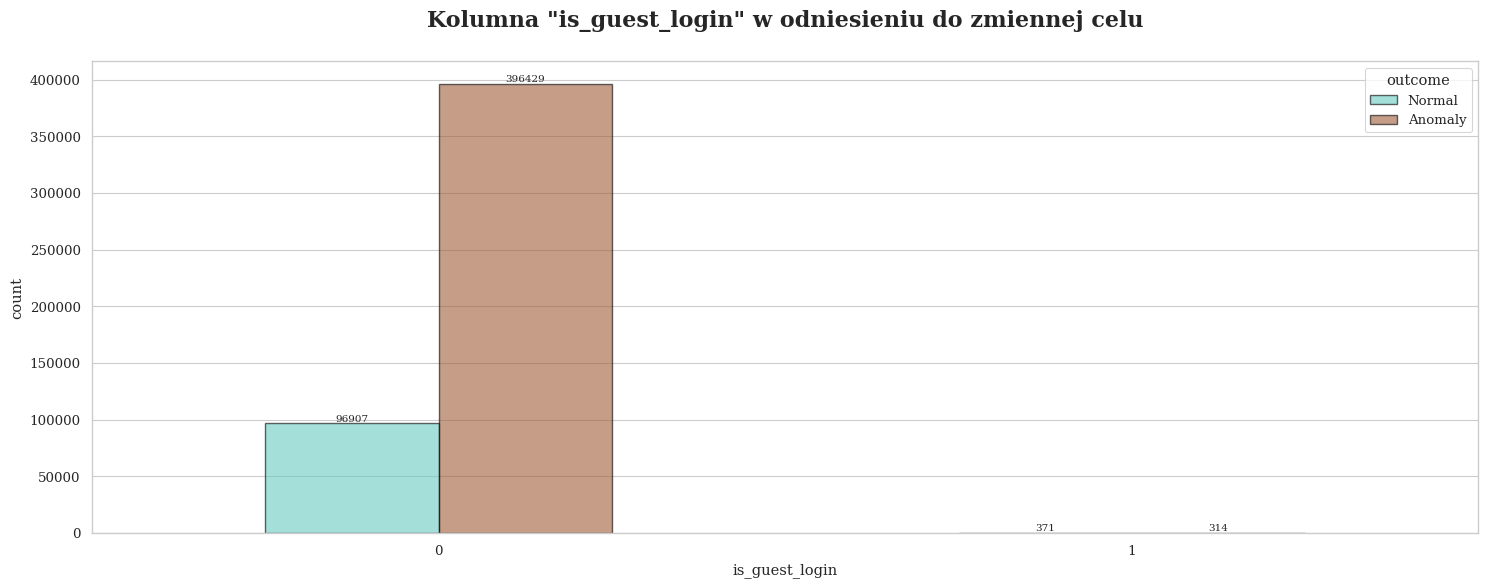

In [96]:
count(dfc['is_guest_login'])

**is_guest_login**- Przyjmuje wartości 0, 1. wartość 0 to w większości anomalie. Dla 1 rozkład klas jest podobny. "is_guest_login" może być zmienną pomagającą odróżnić anomalie od ruchu normalnego.

## Podsumowanie

Wszystkie kolumny, poza "rerror_rate", "srv_rerror_rate", "dst_host_rerror_rate" i "dst_host_srv_rerror_rate" niosą informacje pozwalające na odróżnienie ruchu normalnego od anomalii. "rerror_rate", "srv_rerror_rate", "dst_host_rerror_rate" i "dst_host_srv_rerror_rate" mogą być jednak pomocne, w połączeniu z informacjami zawartymi w innych kolumnach.

# Korelacje między zmiennym numerycznymi

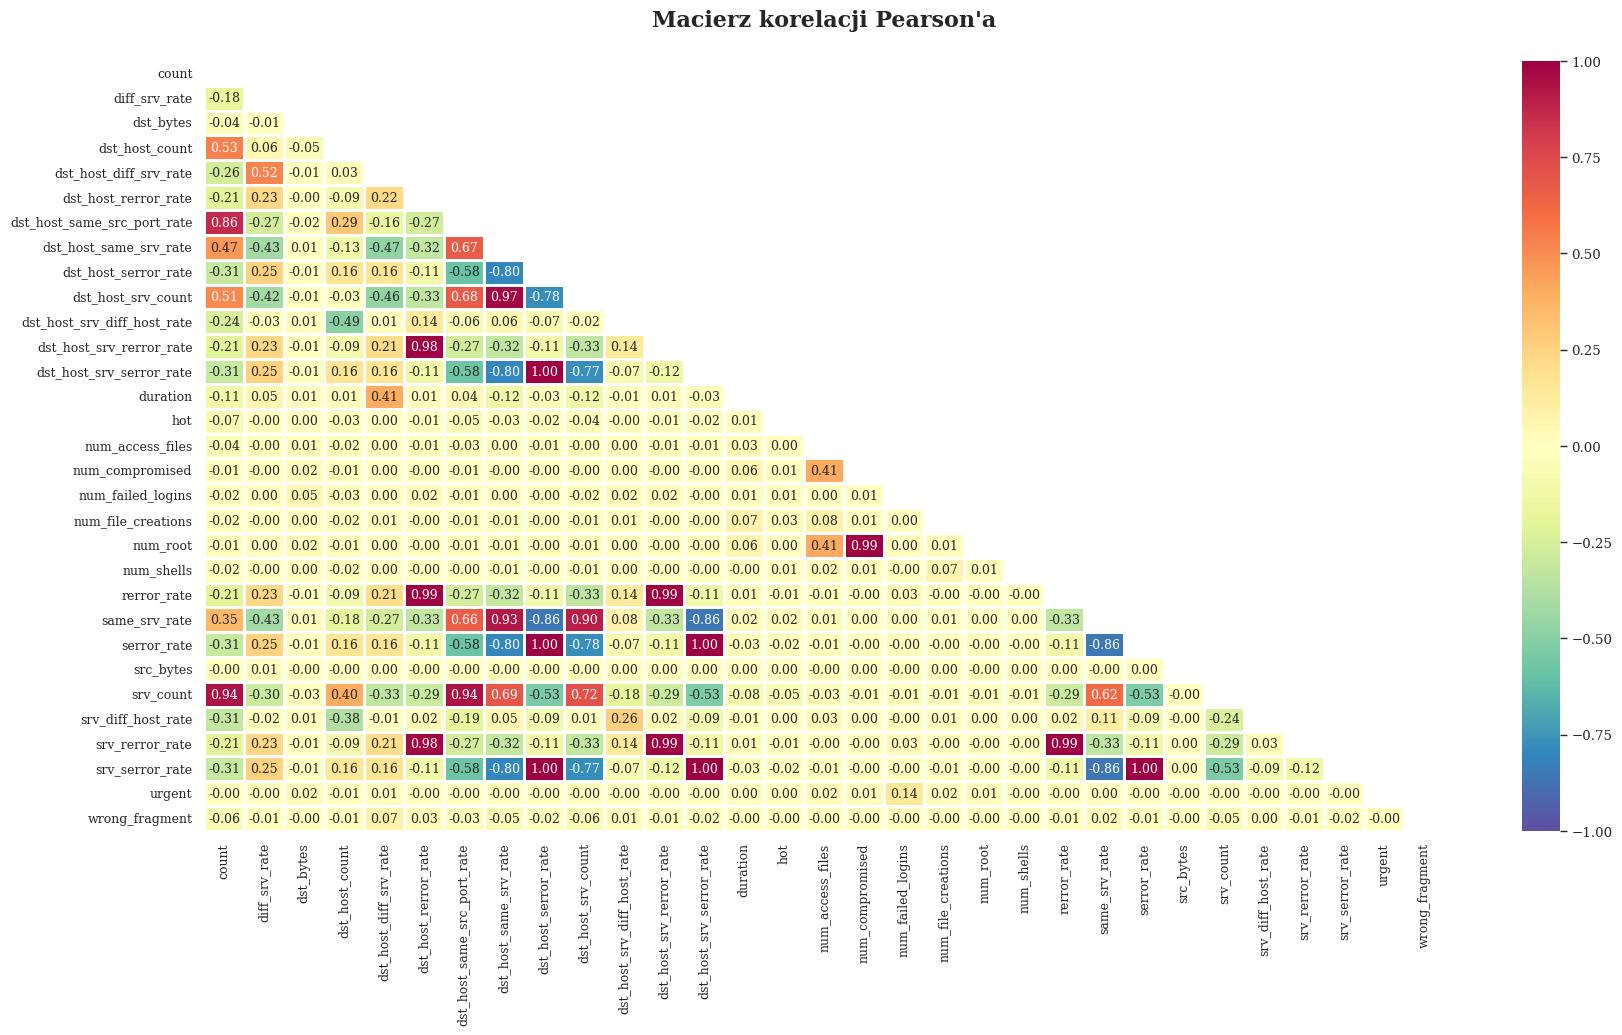

In [97]:
num_feats = dfc.select_dtypes(np.number).columns.difference(['land', 'logged_in', \
                                                             'root_shell', \
                                                              'su_attempted', \
                                                              'is_guest_login', \
                                                              'outcome'])
corr_matrix = dfc[num_feats].corr()
mask = np.triu (np.ones_like(corr_matrix, dtype = bool))

fig= plt.figure (figsize = (20,10))

sns.heatmap (corr_matrix,
             annot = True, fmt = '.2f',
             annot_kws = {'fontsize': 9},
             linewidths = 2, linecolor = 'white',
             vmin = -1, vmax = 1,
             cmap = 'Spectral_r',
             mask = mask), #maska żeby była widoczna tylko połowa

plt.grid(False)
plt.xticks (fontname = 'serif', fontsize = 9, rotation = 90)
plt.yticks (fontname = 'serif', fontsize = 9, rotation = 0)
plt.title ("Macierz korelacji Pearson'a", fontsize = 16, fontweight = "bold", fontname = 'serif', pad = 25)

plt.show()

Macierz korelacji ma na celu zobrazowanie zależności liniowych między wieloma zmiennymi. Współczynnik korelacji zawiera się w przedziale od -1 (silna korelacja ujemna- gdy jedna wartość rośnie, druga spada) do +1 (silna korelacja dodatnia- gdy jedna zmienna wzrasta, druga również wzrasta).

Część zmiennych przejawia silną korelację, w zakresie ujemnym od -0.9 do -0.7 oraz w zakresie dodatnim od 0.7 do 0.9. Są to pary zmiennych:

In [98]:
counter = 0

for i in corr_matrix.columns:
    for j in corr_matrix.index[counter + 1:]:
        if (0.7 < corr_matrix.loc[j, i] < 0.9) or (-0.9 < corr_matrix.loc[j, i] < -0.7):
            print(f"- {i} i {j} ({round(corr_matrix.loc[j, i], 2)})")
    counter += 1

- count i dst_host_same_src_port_rate (0.86)
- dst_host_same_srv_rate i dst_host_serror_rate (-0.8)
- dst_host_same_srv_rate i dst_host_srv_serror_rate (-0.8)
- dst_host_same_srv_rate i serror_rate (-0.8)
- dst_host_same_srv_rate i srv_serror_rate (-0.8)
- dst_host_serror_rate i dst_host_srv_count (-0.78)
- dst_host_serror_rate i same_srv_rate (-0.86)
- dst_host_srv_count i dst_host_srv_serror_rate (-0.77)
- dst_host_srv_count i same_srv_rate (0.9)
- dst_host_srv_count i serror_rate (-0.78)
- dst_host_srv_count i srv_count (0.72)
- dst_host_srv_count i srv_serror_rate (-0.77)
- dst_host_srv_serror_rate i same_srv_rate (-0.86)
- same_srv_rate i serror_rate (-0.86)
- same_srv_rate i srv_serror_rate (-0.86)


Ponadto, niektóre zmienne są niemal idealnie, lub idealnie skorelowane. Są to zmienne wykazujące korelację w zakresie ujemnym od -1.0 do -0.9 oraz w zakresie dodatnim od 0.9 do 1.0. Są to następujące pary zmiennych:

In [99]:
counter = 0

for i in corr_matrix.columns:
    for j in corr_matrix.index[counter + 1:]:
        if (0.9 < corr_matrix.loc[j, i] < 1.0) or (-1.0 < corr_matrix.loc[j, i] < -0.9):
            print(f"- {i} i {j} ({round(corr_matrix.loc[j, i], 2)})")
    counter += 1

- count i srv_count (0.94)
- dst_host_rerror_rate i dst_host_srv_rerror_rate (0.98)
- dst_host_rerror_rate i rerror_rate (0.99)
- dst_host_rerror_rate i srv_rerror_rate (0.98)
- dst_host_same_src_port_rate i srv_count (0.94)
- dst_host_same_srv_rate i dst_host_srv_count (0.97)
- dst_host_same_srv_rate i same_srv_rate (0.93)
- dst_host_serror_rate i dst_host_srv_serror_rate (1.0)
- dst_host_serror_rate i serror_rate (1.0)
- dst_host_serror_rate i srv_serror_rate (1.0)
- dst_host_srv_rerror_rate i rerror_rate (0.99)
- dst_host_srv_rerror_rate i srv_rerror_rate (0.99)
- dst_host_srv_serror_rate i serror_rate (1.0)
- dst_host_srv_serror_rate i srv_serror_rate (1.0)
- num_compromised i num_root (0.99)
- rerror_rate i srv_rerror_rate (0.99)
- serror_rate i srv_serror_rate (1.0)


Pozostałe kolumny wykazują umiarkowaną, słąbą bądź brak korelacji.

## Podsumowanie

Niektóre kolumny są w bardzo dużym stopniu skorelowane. Jednak, podobnie jak duplikaty wierszy, mogą nieść informację wzmacniajacą przekaz dotyczący ruchu normalnego, lub anomalii. Z tego powodu nie zostaną usunięte.

# Przygotowanie danych do modelu

In [100]:
df_prep = dfc.copy()

## Przekształcenie rozkładów danych numerycznych przy pomocy PowerTransformer

In [101]:
num_cols = df_prep.select_dtypes(include = np.number).columns.difference(['land', \
                                                                          'logged_in', \
                                                                          'root_shell', \
                                                                          'su_attempted', \
                                                                          'is_guest_login', \
                                                                          'outcome'])
num_cols

Index(['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count', 'dst_host_diff_srv_rate',
       'dst_host_rerror_rate', 'dst_host_same_src_port_rate', 'dst_host_same_srv_rate',
       'dst_host_serror_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate',
       'dst_host_srv_rerror_rate', 'dst_host_srv_serror_rate', 'duration', 'hot',
       'num_access_files', 'num_compromised', 'num_failed_logins', 'num_file_creations',
       'num_root', 'num_shells', 'rerror_rate', 'same_srv_rate', 'serror_rate', 'src_bytes',
       'srv_count', 'srv_diff_host_rate', 'srv_rerror_rate', 'srv_serror_rate', 'urgent',
       'wrong_fragment'],
      dtype='object')

In [102]:
pt = PowerTransformer(method='yeo-johnson')

df_prep[num_cols] = pt.fit_transform(df_prep[num_cols])

## Przekształcenie kolumny "su_attempted"

Ograniczenie wartości kolumny "su_attempted" z 3 wartości (0, 1, 2) do dwóch (0, 1):

In [103]:
df_prep['su_attempted'].replace (2, 1, inplace = True)
df_prep['su_attempted'].unique()

array([0, 1])

## Zakodowanie danych opisowych

Zakodowanie danych do postaci numerycznej za pomocą LabelEncodera:


In [104]:
cat_cols = df_prep.select_dtypes(include = ['object']).columns
cat_cols

Index(['protocol_type', 'service', 'flag'], dtype='object')

In [105]:
lab_enc = LabelEncoder()
for column in cat_cols:
    df_prep[column] = lab_enc.fit_transform(df_prep[column])

## Skalowanie danych numerycznych

Skalowanie danych numerycznych za pomocą MinMaxScalera:

In [106]:
num_cols = df_prep.select_dtypes(include = np.number).columns.difference(['land', \
                                                                          'logged_in', \
                                                                          'root_shell', \
                                                                          'su_attempted', \
                                                                          'is_guest_login', \
                                                                          'outcome'])
num_cols

Index(['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count', 'dst_host_diff_srv_rate',
       'dst_host_rerror_rate', 'dst_host_same_src_port_rate', 'dst_host_same_srv_rate',
       'dst_host_serror_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate',
       'dst_host_srv_rerror_rate', 'dst_host_srv_serror_rate', 'duration', 'flag', 'hot',
       'num_access_files', 'num_compromised', 'num_failed_logins', 'num_file_creations',
       'num_root', 'num_shells', 'protocol_type', 'rerror_rate', 'same_srv_rate', 'serror_rate',
       'service', 'src_bytes', 'srv_count', 'srv_diff_host_rate', 'srv_rerror_rate',
       'srv_serror_rate', 'urgent', 'wrong_fragment'],
      dtype='object')

In [107]:
scaler = MinMaxScaler(feature_range = (0, 1))
df_prep[num_cols] = scaler.fit_transform(df_prep[num_cols])

## Podział danych na podzbiory treningowy i testowy

In [108]:
df_train, df_test = train_test_split(df_prep, test_size = 0.2, random_state = 42, shuffle = True)
df_train.shape, df_test.shape

((395216, 40), (98805, 40))

## Wydzielenie podzbiorów zawierających przypadki ruchu normalnego i wskazującego na atak

In [109]:
df_train_normal = df_train[df_train['outcome'] == 0].reset_index(drop = True)
df_train_anom = df_train[df_train['outcome'] == 1].reset_index(drop = True)
df_test_normal = df_test[df_test['outcome'] == 0].reset_index(drop = True)
df_test_anom = df_test[df_test['outcome'] == 1].reset_index(drop = True)

Usunięcie kolumny "outcome" z utworzonych podzbiorów:

In [110]:
df_train_normal = df_train_normal.drop(columns = ['outcome'])
df_train_anom = df_train_anom.drop(columns = ['outcome'])
df_test_normal = df_test_normal.drop(columns = ['outcome'])
df_test_anom = df_test_anom.drop(columns = ['outcome'])

# Utworzenie i wytrenowanie modelu

Określenie rozmiaru danych wejściowych:

In [111]:
input_dim = df_train_normal.shape[1]
input_dim

39

## Utworzenie modelu typu autoencoder

In [112]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape = (input_dim,)))
model.add(tf.keras.layers.Dense(128, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(64, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(32, activation = "relu"))
model.add(tf.keras.layers.Dense(8, activation = "relu"))
model.add(tf.keras.layers.Dense(32, activation = "relu"))
model.add(tf.keras.layers.Dense(64, activation = "relu"))
model.add(tf.keras.layers.Dense(128, activation = "relu"))
model.add(tf.keras.layers.Dense(input_dim, activation = "sigmoid"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 39)                  │           5,031 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,471 (122.93 KB)

 Trainable params: 31,471 (122.93 KB)

 Non-trainable params: 0 (0.00 B)

## Kompilacja i wytrenowanie modelu

In [113]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [114]:
early_stopping = EarlyStopping (monitor = 'val_loss', patience = 20, verbose = 1,
                                restore_best_weights = True)

fit = model.fit(df_train_normal, df_train_normal, epochs = 500, batch_size = 512,
                validation_data = (df_test_normal, df_test_normal),
                callbacks = [early_stopping])

Epoch 1/500
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3724 - val_loss: 0.1466
Epoch 2/500
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1347 - val_loss: 0.1064
Epoch 3/500
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1069 - val_loss: 0.0966
Epoch 4/500
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0984 - val_loss: 0.0924
Epoch 5/500
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0944 - val_loss: 0.0899
Epoch 6/500
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0924 - val_loss: 0.0886
Epoch 7/500
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0907 - val_loss: 0.0876
Epoch 8/500
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0897 - val_loss: 0.0868
Epoch 9/500
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0887 - val_loss: 0.0861
Epoch 10/500
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0882 - val_loss: 0.0856
Epoch 11/500
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0877 - val_loss: 0.0851
Epoch 12/500
153/153 ━━━━━━━━━━━━━━━━━━━

## Utworzenie wykresu przebiegu uczenia sieci

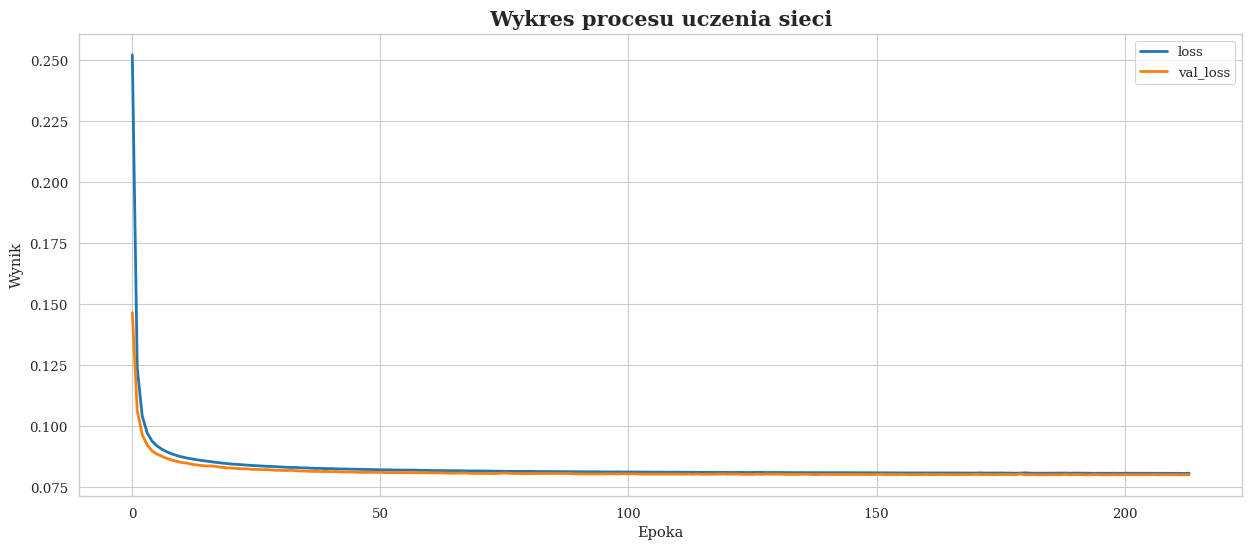

In [115]:
plt.figure(figsize = (15, 6))

plt.plot(fit.history['loss'], '-', label = 'loss')
plt.plot(fit.history['val_loss'], '-', label = 'val_loss')

plt.title ('Wykres procesu uczenia sieci', {'fontsize': 15,
 'fontweight': 'semibold'})
plt.xlabel('Epoka')
plt.ylabel('Wynik')
plt.legend()

# Ocena jakości wytrenowanego modelu

## Wykonanie predykcji na danych treningowych i testowych

In [116]:
df_train_normal_pred = model.predict(df_train_normal)
df_test_normal_pred = model.predict(df_test_normal)
df_train_anom_pred = model.predict(df_train_anom)
df_test_anom_pred = model.predict(df_test_anom)

2436/2436 ━━━━━━━━━━━━━━━━━━━━ 2s 830us/step
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step
9916/9916 ━━━━━━━━━━━━━━━━━━━━ 9s 910us/step
2483/2483 ━━━━━━━━━━━━━━━━━━━━ 2s 916us/step


## Wizualizacja błędu rekonstrukcji dla danych treningowych i testowych

In [117]:
train_normal_loss = np.mean(np.abs(df_train_normal - df_train_normal_pred), axis = 1)
test_normal_loss = np.mean(np.abs(df_test_normal - df_test_normal_pred), axis = 1)
train_anom_loss = np.mean(np.abs(df_train_anom - df_train_anom_pred), axis = 1)
test_anom_loss = np.mean(np.abs(df_test_anom - df_test_anom_pred), axis = 1)

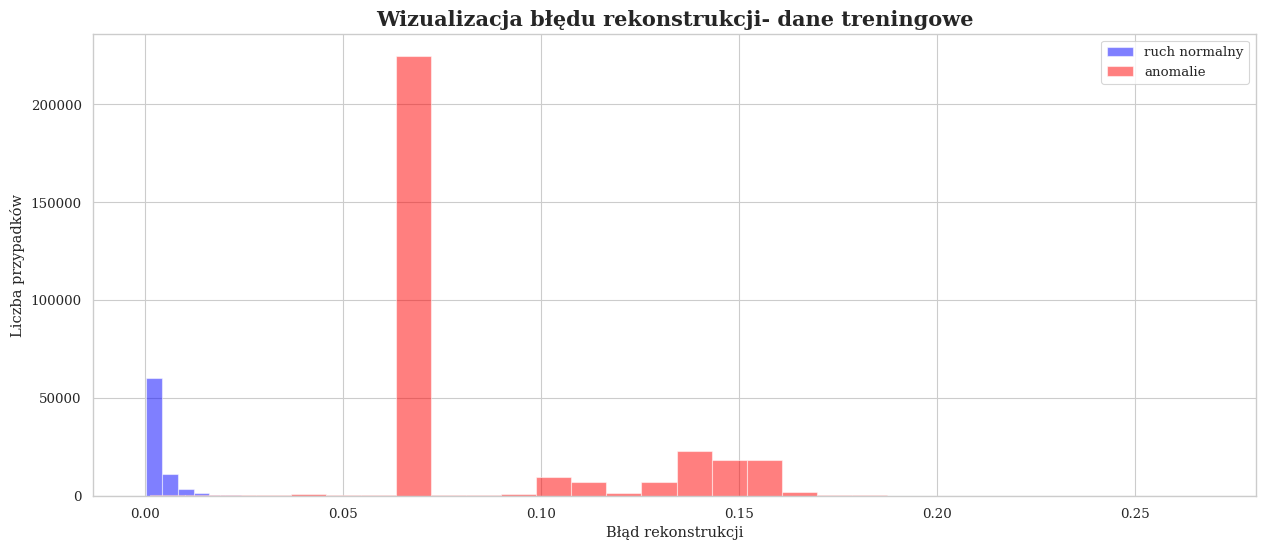

In [118]:
plt.figure(figsize = (15, 6))
plt.hist(train_normal_loss, bins = 30, alpha = 0.5, color = "blue", label = "ruch normalny")
plt.hist(train_anom_loss, bins = 30, alpha = 0.5, color = "red", label = "anomalie");
plt.title ('Wizualizacja błędu rekonstrukcji- dane treningowe', {'fontsize': 15,
 'fontweight': 'semibold'})
plt.xlabel('Błąd rekonstrukcji')
plt.ylabel('Liczba przypadków')
plt.legend()
plt.show()

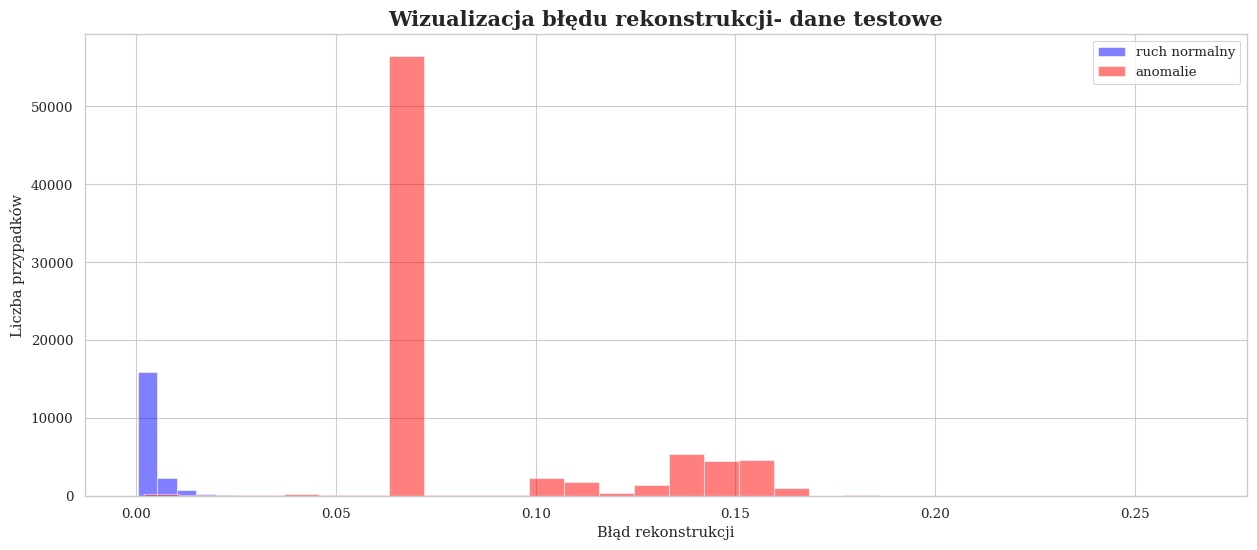

In [119]:
plt.figure(figsize = (15, 6))
plt.hist(test_normal_loss, bins = 30, alpha = 0.5, color = "blue", label = "ruch normalny")
plt.hist(test_anom_loss, bins = 30, alpha = 0.5, color = "red", label = "anomalie");
plt.title ('Wizualizacja błędu rekonstrukcji- dane testowe', {'fontsize': 15,
 'fontweight': 'semibold'})
plt.xlabel('Błąd rekonstrukcji')
plt.ylabel('Liczba przypadków')
plt.legend()
plt.show()

## Wybór optymalnego progu odcięcia (threshold)

In [135]:
#5344 	0.986306 	0.000878 	0.065065
threshold_test = np.percentile(test_normal_loss, 98.6)
threshold_test

0.01874303489671891

## Macierz pomyłek dla wybranego progu odcięcia

In [136]:
y_true = np.concatenate([np.zeros(len(test_normal_loss)), np.ones(len(test_anom_loss))])
y_pred = np.concatenate([test_normal_loss, test_anom_loss]) > threshold_test

conf_mat = confusion_matrix(y_true, y_pred)

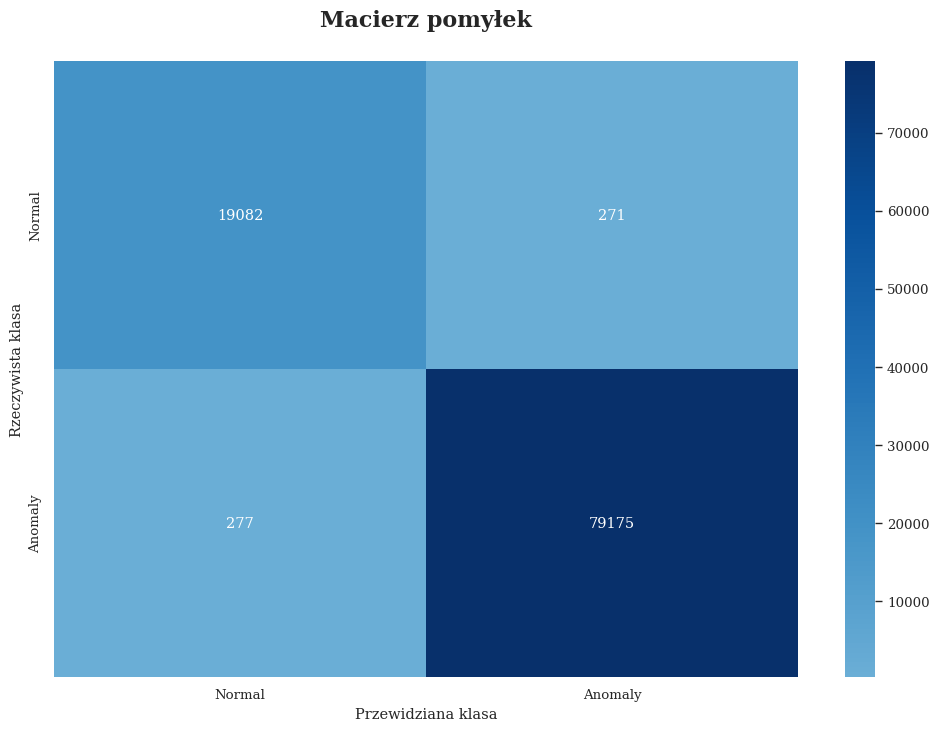

In [146]:
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap = 'Blues', center = 0,
            xticklabels = ["Normal", "Anomaly"],
            yticklabels = ["Normal", "Anomaly"])

plt.xlabel("Przewidziana klasa")
plt.ylabel("Rzeczywista klasa")
plt.title("Macierz pomyłek", fontsize = 16, fontweight = "bold",
          fontname = 'serif',
          pad = 25)
plt.show()

## Wykres krzywej ROC

In [131]:
fpr, tpr, thresholds = roc_curve(y_true, np.concatenate([test_normal_loss,
                                                         test_anom_loss]))

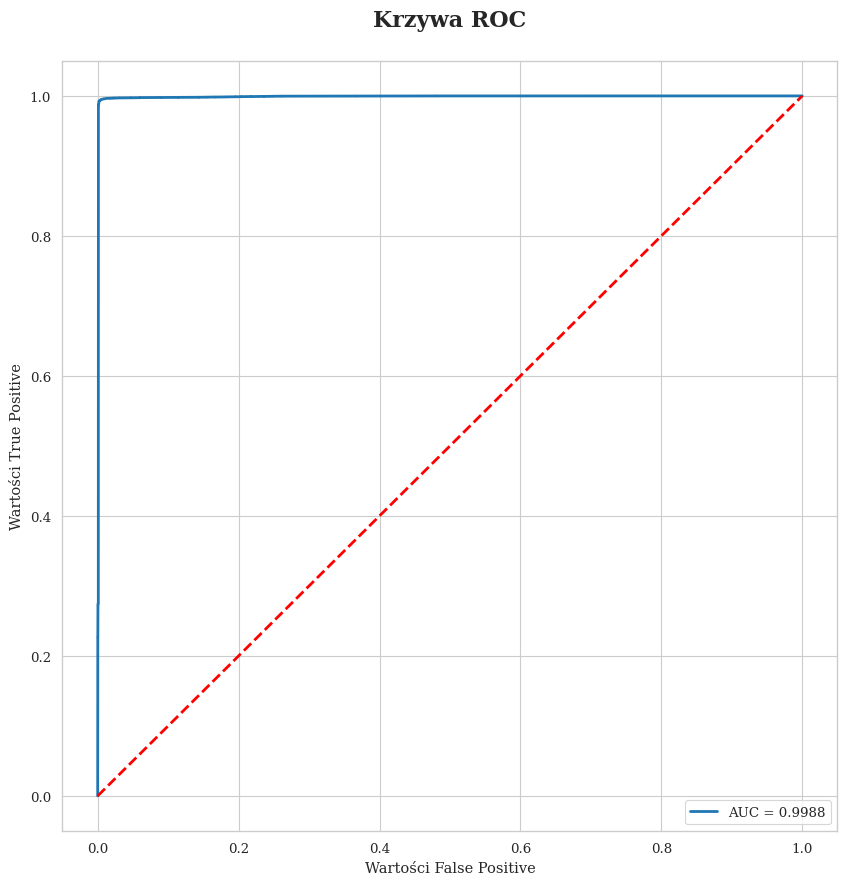

In [132]:
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Wartości False Positive')
plt.ylabel('Wartości True Positive')
plt.title('Krzywa ROC', fontsize = 16, fontweight = 'bold',
          fontname = 'serif',
          pad = 25)
plt.legend(loc = 'lower right')
plt.show()

In [133]:
df_thresh = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'thresholds': thresholds})

In [138]:
df_thresh[df_thresh['tpr'] > 0.98].head(50)
# 5397 	0.985022 	0.001292 	0.066721

tpr       fpr  thresholds
5315  0.980466  0.000878    0.066639
5316  0.980605  0.000878    0.066639
5317  0.980617  0.000878    0.066621
5318  0.980705  0.000878    0.066604
5319  0.981511  0.000878    0.066604
5320  0.982090  0.000878    0.066569
5321  0.982165  0.000878    0.066569
5322  0.982178  0.000878    0.066554
5323  0.982203  0.000878    0.066540
5324  0.982631  0.000878    0.066534
5325  0.982694  0.000878    0.066534
5326  0.982707  0.000878    0.066506
5327  0.983437  0.000878    0.066499
5328  0.983499  0.000878    0.066499
5329  0.983588  0.000878    0.066464
5330  0.984041  0.000878    0.066429
5331  0.984368  0.000878    0.066394
5332  0.984381  0.000878    0.066394
5333  0.984620  0.000878    0.066360
5334  0.984632  0.000878    0.066328
5335  0.984657  0.000878    0.066325
5336  0.985350  0.000878    0.066325
5337  0.985476  0.000878    0.066291
5338  0.985513  0.000878    0.066291
5339  0.985526  0.000878    0.066256
5340  0.985853  0.000878    0.066256
5341  0.985866  0.000878    0.066206
5342  0.985891  0.000878    0.066188
5343  0.986092  0.000878    0.066188
5344  0.986306  0.000878    0.065065
5345  0.986306  0.000930    0.064954
5346  0.986747  0.000930    0.061991
5347  0.986747  0.000982    0.061974
5348  0.986759  0.000982    0.061935
5349  0.986847  0.000982    0.061855
5350  0.986961  0.000982    0.061421
5351  0.986961  0.001033    0.061395
5352  0.987087  0.001033    0.060788
5353  0.987087  0.001085    0.060708
5354  0.987275  0.001085    0.059542
5355  0.987301  0.001085    0.059468
5356  0.987628  0.001085    0.057707
5357  0.987628  0.001137    0.057637
5358  0.987640  0.001137    0.057627
5359  0.987640  0.001188    0.057477
5360  0.987666  0.001188    0.057339
5361  0.987691  0.001188    0.057308
5362  0.987829  0.001188    0.056217
5363  0.987829  0.001240    0.056217
5364  0.988043  0.001240    0.055177

# Dyskusja przebiegu projektu i jego wyników, wnioski

W ramach projektu stworzono oraz wytrenowano model sieci neuronowej w postaci głębokiego autoenkodera, którego zadaniem jest rozróżnianie zwykłaego ruchu sieciowego od ruchu anormalnego (wskazującego na atak na sieć). Zadanie wykonano na bazie danych pochodzących z MIT Lincoln Labs, ze zbudowanego specjalnie w tym celu laboratorium sieciowego do symulowania i badania różnych form ataku.

## Przebieg projektu

1. Zbiór danych zawierał 494021 wierszy w 42 kolumnach, bez wierszy pustych. 70 % danych stanowiły duplikaty. Ponieważ pakiety danych mogą mieć powtarzalną charakterystykę, duplikatów nie usuwano. Usunięto za to dwie kolumny zawierające same zera.

2. Wykonano eksploracyjną analizę danych, która wykazała, że rozkłady dużej części zmiennych są prawoskośne lub lewoskośne i zawierają outliery. W celu poprawienia rozkładów, dane numeryczne zostały przekształcone za pomocą PowerTransformer metodą "yeo-johnson". Nie wykonywano usunięcia outlierów, ponieważ dane w poszczególnych kolumnach były skoncentrowane w wartości skrajnej (0 lub 1) w ok. 90 % lub więcej, przez co wszystkie inne wartości zostały potraktowane jako outliery.

3. Wykonano analizę rozkładu danych w odniesieniu do zmiennej celu "outcome", która wykazała przydatność wszystkich danych do określenia rodzaju ruchu, jak również analizę korelacji między danymi numerycznymi. Analiza wykazała wysoki stopień skorelowania niektórych zmiennych.

4. Dane kategoryczne opisowe zakodowano przy pomocy LabelEncodera. Ponieważ model wymagał wartości w przedziale (0, 1), w kolejnym kroku wszystkie kolumny numeryczne (poza kolumnami o wartościach binarnych) przeskalowano za pomocą MinMaxScalera.

5. Utworzono dane treningowe i testowe dotyczące ruchu normalnego i anomalii. Utworzono model sieci neuronowej typu autoenkoder zawierający 4 warstwy gęste (128, 64, 32, 8). Aby zapobiec przeuczeniu modelu dodano warstwy Dropout, wyłączające 10 % neuronów.

6. Model skompilowano z uzyciem optymizera "adam" oraz funkcji straty "binary crossentropy", a następnie wytrenowano z użyciem wywołań wstecznych Early Stopping.

7. Dokonano predykcji na danych treningowych i testowych oraz obliczono błąd rekonstrukcji dla danych treningowych i testowych. Określono optymalny punkt odcięcia i sporządzono macierz pomyłek oraz wykres krzywej ROC.

W trakcie wykonywania projektu, przeprowadzono kilka prób czyszczenia danych poprzez np: usunięcie duplikatów, czy usunięcie kolumn wykazujących idealną korelację (co oznacza redundancję danych). Podjęto również próbę przekształcenia danych kategorycznych metodą One Hot, zamiast LabelEncoderem. Żadne z tych działań nie przyniosło znaczącego wzrostu możliwości rozróżniania klas przez model. Usunięcie duplikatów wręcz pogorszyło jego możliwości rozróźnienia ruchu normalnego od anomalii. Dlatego ostatecznie zrezygnowano z czyszczenia danych, traktując duplikaty i redundancję danych jako sygnał wzmacniający informację dot. rodzaju ruchu sieciowego. Ostatecznie dokonano jedynie przekształcenia kolumn numerycznych za pomocą PowerTransformera.

## Wyniki

Z histogramu błędu rekonstrukcji wynika, że przypadki ruchu normalnego mają znacznie niższe błędy rekonstrukcji, niż anomalie. Oznacza to, że model dobrze rozróżnia obie grupy. Również liczba błędnie sklasyfikowanych przypadków jest bardzo niska w porównaniu do przypadków sklasyfikowanych poprawnie. Wartość AUC sugeruje, że model ma dobrą zdolność rozróżniania klas, bliską maksymalnej wartości 1.


## Wnioski

Otrzymany model skutecznie wykrywa anomalie, a liczba błędnych klasyfikacji jest marginalna w stosunku do całości danych.